# Trabajo Practico
Alumna: Sabrina Benedetto

## Objetivo
Entrenar modelos de machine learning que ayuden a predecir patrones de las categorías programáticas del gasto público de Argentina.

## Información
El dataset se arma a partit de los datos de "Presupuesto de gastos y su ejecución detallada - agrupación anual XXXX. Distribución anual acumulada de los créditos presupuestarios con todos los clasificadores. XXXX.", formato zip, publicados en <https://datos.gob.ar/>.  
Se toma en cuenta la información a partir del año 2002, cuando se abandona la convertibilidad cambiaria y comienza el modelo de flotación del peso con un tipo de cambio libre, que se mantiene hasta la actualidad.  

Por otro lado, se accederá a la información del presupuesto del año 2025 a través de la **API del presupuesto abierto** <https://datos.gob.ar/dataset/sspre_api/archivo/sspre_API> disponible también en el portal de datos abiertos del Gobierno Nacional. La API se utilizará para aplicar el modelo a datos actuales y predecir los resultados del año en curso.

## Introducción al tema
Las diferencias entre los valores presupuestados (*crédito presupuestado*) y los efectivamente ejecutados (*crédito devengado*) reflejan el grado de eficiencia del proceso presupuestario y de la asignación de recursos públicos.

#### Conceptos de gasto presupuestario  

El gasto, según el momento presupuestario, se denomina de la siguiente manera:  
- **VIGENTE**: Crédito inicial aprobado en la Ley de Presupuesto con las modificaciones presupuestarias (crédito presupuestado)
- **COMPROMETIDO**: Mecanismo para dejar afectado. Ya hay una relación jurídica con un beneficiario específico.
- **DEVENGADO**: Surge de la obligación de pago, por la recepción de bienes o servicios contratados. Aquí el gasto se considera realizado
- **PAGADO**: Refleja la cancelación de las obligaciones

Se plantea que el comportamiento de las categorías programáticas del gasto presupuestario está directamente influenciado por variables macroeconómicas, principalmente la variación del **tipo de cambio** y del **nivel general de precios**.  

En consecuencia, es posible predecir, mediante técnicas de aprendizaje automático, si una categoría programática presentará un desvío entre la ejecución presupuestaria y el presupuesto inicial, así como la magnitud esperada de dicha desviación, en función del contexto macroeconómico observado.  

### APLICACIÓN TÉCNICAS DE MACHINE LEARNING
Para ello, se presentan **2 MODELOS de ML**:

#### 1. MODELO 1: Clasificación de Tipo de Ejecución Presupuestaria
**Pregunta a responder**: ¿Qué tipo de ejecución tendrá esta categoría programática?  

Se clasifican 3 tipos de categorías de ejecución que representan procesos presupuestarios **conceptualmente distintos**:
 
> a. `Ejecución Normal`: CP > 0 y CD > 0 (se planificó y se ejecutó)  
b. `Reasignación`: CP = 0 y CD > 0 (no se planificó pero se ejecutó)  ➡️ INEFICIENCIA EN LA EJECUCION PRESUPUESTARIA (indica la revisión del proceso de planificación)  
c. `Sin Ejecución`: CP > 0 y CD = 0 (se planificó pero no se ejecutó) ➡️ INEFICIENCIA EN LA EJECUCION PRESUPUESTARIA (alerta sobre la capacidad de ejecución)
>

**Respuesta esperada (target)**: tipo de ejecucion (3 categorías)

##### Hipótesis  del Modelo 1  
La planificación presupuestaria es afectada por las variables macroeconómicas, tales como el tipo de cambio y el nivel general de precios, afectando el tipo de ejecución presupuestaria.  

**Hipótesis Nula (H₀):**
El tipo de ejecución presupuestaria (Ejecución Normal, Reasignación, Sin Ejecución) es independiente de las condiciones macroeconómicas (tipo de cambio, inflación y sus volatilidades).  

**Hipótesis Alternativa (H₁):**
El tipo de ejecución presupuestaria está asociado a las condiciones macroeconómicas.

#### 2. MODELO 2: Predicción de la Eficiencia de la Ejecución Presupuestaria (paso posterior)
 
**Pregunta a responder**: Si se planificó presupuesto, ¿qué tan eficiente será la ejecución?  

donde la eficiencia de la ejecución presupuestaria se define a partir del ratio de **Eficiencia del Crédito Presupuestado (ECP)**:  
$$
\text{ECP} = \frac{\text{Crédito Devengado (CD)}}{\text{Crédito Presupuestado (CP)}}
$$

Donde, si:  
- `ECP` > 1 → Planificación ineficiente. Ampliaciones significativas del crédito no previstas (cambios en la política presupuestaria programada), gastos no controlados o shocks externos.
- `ECP` < 1 → Planificación ineficiente. Subutilización del crédito previsto, subestimación de restricciones presupuestarias o reducciones por reasignación (cambios en la política presupuestaria programada).
- `ECP` = 1 → Planificación eficiente. Correspondencia entre lo planificado y lo ejecutado.

**Condición**: Sólo registros donde CP > 0
**Target**:
>Opción A (Regresión): Valor numérico del ECP  
 Opción B (Clasificación): Categorías de eficiencia (sub/eficiente/sobre-ejecución)

##### Hipótesis  del Modelo 2
La planificación presupuestaria es afectada por las variables macroeconómicas, tales como el tipo de cambio y el nivel general de precios, generando desvíos entre el crédito presupuestado inicial y la ejecución final.  

**Hipótesis nula (H₀)**
No existe relación estadísticamente significativa entre la eficiencia del crédito presupuestado (medida por el ratio ECP) y las variables macroeconómicas consideradas (tipo de cambio e inflación).
En consecuencia, dichas variables no permiten predecir de manera confiable si una categoría programática presentará ineficiencias en la ejecución presupuestaria.  

**Hipótesis alternativa (H₁)**  
Existe una relación estadísticamente significativa entre la eficiencia del crédito presupuestado (medida por el ratio ECP) y las variables macroeconómicas analizadas (tipo de cambio e inflación).
Por lo tanto, es posible predecir el comportamiento de la eficiencia del crédito presupuestado a partir de estas variables.

# A. Datos presupuestarios

In [46]:
# Librerías
# =================================================================================================
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Datos presupuestarios - Carga de datasets históricos (2002-2024)
# ==================================================================================================
dfs = []

for anio in range(2002, 2025):  # incluye 2024
    url = f"https://dgsiaf-repo.mecon.gob.ar/repository/pa/datasets/{anio}/credito-anual-{anio}.zip"
    print(f"🔄 Intentando descargar {anio}...")

    r = requests.get(url)
    if r.status_code != 200:
        print(f"❌ No se pudo descargar el archivo de {anio} (status {r.status_code})")
        continue

    carpeta = f"data/{anio}"
    os.makedirs(carpeta, exist_ok=True)

    # Descomprimir en carpeta
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(carpeta)
        print(f"✅ Archivo de {anio} descargado y extraído en '{carpeta}'")
    except Exception as e:
        print(f"❌ Error al descomprimir {anio}: {e}")
        continue

    # Buscar CSV dentro de la carpeta
    archivos = [f for f in os.listdir(carpeta) if f.endswith(".csv")]
    if not archivos:
        print(f"⚠️ No se encontró CSV en {anio}")
        continue

    archivo_csv = os.path.join(carpeta, archivos[0])

    # Leer CSV
    try:
        df = pd.read_csv(archivo_csv, sep=",", low_memory=False)  # se usa el low_memory=False apra eliminar los warnings
        df["anio"] = anio                                         # columna extra para identificar año
        dfs.append(df)
        print(f"✅ CSV de {anio} leído correctamente ({len(df)} filas)")
    except Exception as e:
        print(f"❌ Error leyendo {archivo_csv}: {e}")

🔄 Intentando descargar 2002...
✅ Archivo de 2002 descargado y extraído en 'data/2002'
✅ CSV de 2002 leído correctamente (62853 filas)
🔄 Intentando descargar 2003...
✅ Archivo de 2003 descargado y extraído en 'data/2003'
✅ CSV de 2003 leído correctamente (60885 filas)
🔄 Intentando descargar 2004...
✅ Archivo de 2004 descargado y extraído en 'data/2004'
✅ CSV de 2004 leído correctamente (66129 filas)
🔄 Intentando descargar 2005...
✅ Archivo de 2005 descargado y extraído en 'data/2005'
✅ CSV de 2005 leído correctamente (80890 filas)
🔄 Intentando descargar 2006...
✅ Archivo de 2006 descargado y extraído en 'data/2006'
✅ CSV de 2006 leído correctamente (87924 filas)
🔄 Intentando descargar 2007...
✅ Archivo de 2007 descargado y extraído en 'data/2007'
✅ CSV de 2007 leído correctamente (98161 filas)
🔄 Intentando descargar 2008...
✅ Archivo de 2008 descargado y extraído en 'data/2008'
✅ CSV de 2008 leído correctamente (103842 filas)
🔄 Intentando descargar 2009...
✅ Archivo de 2009 descargado y

In [47]:
# Verificar que los datos se leyeron bien
print(f"DataFrames descargados: {len(dfs)}")
print(f"Ejemplo - primer DF: {dfs[0].shape}")

DataFrames descargados: 23
Ejemplo - primer DF: (62853, 53)


In [48]:
# Concatenar todos los DataFrames
df_presupuesto_anual = pd.concat(dfs, ignore_index=True)
print("✅ Datos concatenados exitosamente!")
print(f"📊 Total registros: {len(df_presupuesto_anual):,}")
print(f"📋 Total columnas: {len(df_presupuesto_anual.columns)}")

# Verificar años incluidos
if 'anio' in df_presupuesto_anual.columns:
    print(f"📅 Años incluidos: {sorted(df_presupuesto_anual['anio'].unique())}")

# Guardar
os.makedirs("data_anual_unificada", exist_ok=True)
archivo_unificado = "data_anual_unificada/presupuesto_anual_2002_2024.csv"
df_presupuesto_anual.to_csv(archivo_unificado, index=False, encoding="utf-8")
print(f"💾 Guardado en: {archivo_unificado}")

✅ Datos concatenados exitosamente!
📊 Total registros: 2,581,397
📋 Total columnas: 57
📅 Años incluidos: [np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
💾 Guardado en: data_anual_unificada/presupuesto_anual_2002_2024.csv


## 1. Limpieza y transformación de datos

### Paso 1️⃣ Homogeneizar columnas

Verificar que los CSV de distintos años tengan siempre los mismos nombres de columnas y así evitar columnas duplicadas o vacías que pueden generar errores o exceso de información.

In [49]:
# Verificar consistencia en NOMBRES de columnas entre años
print("🔍 Verificando nombres de columnas por año:\n")

# Recopilar nombres de columnas por año
columnas_por_año = {}
for i, df in enumerate(dfs):
    año = 2002 + i
    columnas_por_año[año] = list(df.columns)
    print(f"{año}: {len(df.columns)} columnas")

print("\n" + "="*50)
# Comparar cada año con el año base (2002)
año_base = 2002
columnas_base = set(columnas_por_año[año_base])

print(f"📋 Usando {año_base} como año base ({len(columnas_base)} columnas)")
print(f"🔍 Comparando todos los años contra {año_base}:\n")

# Calcular columnas comunes a TODOS los años
columnas_comunes = columnas_base.copy()  # Empezar con el año base
for año, columnas in columnas_por_año.items():
    columnas_comunes = columnas_comunes.intersection(set(columnas))

print(f"📋 Usando {año_base} como año base ({len(columnas_base)} columnas)")

# Mostrar columnas comunes
print(f"\n✅ Columnas comunes a TODOS los años: {len(columnas_comunes)}")
columnas_comunes_lista = sorted(list(columnas_comunes))
for i, col in enumerate(columnas_comunes_lista):
    print(f"  {i+1}. {col}")

print(f"\n🔍 Comparando todos los años contra {año_base}:\n")

# Mostrar columnas diferentes
años_inconsistentes = []
for año, columnas in columnas_por_año.items():
    if año == año_base:
        continue

    columnas_actuales = set(columnas)

    # Columnas que faltan en el año actual
    faltan = columnas_base - columnas_actuales
    # Columnas nuevas en el año actual
    nuevas = columnas_actuales - columnas_base

    if faltan or nuevas:
        años_inconsistentes.append(año)
        print(f"⚠️  {año}:")
        if faltan:
            print(f"   ❌ Faltan: {len(faltan)} columnas")
            for col in sorted(list(faltan)):  # Mostrar TODAS las columnas faltantes
                print(f"      - {col}")

        if nuevas:
            print(f"   ➕ Nuevas: {len(nuevas)} columnas")
            for col in sorted(list(nuevas)):  # Mostrar TODAS las columnas nuevas
                print(f"      - {col}")
    else:
        print(f"✅ {año}: Columnas idénticas")

print(f"\n📊 RESUMEN:")
print(f"✅ Años consistentes: {23 - len(años_inconsistentes)}/23")
print(f"⚠️  Cantidad de años inconsistentes: {len(años_inconsistentes)}/23")
if años_inconsistentes:
    print(f"   Años con columnas diferentes: {años_inconsistentes}")

🔍 Verificando nombres de columnas por año:

2002: 53 columnas
2003: 53 columnas
2004: 53 columnas
2005: 53 columnas
2006: 53 columnas
2007: 53 columnas
2008: 53 columnas
2009: 53 columnas
2010: 53 columnas
2011: 53 columnas
2012: 53 columnas
2013: 53 columnas
2014: 53 columnas
2015: 53 columnas
2016: 53 columnas
2017: 53 columnas
2018: 53 columnas
2019: 53 columnas
2020: 53 columnas
2021: 57 columnas
2022: 57 columnas
2023: 57 columnas
2024: 57 columnas

📋 Usando 2002 como año base (53 columnas)
🔍 Comparando todos los años contra 2002:

📋 Usando 2002 como año base (53 columnas)

✅ Columnas comunes a TODOS los años: 53
  1. actividad_desc
  2. actividad_id
  3. anio
  4. caracter_desc
  5. caracter_id
  6. clasificador_economico_8_digitos_desc
  7. clasificador_economico_8_digitos_id
  8. credito_comprometido
  9. credito_devengado
  10. credito_pagado
  11. credito_presupuestado
  12. credito_vigente
  13. ejercicio_presupuestario
  14. entidad_desc
  15. entidad_id
  16. finalidad_des

**Acción a tomar en este paso**: no es necesario homogeneizar, ya que las columnas adicionales son nuevas (no son duplicaciones originadas en distitnos nombres de columnas, sino nuevas columnas).

In [50]:
# Ver las primeras filas del DataFrame concatenado
print("Chequeo de columnas y filas:")
df_presupuesto_anual.head(3)

Chequeo de columnas y filas:


,impacto_presupuestario_anio,ejercicio_presupuestario,sector_id,sector_desc,subsector_id,subsector_desc,caracter_id,caracter_desc,jurisdiccion_id,jurisdiccion_desc,...,credito_vigente,credito_comprometido,credito_devengado,credito_pagado,ultima_actualizacion_fecha,anio,prestamo_externo_id,prestamo_externo_desc,codigo_bapin_id,codigo_bapin_desc
0,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,"38,048307","37,52890751","37,52890751","34,4396542",Última actualización del ejercicio 2002: 03 Ju...,2002,NaN,NaN,NaN,NaN
1,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,"13,648407","13,06813138","13,06813138","11,93889996",Última actualización del ejercicio 2002: 03 Ju...,2002,NaN,NaN,NaN,NaN
2,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,"4,370799","3,69697586","3,69697586","3,51404195",Última actualización del ejercicio 2002: 03 Ju...,2002,NaN,NaN,NaN,NaN


### Paso 2️⃣ Conversión de Tipos de Datos

#### Tipos de Datos Originales

Con `df.info()` podemos ver los tipos de datos que pandas asignó automáticamente basándose en el contenido de cada columna.

#### Identificación del tipo de dato que corresponde a cada variable
El portal de datos detalla los campos de los datasets e indica el tipo de dato, la descripción y la unidad de medida de cada columna (opción CONSULTAR).  
En base a esta información hacemos el *casting* de datos.  

De este detalle se decide convertir a:

**Variables Numéricas de tipo `float`(montos de créditos presupuestarios):**
- `credito_presupuestado`
- `credito_vigente`
- `credito_comprometido`
- `credito_devengado`
- `credito_pagado`

**Variables de texto `string`(todas las demás excepto años):**
- Descripciones: `sector_desc`, `jurisdiccion_desc`, `programa_desc`, etc.
- IDs: `sector_id`, `jurisdiccion_id`, `programa_id`, etc.

Se convierten los IDs a string y no a enteros porque algunos campos como `fuente_financiamiento_id` utilizan puntos (ej: 1.1, 2.3) pero no se corresponde con un formato decimal, sino al esquema del nomenclador presupuestario y representan subcategorías. Por lo tanto, todos los IDs se tratan como strings.

**Columnas de años**
- `anio`
- `impacto_presupuestario_anio`
- `ejercicio_presupuestario`

Se mantienen como numéricas `Int64` para poder operar entre años.


**Unidad de medida**: los créditos presupuestarios se expresan en millones de pesos corrientes.

In [51]:
# Veo la info general del df
print("Información ORIGINAL del DataFrame:")
df_presupuesto_anual.info()

Información ORIGINAL del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2581397 entries, 0 to 2581396
Data columns (total 57 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   impacto_presupuestario_anio            int64  
 1   ejercicio_presupuestario               int64  
 2   sector_id                              int64  
 3   sector_desc                            object 
 4   subsector_id                           int64  
 5   subsector_desc                         object 
 6   caracter_id                            int64  
 7   caracter_desc                          object 
 8   jurisdiccion_id                        int64  
 9   jurisdiccion_desc                      object 
 10  subjurisdiccion_id                     int64  
 11  subjurisdiccion_desc                   object 
 12  entidad_id                             int64  
 13  entidad_desc                           object 
 14  servicio_id   

In [52]:
# 1. Convierto TODO a string primero usando la función .astype(tipo) que convierte toda la columna al tipo indicado
# Creo un diccionario con todas las columnas que no son de crédito
columnas_string = {}
columnas_creditos = ['credito_presupuestado', 'credito_vigente', 'credito_comprometido',
                     'credito_devengado', 'credito_pagado']
columnas_años = ['anio', 'impacto_presupuestario_anio', 'ejercicio_presupuestario']

# Identifico todas las columnas que van como string
for col in df_presupuesto_anual.columns:
    if col not in columnas_creditos and col not in columnas_años:
        columnas_string[col] = "string"

# Se aplican las conversiones
df_presupuesto_anual = df_presupuesto_anual.astype(columnas_string)

# 2. Convierto columnas de créditos a float
# Uso `pd.to_numeric(errors='coerce')` porque convierte automáticamente valores inválidos a `NaN`
# en caso de que haya valores faltantes, caracteres especiales como separadores de miles,  o inconsistencias en el formato)

for col in columnas_creditos:
    if col in df_presupuesto_anual.columns:
        df_presupuesto_anual[col] = pd.to_numeric(df_presupuesto_anual[col], errors='coerce')

In [53]:
# 3. Chequeo los tipos de datos con .info()
# Ver todos los tipos de datos del DataFrame
print("Información del DataFrame luego de conversión de tipos de datos:")
print(df_presupuesto_anual.dtypes)

Información del DataFrame luego de conversión de tipos de datos:
impacto_presupuestario_anio                       int64
ejercicio_presupuestario                          int64
sector_id                                string[python]
sector_desc                              string[python]
subsector_id                             string[python]
subsector_desc                           string[python]
caracter_id                              string[python]
caracter_desc                            string[python]
jurisdiccion_id                          string[python]
jurisdiccion_desc                        string[python]
subjurisdiccion_id                       string[python]
subjurisdiccion_desc                     string[python]
entidad_id                               string[python]
entidad_desc                             string[python]
servicio_id                              string[python]
servicio_desc                            string[python]
programa_id                            

Análisis de las columnas de AÑOS

Dado que hay varias columnas que refieren al año, se identifican y analizan.

In [54]:
df_presupuesto_anual.head(2)

,impacto_presupuestario_anio,ejercicio_presupuestario,sector_id,sector_desc,subsector_id,subsector_desc,caracter_id,caracter_desc,jurisdiccion_id,jurisdiccion_desc,...,credito_vigente,credito_comprometido,credito_devengado,credito_pagado,ultima_actualizacion_fecha,anio,prestamo_externo_id,prestamo_externo_desc,codigo_bapin_id,codigo_bapin_desc
0,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,NaN,NaN,NaN,NaN,Última actualización del ejercicio 2002: 03 Ju...,2002,<NA>,<NA>,<NA>,<NA>
1,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,NaN,NaN,NaN,NaN,Última actualización del ejercicio 2002: 03 Ju...,2002,<NA>,<NA>,<NA>,<NA>


In [55]:
# Cantidad de columnas del DataFrame
print(f"\n Total columnas en df_presupuesto_anual: {len(df_presupuesto_anual.columns)}")

# Se identifican las columnas que contengan "anio" o "año"
columnas_año = [col for col in df_presupuesto_anual.columns
                if 'anio' in col.lower() or 'año' in col.lower() or 'ejercicio' in col.lower() or 'ejercicio' in col.lower()]

print(f"\n📅 Columnas que contienen 'anio' o 'año' o 'ejercicio': {len(columnas_año)}")
for i, col in enumerate(columnas_año, 1):
    print(f"   {i}. {col}")


 Total columnas en df_presupuesto_anual: 57

📅 Columnas que contienen 'anio' o 'año' o 'ejercicio': 3
   1. impacto_presupuestario_anio
   2. ejercicio_presupuestario
   3. anio


In [56]:
print("🔍 ANÁLISIS DETALLADO DE COLUMNAS CON AÑO")
print("="*100)

# 1. impacto_presupuestario_anio
print("\n📌 Columna: impacto_presupuestario_anio")
print(f"   Tipo: {df_presupuesto_anual['impacto_presupuestario_anio'].dtype}")
print(f"   Valores únicos: {df_presupuesto_anual['ejercicio_presupuestario'].nunique()}")
print(f"   Valores: {sorted(df_presupuesto_anual['ejercicio_presupuestario'].unique())}")
print(f"   Nulos: {df_presupuesto_anual['ejercicio_presupuestario'].isnull().sum()}")

# 2. ejercicio_presupuestario
print("\n📌 Columna: ejercicio_presupuestario")
print(f"   Tipo: {df_presupuesto_anual['impacto_presupuestario_anio'].dtype}")
print(f"   Valores únicos: {df_presupuesto_anual['impacto_presupuestario_anio'].nunique()}")
print(f"   Valores: {sorted(df_presupuesto_anual['impacto_presupuestario_anio'].unique())}")
print(f"   Nulos: {df_presupuesto_anual['impacto_presupuestario_anio'].isnull().sum()}")

# 3. anio
print("\n📌 Columna: anio")
print(f"   Tipo: {df_presupuesto_anual['anio'].dtype}")
print(f"   Valores únicos: {df_presupuesto_anual['anio'].nunique()}")
print(f"   Valores: {sorted(df_presupuesto_anual['anio'].unique())}")
print(f"   Nulos: {df_presupuesto_anual['anio'].isnull().sum()}")

# 34. Comparar valores
print("\n🔄 COMPARACIÓN:")
años_impacto = set(df_presupuesto_anual['impacto_presupuestario_anio'].unique())
años_ejercicio = set(df_presupuesto_anual['ejercicio_presupuestario'].unique())
años_anio = set(df_presupuesto_anual['anio'].unique())

print(f"   ¿Son iguales? {años_impacto == años_ejercicio == años_anio}")

if años_impacto != años_ejercicio:
    print(f"   Años solo en impacto_presupuestario_anio: {años_impacto - años_ejercicio}")
    print(f"   Años solo en anio: {años_ejercicio - años_impacto}")

if años_impacto != años_anio:
    print(f"   Años solo en impacto_presupuestario_anio: {años_impacto - años_anio}")
    print(f"   Años solo en anio: {años_anio - años_impacto}")

# 4. Verificar si siempre son iguales
iguales_impacto_ejercicio = (df_presupuesto_anual['impacto_presupuestario_anio'] == df_presupuesto_anual['ejercicio_presupuestario']).all()
iguales_ejercicio_anio = (df_presupuesto_anual['ejercicio_presupuestario'] == df_presupuesto_anual['anio']).all()
print(f"\n¿Las columnas tienen siempre el mismo valor fila por fila?")
print(f"   impacto == ejercicio: {iguales_impacto_ejercicio}")
print(f"   ejercicio == anio: {iguales_ejercicio_anio}")
print(f"\n¿Las 3 columnas tienen siempre el mismo valor? {iguales_impacto_ejercicio and iguales_ejercicio_anio}")

🔍 ANÁLISIS DETALLADO DE COLUMNAS CON AÑO

📌 Columna: impacto_presupuestario_anio
   Tipo: int64
   Valores únicos: 23
   Valores: [np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
   Nulos: 0

📌 Columna: ejercicio_presupuestario
   Tipo: int64
   Valores únicos: 23
   Valores: [np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
   Nulos: 0

📌 Columna: anio
   Ti

En este dataset el año de impacto presupuestario coincide con el de ejercicio presupuestario, que a su vez coincide con el año de registro (año fiscal).

A los efectos de manipular el dataset, se utiliza la columna de **ANIO**, ya que define la base temporal para la planificación y ejecución del presupuesto anual (las partidas presupuestarias suelen ser autorizadas y gastadas durante este período).

### Paso 3️⃣ Tratamiento a los valores ausentes (`NaN`)
Se analizarán los datos proporcionados a fin de detectar problemas en la calidad de los datos relacionados a los **valores ausentes**.

In [57]:
# Creo una tabla con la cantidad de nulos por columna y en porcentaje (para ver la magnitud del problema)
nulls_table = pd.DataFrame({
    'Nulos': df_presupuesto_anual.isnull().sum(),
    'Porcentaje': round((df_presupuesto_anual.isnull().sum() / len(df_presupuesto_anual)) * 100, 2)
})

# Ordeno de mayor a menor el porcentaje de nulos
nulls_table = nulls_table.sort_values(by="Porcentaje", ascending=False)

# Muestro tabla
display(nulls_table)

,Nulos,Porcentaje
codigo_bapin_desc,2115446,81.95
codigo_bapin_id,2062802,79.91
prestamo_externo_desc,2062802,79.91
prestamo_externo_id,2062802,79.91
credito_comprometido,2046195,79.27
credito_devengado,2043236,79.15
credito_pagado,1980877,76.74
credito_vigente,1478344,57.27
credito_presupuestado,1378454,53.40
jurisdiccion_desc,0,0.00


**Análisis de las variables con mayor cantidad de nulos**  

| Variable | Nulos | Porcentaje | Tratamiento |
|----------|-------|------------|-------------|
| **codigo_bapin_id** | 2062802 | 79.91% | La columna muestra el código que identifica un proyecto de inversión en el Banco de Proyectos de Inversión Pública (BAPIN). Solo los registros que se correspondan con un proyecto de inversión presentarán valores. Asimismo, la columna aparece recién en 2021, por lo que todos los años anteriores serán valores `NaN`. **Tratamiento: Se dejan los nulos.** |
| **codigo_bapin_desc** | 2115446 | 81.95% | Nueva columna desde 2021, por lo que todos los años anteriores serán valores `NaN`. Refiere a la descripción del código que identifica al proyecto en el Banco de Proyectos de Inversión Pública (BAPIN). La mayor cantidad de nulos en relación con la cantidad de codigo_bapin_id indica que en algunos años cambia la descripción asignada a un mismo código_bapin_id. **Tratamiento: Se dejan los nulos.** |
| **prestamo_externo_desc** | 2062802 | 79.91% | Nueva columna desde 2021, por lo que todos los años anteriores serán valores `NaN`. Refiere a la descripción de un Préstamo Externo. La cantidad de nulos coinciden con la de códigos BAPIN, porque cada préstamo está asociado a un proyecto de inversión al que financia. **Tratamiento: Se dejan los nulos.** |
| **prestamo_externo_id** | 2062802 | 79.91% | Nueva columna desde 2021, por lo que todos los años anteriores serán valores `NaN`. Refiere al código identificador de un Préstamo Externo. La cantidad de nulos coinciden con la de códigos BAPIN, porque cada préstamo está asociado a un proyecto de inversión al que financia. **Tratamiento: Se dejan los nulos.** |
| **credito_comprometido** | 2046195 | 79.27% | Contiene los `NaN` correspondiente a los créditos presupuestarios de las columnas nuevas en los años donde esas columnas no existían, esto debido a que se realizó la conversión del tipo de dato de la columna a float usando `pd.to_numeric(errors='coerce')`, que convierte automáticamente valores inválidos (valores faltantes, caracteres especiales como separadores de miles, o inconsistencias en el formato) a `NaN`. **Tratamiento: Se dejan los nulos.** |
| **credito_devengado** | 2043236 | 79.15% | [Misma explicación que credito_comprometido] |
| **credito_pagado** | 1980877 | 76.74% | [Misma explicación que credito_comprometido] |
| **credito_vigente** | 1478344 | 57.27% | [Misma explicación que credito_comprometido] |
| **credito_presupuestado** | 1378454 | 53.40% | [Misma explicación que credito_comprometido] |

In [58]:
# Análisis de las columnas con 35 nulos
columnas_35_nulos = ['proyecto_desc', 'subprograma_desc', 'programa_desc', 'obra_desc']
columnas_creditos = ['credito_vigente', 'credito_comprometido', 'credito_devengado', 'credito_pagado']

print("🔍 ANÁLISIS DE COLUMNAS CON 35 NULOS")
print("="*50)

# 1. Confirmo que todas tienen 35 nulos
print("\n1️⃣ Verificar cantidad de nulos:")
for col in columnas_35_nulos:
    nulos = df_presupuesto_anual[col].isnull().sum()
    print(f"   {col}: {nulos} nulos")

# 2. Verifico si los nulos están en las mismas filas
print("\n2️⃣ ¿Los nulos están en las mismas filas?")
filas_nulas = df_presupuesto_anual[df_presupuesto_anual['proyecto_desc'].isnull()]
coinciden_todas = True
for col in columnas_35_nulos[1:]:  # Comparar con la primera columna
    if not df_presupuesto_anual[col].isnull().equals(df_presupuesto_anual['proyecto_desc'].isnull()):
        coinciden_todas = False
        break

print(f"   {'✅ SÍ' if coinciden_todas else '❌ NO'} - Todas las columnas tienen nulos en las mismas filas")

# 3. Estado de columnas de crédito en esos registros
print("\n3️⃣ Estado de créditos en los 35 registros con nulos:")
print(f"   Total registros problemáticos: {len(filas_nulas)}")

for col_credito in columnas_creditos:
    if col_credito in df_presupuesto_anual.columns:
        nulos = filas_nulas[col_credito].isnull().sum()
        ceros = (filas_nulas[col_credito] == 0).sum()
        con_valores = len(filas_nulas) - nulos - ceros
        suma_total = filas_nulas[col_credito].sum()

        print(f"   {col_credito}: {nulos} nulos, {ceros} ceros, {con_valores} con valores (Total: ${suma_total:,.0f})")

print("\n📋 RESUMEN:")
print(f"   • Registros afectados: {len(filas_nulas)}")
print(f"   • Años afectados: {sorted(filas_nulas['anio'].unique())}")
print(f"   • ¿Tienen montos? {'SÍ' if filas_nulas[columnas_creditos].sum().sum() > 0 else 'NO'}")

🔍 ANÁLISIS DE COLUMNAS CON 35 NULOS

1️⃣ Verificar cantidad de nulos:
   proyecto_desc: 35 nulos
   subprograma_desc: 35 nulos
   programa_desc: 35 nulos
   obra_desc: 35 nulos

2️⃣ ¿Los nulos están en las mismas filas?
   ✅ SÍ - Todas las columnas tienen nulos en las mismas filas

3️⃣ Estado de créditos en los 35 registros con nulos:
   Total registros problemáticos: 35
   credito_vigente: 30 nulos, 5 ceros, 0 con valores (Total: $0)
   credito_comprometido: 25 nulos, 10 ceros, 0 con valores (Total: $0)
   credito_devengado: 25 nulos, 10 ceros, 0 con valores (Total: $0)
   credito_pagado: 15 nulos, 20 ceros, 0 con valores (Total: $0)

📋 RESUMEN:
   • Registros afectados: 35
   • Años afectados: [np.int64(2004)]
   • ¿Tienen montos? NO


**Análisis variables con 35 nulos**  
Variables afectadas: `proyecto_desc`, `subprograma_desc`, `programa_desc`, `obra_desc`.  
Siendo que el % de filas con valores nulos es muy bajo en el total, corresponden solo al año 2004 y no tienen valores monetarios (créditos asignados), se eliminan dichas filas.

##### **Resumen tratamiento de los valores nulos**
- **Variables BAPIN y préstamos externos**: Son columnas nuevas desde 2021, por lo que es esperado que años anteriores tengan `NaN`. Se mantienen.
- **Variables de crédito**: Los `NaN` son resultado de la conversión de tipos de datos y representan valores faltantes legítimos en el sistema presupuestario. Se mantienen.
- **Variables con 35 registros nulos**: presentan baja materialidad en la base de datos y no tienen valores monetarios asignados en ninguna columna de crédito. Se eliminan.

In [59]:
# Eliminación de los 35 registros problemáticos del año 2004
print("🗑️ ELIMINACIÓN DE REGISTROS SIN VALOR")
print("="*50)

print(f"\n📊 Estado ANTES de eliminar:")
print(f"   Total filas: {len(df_presupuesto_anual):,}")
print(f"   Nulos en proyecto_desc: {df_presupuesto_anual['proyecto_desc'].isnull().sum()}")

# Eliminar filas donde proyecto_desc es nulo (no se eliminan lso registros. Se crea un nuevo df con copia del df pero sin copiar nulos)
df_presupuesto_anual_limpio = df_presupuesto_anual[df_presupuesto_anual['proyecto_desc'].notnull()].copy()

print(f"\n📊 Estado DESPUÉS de eliminar:")
print(f"   Total filas: {len(df_presupuesto_anual_limpio):,}")
print(f"   Registros eliminados: {len(df_presupuesto_anual) - len(df_presupuesto_anual_limpio)}")

# Verificar que se eliminaron correctamente
print(f"\n✅ Verificación de limpieza:")
columnas_verificar = ['proyecto_desc', 'subprograma_desc', 'programa_desc', 'obra_desc']
for col in columnas_verificar:
    nulos_restantes = df_presupuesto_anual_limpio[col].isnull().sum()
    print(f"   {col}: {nulos_restantes} nulos")

# Verificar que 2004 sigue existiendo en el dataset
print(f"\n📅 Años en el dataset limpio:")
años = sorted(df_presupuesto_anual_limpio['anio'].unique())
print(f"   {años}")
print(f"   ✅ Año 2004 {'presente' if 2004 in años else 'eliminado'} (se eliminaron solo 35 registros de 2004, no todo el año)")

print(f"\n🎉 Dataset limpio y listo para análisis!")

🗑️ ELIMINACIÓN DE REGISTROS SIN VALOR

📊 Estado ANTES de eliminar:
   Total filas: 2,581,397
   Nulos en proyecto_desc: 35

📊 Estado DESPUÉS de eliminar:
   Total filas: 2,581,362
   Registros eliminados: 35

✅ Verificación de limpieza:
   proyecto_desc: 0 nulos
   subprograma_desc: 0 nulos
   programa_desc: 0 nulos
   obra_desc: 0 nulos

📅 Años en el dataset limpio:
   [np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
   ✅ Año 2004 presente (se eliminaron solo 35 registros de 2004, no todo el año)

🎉 Dataset limpio y listo para análisis!


### Paso 4️⃣ Reducción del dataset  

#### Valores iguales a cero
Para el análisis, se excluyen las categorías programáticas que no registran asignación presupuestaria en ninguna de sus etapas (crédito presupuestado, vigente, devengado y pagado), ya que no aportan información sobre el comportamiento de la ejecución presupuestaria y generarían ratios indefinidos.  

Esto quiere decir que antes de analizar los outliers, se filtran del dataset las filas donde TODAS las columnas monetarias tienen **valor = 0**.

Estas filas pueden desestimarse ya que:
- No aportan información sobre ejecución presupuestaria
- No permite la elaboración de ratios ya que resultarían indefinidos -> CD/CP = 0/0 (no se puede calcular)
- No son outliers, sino categorías vacías
- Distorsionan los cálculos estadísticos, ya que inflan artificialmente el conteo de "ceros"

In [60]:
# IDENTIFICAR FILAS CON TODAS LAS COLUMNAS DE CRÉDITO EN CERO
columnas_creditos = ['credito_presupuestado', 'credito_vigente', 'credito_comprometido',
                     'credito_devengado', 'credito_pagado']

print("🔍 ANÁLISIS DE REGISTROS SIN FONDOS ASIGNADOS")
print("="*60)

# Verificar filas donde TODAS las columnas de crédito son 0 o NaN
condicion_sin_fondos = True
for col in columnas_creditos:
    if col in df_presupuesto_anual_limpio.columns:
        condicion_sin_fondos = condicion_sin_fondos & (
            (df_presupuesto_anual_limpio[col] == 0) |
            (df_presupuesto_anual_limpio[col].isna())
        )

filas_sin_fondos = df_presupuesto_anual_limpio[condicion_sin_fondos]

print(f"\n📊 Estadísticas:")
print(f"   Total filas en dataset: {len(df_presupuesto_anual_limpio):,}")
print(f"   Filas SIN fondos (todas columnas = 0 o NaN): {len(filas_sin_fondos):,}")
print(f"   Porcentaje: {(len(filas_sin_fondos)/len(df_presupuesto_anual_limpio)*100):.2f}%")

# Ver distribución por año
if len(filas_sin_fondos) > 0:
    print(f"\n📅 Distribución por año:")
    dist_años = filas_sin_fondos['anio'].value_counts().sort_index()
    for año, cantidad in dist_años.items():
        print(f"   {año}: {cantidad:,} registros sin fondos")

# Crear dataset filtrado para análisis de outliers
df_con_fondos = df_presupuesto_anual_limpio[~condicion_sin_fondos].copy()

print(f"\n✅ Dataset filtrado para análisis de outliers:")
print(f"   Filas con fondos asignados: {len(df_con_fondos):,}")
print(f"   Filas eliminadas: {len(df_presupuesto_anual_limpio) - len(df_con_fondos):,}")

# Verificar que efectivamente tienen valores
print(f"\n🔍 Verificación - Estadísticas de credito_presupuestado en dataset filtrado:")
print(f"   Mínimo: ${df_con_fondos['credito_presupuestado'].min():,.2f}")
print(f"   Máximo: ${df_con_fondos['credito_presupuestado'].max():,.2f}")
print(f"   Valores = 0: {(df_con_fondos['credito_presupuestado'] == 0).sum():,}")

🔍 ANÁLISIS DE REGISTROS SIN FONDOS ASIGNADOS

📊 Estadísticas:
   Total filas en dataset: 2,581,362
   Filas SIN fondos (todas columnas = 0 o NaN): 2,535,582
   Porcentaje: 98.23%

📅 Distribución por año:
   2002: 62,715 registros sin fondos
   2003: 60,803 registros sin fondos
   2004: 65,894 registros sin fondos
   2005: 80,579 registros sin fondos
   2006: 87,555 registros sin fondos
   2007: 97,802 registros sin fondos
   2008: 103,309 registros sin fondos
   2009: 111,947 registros sin fondos
   2010: 113,709 registros sin fondos
   2011: 124,313 registros sin fondos
   2012: 121,874 registros sin fondos
   2013: 129,998 registros sin fondos
   2014: 123,647 registros sin fondos
   2015: 131,188 registros sin fondos
   2016: 132,391 registros sin fondos
   2017: 129,819 registros sin fondos
   2018: 129,748 registros sin fondos
   2019: 119,705 registros sin fondos
   2020: 112,133 registros sin fondos
   2021: 125,076 registros sin fondos
   2022: 132,591 registros sin fondos
   2

⚠️ Dada la reducción de registros luego del filtro, se lleva a cabo un análisis exploratorio del dataset reducido para ver cuántos registros quedan por año, qué categorías programáticas quedaron y así evaluar si es viable para ML.

In [61]:
# EXPLORACIÓN DEL DATASET REDUCIDO
print("🔍 EXPLORACIÓN DEL DATASET CON FONDOS")
print("="*60)

# 1. Comparación general
print(f"\n📊 REDUCCIÓN DEL DATASET:")
print(f"   Dataset original limpio: {len(df_presupuesto_anual_limpio):,} registros")
print(f"   Dataset con fondos: {len(df_con_fondos):,} registros")
print(f"   Reducción: {((1 - len(df_con_fondos)/len(df_presupuesto_anual_limpio))*100):.2f}%")
print(f"   Datos útiles: {(len(df_con_fondos)/len(df_presupuesto_anual_limpio)*100):.2f}%")

# 2. Distribución por año
print(f"\n📅 REGISTROS POR AÑO:")
registros_año = df_con_fondos['anio'].value_counts().sort_index()
for año, cantidad in registros_año.items():
    pct = (cantidad / len(df_con_fondos)) * 100
    print(f"   {año}: {cantidad:>6,} registros ({pct:>5.2f}%)")

# Verificar si hay años con muy pocos datos
años_pocos_datos = registros_año[registros_año < 100]
if len(años_pocos_datos) > 0:
    print(f"\n   ⚠️  Años con < 100 registros: {list(años_pocos_datos.index)}")

# 3. Categorías programáticas disponibles
print(f"\n📋 CATEGORÍAS PROGRAMÁTICAS DISPONIBLES:")

categorias_clave = {
    'jurisdiccion_desc': 'Jurisdicciones',
    'sector_desc': 'Sectores',
    'finalidad_desc': 'Finalidades',
    'funcion_desc': 'Funciones',
    'programa_desc': 'Programas'
}

for col, nombre in categorias_clave.items():
    if col in df_con_fondos.columns:
        unicos = df_con_fondos[col].nunique()
        print(f"   {nombre}: {unicos:,} categorías únicas")

# 4. Jurisdicciones principales
print(f"\n🏛️ TOP 10 JURISDICCIONES (por cantidad de registros):")
top_jurisdicciones = df_con_fondos['jurisdiccion_desc'].value_counts().head(10)
for jurisdiccion, cantidad in top_jurisdicciones.items():
    pct = (cantidad / len(df_con_fondos)) * 100
    print(f"   {jurisdiccion[:50]}: {cantidad:>5,} ({pct:>5.2f}%)")

# 5. Distribución de montos por año (para ver nominalidad)
print(f"\n💰 PROMEDIO DE CRÉDITO DEVENGADO POR AÑO:")
for año in sorted(df_con_fondos['anio'].unique()):
    df_año = df_con_fondos[df_con_fondos['anio'] == año]
    cd_promedio = df_año['credito_devengado'].mean()
    cd_mediana = df_año['credito_devengado'].median()
    print(f"   {año}: Promedio ${cd_promedio:>12,.2f} | Mediana ${cd_mediana:>12,.2f}")

# 6. Evaluación para ML
print(f"\n\n🤖 EVALUACIÓN PARA MACHINE LEARNING:")
print("="*60)

min_registros_ml = 1000  # Mínimo recomendado por año para ML robusto

años_suficientes = registros_año[registros_año >= min_registros_ml]
años_insuficientes = registros_año[registros_año < min_registros_ml]

print(f"\n📊 Viabilidad por año (mínimo recomendado: {min_registros_ml:,} registros):")
print(f"   ✅ Años con datos suficientes: {len(años_suficientes)}")
if len(años_suficientes) > 0:
    print(f"      {list(años_suficientes.index)}")

print(f"   ⚠️  Años con datos insuficientes: {len(años_insuficientes)}")
if len(años_insuficientes) > 0:
    print(f"      {list(años_insuficientes.index)}")

print(f"\n✅ CONCLUSIÓN PRELIMINAR (parámetros sugeridos por IA): ")
if len(años_suficientes) >= 10:
    print(f"   ✅ Dataset VIABLE para ML (10 años o + con datos")
    print(f"   ✅ Suficientes años con datos ({len(años_suficientes)} años)")
    print(f"   ✅ Total registros: {len(df_con_fondos):,}")
elif len(años_suficientes) >= 5:
    print(f"   ⚠️  Dataset MARGINALMENTE viable (entre 5 y 10 años con datos")
    print(f"   ⚠️  Solo {len(años_suficientes)} años con datos suficientes")
    print(f"   💡 Considerar: agrupar años o usar menos categorías")
else:
    print(f"   ❌ Dataset INSUFICIENTE para ML robusto (menos de 5 años con datos")
    print(f"   ❌ Solo {len(años_suficientes)} años utilizables")
    print(f"   💡 Recomendación: revisar criterios de filtrado")

🔍 EXPLORACIÓN DEL DATASET CON FONDOS

📊 REDUCCIÓN DEL DATASET:
   Dataset original limpio: 2,581,362 registros
   Dataset con fondos: 45,780 registros
   Reducción: 98.23%
   Datos útiles: 1.77%

📅 REGISTROS POR AÑO:
   2002:    138 registros ( 0.30%)
   2003:     82 registros ( 0.18%)
   2004:    200 registros ( 0.44%)
   2005:    311 registros ( 0.68%)
   2006:    369 registros ( 0.81%)
   2007:    359 registros ( 0.78%)
   2008:    533 registros ( 1.16%)
   2009:    737 registros ( 1.61%)
   2010:    915 registros ( 2.00%)
   2011:    998 registros ( 2.18%)
   2012:  1,382 registros ( 3.02%)
   2013:  1,657 registros ( 3.62%)
   2014:  1,875 registros ( 4.10%)
   2015:  2,999 registros ( 6.55%)
   2016:  2,625 registros ( 5.73%)
   2017:  1,710 registros ( 3.74%)
   2018:  2,479 registros ( 5.42%)
   2019:  2,192 registros ( 4.79%)
   2020:  2,077 registros ( 4.54%)
   2021:  4,929 registros (10.77%)
   2022:  4,877 registros (10.65%)
   2023:  6,562 registros (14.33%)
   2024:  5,7

### Paso 5️⃣ Descubrir los valores anómalos o *outliers*
Se buscarán los valores anómalos o *outliers* del dataset.  

📌 **Aclaración**:  
- se analizan los outliers de las columnas que presentan valores monetarios (columnas de crédito)
- dada la nominalidad y las diferencias de escala, se analizan los outliers para cada año analizado y jurisdicción

In [62]:
# ANÁLISIS DE OUTLIERS POR AÑO
import numpy as np

columnas_creditos = ['credito_presupuestado', 'credito_vigente', 'credito_comprometido',
                     'credito_devengado', 'credito_pagado']

print("🔍 ANÁLISIS DE OUTLIERS POR AÑO")
print("="*100)

# Tabla resumen
resultados_outliers = []
outliers_por_año_jurisdiccion = {}  # Para guardar outliers por año

# Cálculo de outliers por año y columna
for año in sorted(df_con_fondos['anio'].unique()):
    df_año = df_con_fondos[df_con_fondos['anio'] == año]
    outliers_año = []  # Lista para acumular índices de outliers de este año

    for col in columnas_creditos:
        if col in df_año.columns:
            # Filtro solo valores > 0 para el análisis
            datos = df_año[df_año[col] > 0][col]

            if len(datos) > 10:  # Necesitamos suficientes datos
                # Calcular IQR
                Q1 = datos.quantile(0.25)
                Q3 = datos.quantile(0.75)
                IQR = Q3 - Q1
                limite_inferior = Q1 - 1.5 * IQR
                limite_superior = Q3 + 1.5 * IQR

                # Conteo outliers
                outliers = datos[(datos < limite_inferior) | (datos > limite_superior)]
                pct_outliers = (len(outliers) / len(datos)) * 100

                # Guardar índices de outliers
                outliers_año.extend(outliers.index.tolist())

                resultados_outliers.append({
                    'año': año,
                    'columna': col,
                    'total_registros': len(datos),
                    'outliers': len(outliers),
                    'pct_outliers': pct_outliers,
                    'Q1': Q1,
                    'Q3': Q3,
                    'limite_sup': limite_superior,
                    'mediana': datos.median(),
                    'max': datos.max()
                })

    # Identificar top 3 jurisdicciones con más outliers en este año
    if outliers_año:
        jurisdicciones_outliers = df_con_fondos.loc[outliers_año, 'jurisdiccion_desc']
        top_jurisdicciones = jurisdicciones_outliers.value_counts().head(3)
        outliers_por_año_jurisdiccion[año] = top_jurisdicciones

# Creación DataFrame con resultados
df_outliers = pd.DataFrame(resultados_outliers)

# Creación tabla (pivoteada: años en filas, columnas de crédito en columnas)
tabla_outliers = df_outliers.pivot_table(
    index='año',
    columns='columna',
    values='pct_outliers',
    aggfunc='mean'
).round(2)

# Se renombran las columnas (más cortas)
tabla_outliers.columns = [col.replace('credito_', '') for col in tabla_outliers.columns]

# Se agrega columna con promedio por año
tabla_outliers['PROMEDIO_AÑO'] = tabla_outliers.mean(axis=1).round(2)

# Se agrega fila con promedio por columna
tabla_outliers.loc['PROMEDIO TOTAL'] = tabla_outliers.mean().round(2)

print("\n📊 PORCENTAJE DE OUTLIERS POR AÑO Y COLUMNA:")
print(tabla_outliers.to_string())
print("-"*100)

promedio_total = df_outliers['pct_outliers'].mean()
print(f"{'PROMEDIO GENERAL':<25} {promedio_total:>10.2f}%")
print("-"*100)

# Años con más outliers (en total)
print("\n⚠️  TOP 10 AÑOS CON MÁS OUTLIERS (TOTAL COLUMNAS):")
print("-"*100)
años_problema = tabla_outliers.nlargest(10, 'PROMEDIO_AÑO')
for año in años_problema.index:
    if año != 'PROMEDIO TOTAL':
        pct = años_problema.loc[año, 'PROMEDIO_AÑO']
        print(f"  {año}: {pct:.2f}%")

# JURISDICCIONES QUE MÁS VECES APARECEN COMO OUTLIERS (TODOS LOS AÑOS)
print("\n\n🔍 JURISDICCIONES QUE MÁS VECES APARECEN COMO OUTLIERS (GLOBAL):")
print("="*100)

jurisdicciones_frecuentes = []  # Para acumular todas las jurisdicciones outliers

if jurisdicciones_frecuentes:
    from collections import Counter
    top_juris_outliers = Counter(jurisdicciones_frecuentes).most_common(10)

    print("\nTop 10 jurisdicciones con más registros outliers:")
    for juris, veces in top_juris_outliers:
        juris_corto = juris[:60] + "..." if len(juris) > 60 else juris
        print(f"  • {juris_corto:<63}: {veces:>6} veces")

    print("\n💡 Interpretación:")
    print("   Si las mismas jurisdicciones grandes siempre son outliers →")
    print("   Son características estructurales del presupuesto, NO errores")

# TOP 3 JURISDICCIONES CON MÁS OUTLIERS POR AÑO
print("\n\n🏛️  TOP 3 JURISDICCIONES CON MÁS OUTLIERS POR AÑO (TOTAL COLUMNAS):")
print("="*100)

for año in sorted(outliers_por_año_jurisdiccion.keys()):
    print(f"\n📅 {año}:")
    top_juris = outliers_por_año_jurisdiccion[año]
    for i, (jurisdiccion, cantidad) in enumerate(top_juris.items(), 1):
        # Acortar nombre de jurisdicción si es muy largo
        juris_corto = jurisdiccion[:65] + "..." if len(jurisdiccion) > 65 else jurisdiccion
        print(f"  {i}. {juris_corto:<68} → {cantidad:>4} outliers")


🔍 ANÁLISIS DE OUTLIERS POR AÑO

📊 PORCENTAJE DE OUTLIERS POR AÑO Y COLUMNA:
                comprometido  devengado  pagado  presupuestado  vigente  PROMEDIO_AÑO
año                                                                                  
2002                   14.29      15.79   13.33          21.51    10.96         15.18
2003                   19.23      19.23   18.75          13.95    11.32         16.50
2004                   15.38      15.79   15.38          17.78    12.39         15.34
2005                    8.89       9.76   16.13          13.57    13.70         12.41
2006                   15.15      15.38   20.00          13.42    14.04         15.60
2007                   10.53       5.66   23.26          14.57    17.06         14.22
2008                   13.83      13.98   16.44          14.36    16.85         15.09
2009                   13.82      14.41   17.89          13.39    12.54         14.41
2010                   15.95      15.72   21.01          13.16  


📊 GENERANDO HEATMAP DE OUTLIERS POR JURISDICCIÓN Y AÑO...


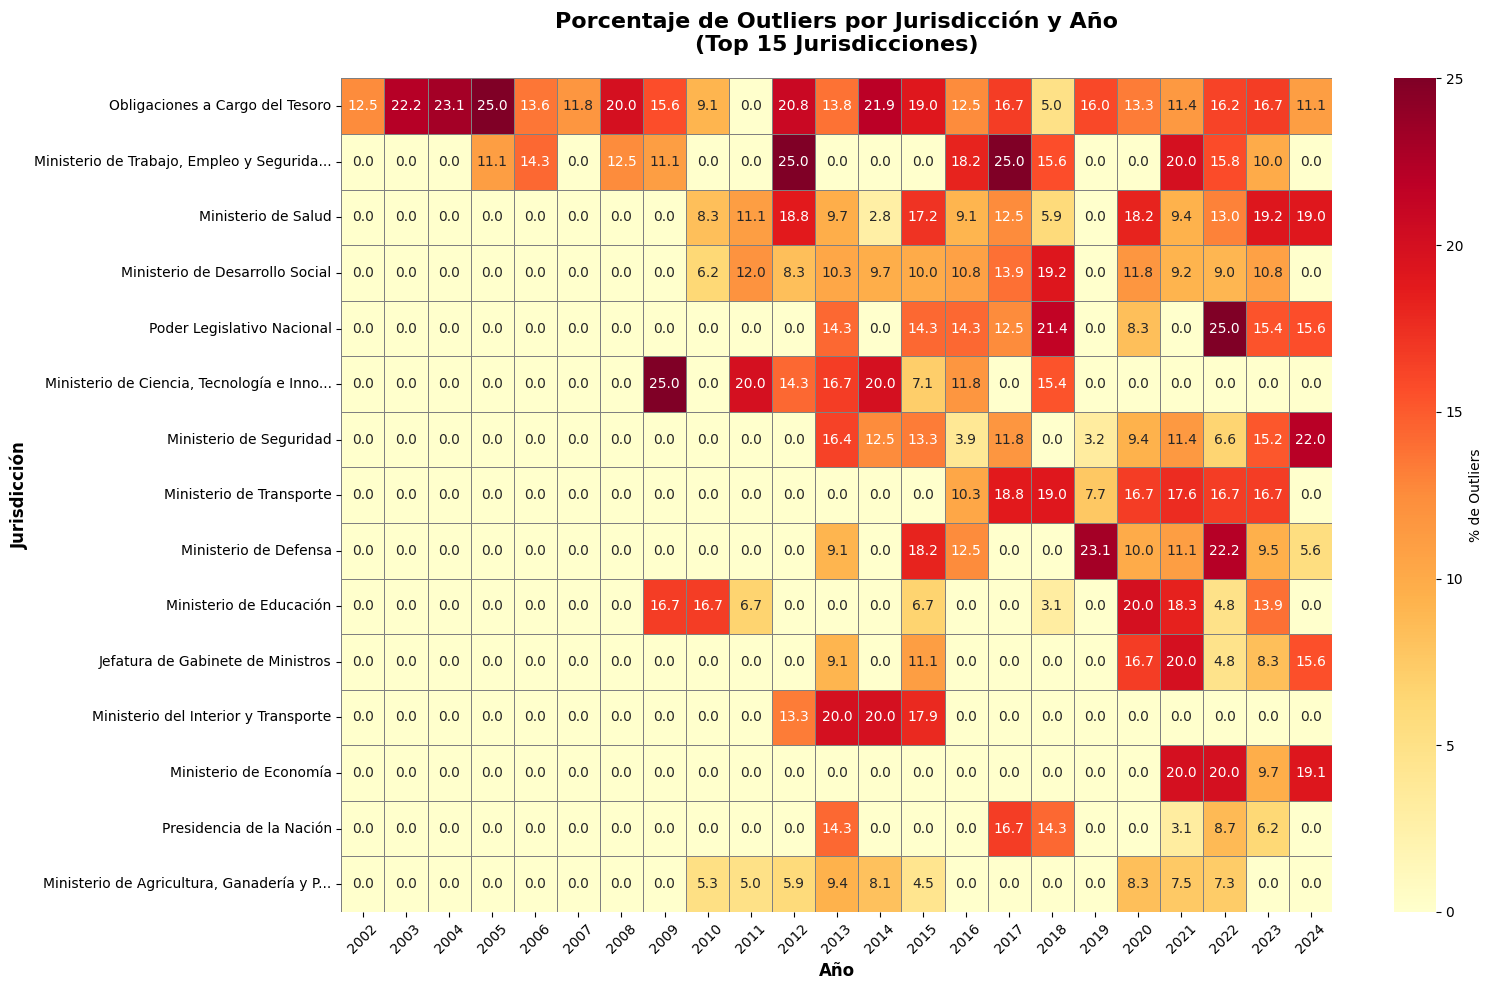

In [63]:
# Se crea un heat map (mapa de calor) para visualizar la presencia de outliers y facilitar el análisis
import matplotlib.pyplot as plt
import seaborn as sns

# HEATMAP: JURISDICCIONES VS AÑOS - % OUTLIERS
print("\n📊 GENERANDO HEATMAP DE OUTLIERS POR JURISDICCIÓN Y AÑO...")

# Preparar datos para el heatmap
outliers_juris_año = []

for año in sorted(df_con_fondos['anio'].unique()):
    df_año = df_con_fondos[df_con_fondos['anio'] == año]

    # Para cada jurisdicción en este año
    for jurisdiccion in df_año['jurisdiccion_desc'].unique():
        df_juris = df_año[df_año['jurisdiccion_desc'] == jurisdiccion]

        # Contar outliers en credito_devengado (columna principal)
        datos = df_juris[df_juris['credito_devengado'] > 0]['credito_devengado']

        if len(datos) > 5:  # Mínimo de registros
            Q1 = datos.quantile(0.25)
            Q3 = datos.quantile(0.75)
            IQR = Q3 - Q1
            limite_sup = Q3 + 1.5 * IQR
            limite_inf = Q1 - 1.5 * IQR

            outliers = datos[(datos < limite_inf) | (datos > limite_sup)]
            pct_outliers = (len(outliers) / len(datos)) * 100

            outliers_juris_año.append({
                'año': año,
                'jurisdiccion': jurisdiccion,
                'pct_outliers': pct_outliers,
                'total_registros': len(datos)
            })

# Crear DataFrame
df_juris_outliers = pd.DataFrame(outliers_juris_año)

# Crear tabla pivoteada para heatmap
tabla_heatmap = df_juris_outliers.pivot_table(
    index='jurisdiccion',
    columns='año',
    values='pct_outliers',
    aggfunc='mean'
).fillna(0)

# Seleccionar top 15 jurisdicciones con más outliers en promedio
top_jurisdicciones = tabla_heatmap.mean(axis=1).nlargest(15).index
tabla_heatmap_top = tabla_heatmap.loc[top_jurisdicciones]

# Acortar nombres de jurisdicciones
tabla_heatmap_top.index = [j[:40] + "..." if len(j) > 40 else j for j in tabla_heatmap_top.index]

# Crear heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    tabla_heatmap_top,
    annot=True,  # Mostrar valores
    fmt='.1f',   # Formato con 1 decimal
    cmap='YlOrRd',  # Escala de colores (amarillo a rojo)
    cbar_kws={'label': '% de Outliers'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Porcentaje de Outliers por Jurisdicción y Año\n(Top 15 Jurisdicciones)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Año', fontsize=12, fontweight='bold')
plt.ylabel('Jurisdicción', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Análisis de la distribución de los datos para evaluación de outliers

Antes de interpretar los valores atípicos (*outliers*), es importante verificar la **distribución estadística** de las variables presupuestarias.  Esto, debido a que en los conjuntos de datos que siguen una **distribución normal**, se espera que los valores extremos sean poco frecuentes. En ese caso, se utiliza como referencia la **regla del 1.5 × IQR (rango intercuartil)** o el criterio de **±3 desviaciones estándar** para identificar los outliers.

Bajo estas condiciones, el porcentaje de observaciones atípicas suele ser muy bajo (alrededor del **0,7% del total**).  
Sin embargo, este umbral solo es válido si los datos efectivamente presentan una forma aproximadamente normal o simétrica.

Por ello, antes de aplicar o interpretar este benchmark, se analizará la **forma de la distribución** de las variables presupuestarias (crédito presupuestado, vigente, devengado y pagado) para determinar si se ajustan a una distribución normal o si presentan **sesgo y dispersión estructural** típicos de los datos fiscales.

In [64]:
# ANÁLISIS DE DISTRIBUCIÓN DE LOS DATOS
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, kstest

print("📊 ANÁLISIS DE DISTRIBUCIÓN DE DATOS")
print("="*100)

# Analizar distribución de las columnas de crédito
for col in columnas_creditos:
    print(f"{'='*100}")
    print(f"📌 ANÁLISIS DE: {col.upper()}")
    print(f"{'='*100}")

    # Filtrar datos válidos (> 0)
    datos = df_con_fondos[df_con_fondos[col] > 0][col].dropna()

    if len(datos) > 100:  # Necesitamos suficientes datos

        # 1. ESTADÍSTICAS DESCRIPTIVAS
        print(f"\n📊 Estadísticas descriptivas:")
        print(f"   Tamaño muestra: {len(datos):,}")
        print(f"   Media: ${datos.mean():,.2f}")
        print(f"   Mediana: ${datos.median():,.2f}")
        print(f"   Desv. Estándar: ${datos.std():,.2f}")
        print(f"   Asimetría (Skewness): {datos.skew():.2f}")
        print(f"   Curtosis (Kurtosis): {datos.kurtosis():.2f}")

        # 2. INTERPRETACIÓN DE ASIMETRÍA Y CURTOSIS
        print(f"\n🔍 Interpretación:")
        skew = datos.skew()
        kurt = datos.kurtosis()

        if abs(skew) < 0.5:
            print(f"   • Asimetría: Distribución SIMÉTRICA (|{skew:.2f}| < 0.5)")
        elif abs(skew) < 1:
            print(f"   • Asimetría: Moderadamente asimétrica ({skew:.2f})")
        else:
            sesgo = "positiva (cola derecha larga)" if skew > 0 else "negativa (cola izquierda larga)"
            print(f"   • Asimetría: ALTAMENTE ASIMÉTRICA {sesgo} ({skew:.2f})")

        if abs(kurt) < 3:
            print(f"   • Curtosis: Distribución platicúrtica (colas ligeras, {kurt:.2f})")
        elif abs(kurt) < 7:
            print(f"   • Curtosis: Curtosis moderada ({kurt:.2f})")
        else:
            print(f"   • Curtosis: Distribución leptocúrtica (colas pesadas, {kurt:.2f})")

        # 3. TEST DE NORMALIDAD
        print(f"\n🧪 Tests de Normalidad:")

        # Shapiro-Wilk (para muestras < 5000)
        if len(datos) < 5000:
            stat_shapiro, p_shapiro = shapiro(datos.sample(min(5000, len(datos)), random_state=42))
            print(f"   • Shapiro-Wilk: p-value = {p_shapiro:.6f}")
            if p_shapiro > 0.05:
                print(f"     → NO se rechaza normalidad (p > 0.05)")
            else:
                print(f"     → Se rechaza normalidad (p < 0.05) ✓")

        # D'Agostino-Pearson (para muestras grandes)
        if len(datos) > 20:
            stat_dagostino, p_dagostino = normaltest(datos)
            print(f"   • D'Agostino-Pearson: p-value = {p_dagostino:.6f}")
            if p_dagostino > 0.05:
                print(f"     → NO se rechaza normalidad (p > 0.05)")
            else:
                print(f"     → Se rechaza normalidad (p < 0.05) ✓")

        # 4. RATIO MEDIA/MEDIANA (indicador simple de asimetría)
        ratio = datos.mean() / datos.median()
        print(f"\n📏 Ratio Media/Mediana: {ratio:.2f}")
        if 0.9 <= ratio <= 1.1:
            print(f"   → Distribución aproximadamente SIMÉTRICA")
        else:
            print(f"   → Distribución ASIMÉTRICA")

📊 ANÁLISIS DE DISTRIBUCIÓN DE DATOS
📌 ANÁLISIS DE: CREDITO_PRESUPUESTADO

📊 Estadísticas descriptivas:
   Tamaño muestra: 27,475
   Media: $397.43
   Mediana: $6.00
   Desv. Estándar: $5,705.65
   Asimetría (Skewness): 31.07
   Curtosis (Kurtosis): 1178.00

🔍 Interpretación:
   • Asimetría: ALTAMENTE ASIMÉTRICA positiva (cola derecha larga) (31.07)
   • Curtosis: Distribución leptocúrtica (colas pesadas, 1178.00)

🧪 Tests de Normalidad:
   • D'Agostino-Pearson: p-value = 0.000000
     → Se rechaza normalidad (p < 0.05) ✓

📏 Ratio Media/Mediana: 66.24
   → Distribución ASIMÉTRICA
📌 ANÁLISIS DE: CREDITO_VIGENTE

📊 Estadísticas descriptivas:
   Tamaño muestra: 26,153
   Media: $538.58
   Mediana: $9.00
   Desv. Estándar: $12,354.55
   Asimetría (Skewness): 68.20
   Curtosis (Kurtosis): 5961.68

🔍 Interpretación:
   • Asimetría: ALTAMENTE ASIMÉTRICA positiva (cola derecha larga) (68.20)
   • Curtosis: Distribución leptocúrtica (colas pesadas, 5961.68)

🧪 Tests de Normalidad:
   • D'Agostin

#### Tratamiento de outliers

Se identificó un promedio general de **15,17%** de valores atípicos considerando las columnas de crédito presupuestado, vigente, devengado y pagado.  
Si bien este porcentaje supera los límites esperados para datos con distribución normal (regla del 1.5 × IQR o ±3 desviaciones estándar), **no se considera anómalo en el contexto del análisis presupuestario**, sino que reflejan las características estructurales del presupuesto nacional, afectado por la nominalidad. Por esto, **se decidió mantener los outliers en el conjunto de datos sin aplicarle transformación alguna**.

👉 **Justificación estadística**:  
- Los datos presupuestarios presentan una distribución extremadamente asimétrica (skewness 25-68) con colas pesadas (curtosis 830-5,961), rechazando contundentemente la hipótesis de normalidad (p < 0.001).
- El método IQR (1.5 × IQR) NO asume distribución normal, por lo que es apropiado para este análisis (el método de considerar ±3σ sería inapropiado ya que sí requiere normalidad).
- Los outliers detectados (15.17%) son consistentes con distribuciones muy asimétricas

👉 **Justificación según la materia u objeto de estudio**:
- Los outliers detectados corresponden a **jurisdicciones estructuralmente grandes** son valores legítimos. Existen diferencias estructurales entre jurisdicciones en cuanto a volumen y naturaleza del gasto (sus registros aparecerán sistemáticamente como outliers).
- Los valores extremos pueden reflejar **hechos económicos relevantes** o decisiones de política pública, y no errores (transferencias, reasignaciones o políticas específicas de gran magnitud).
- Eliminarlos sesgaría el análisis hacia partidas pequeñas.

El hecho de que *Obligaciones a Cargo del Tesoro (Jursidicción 91)* (jurisdicción que asigna créditos a empresas públicas, a provincias y municipios, al sector externo, entre otros,por lo que incluye trasnferencias discrecionales y voluminosas) y determinados Ministerios (que ejecutan programas grandes o inversiones extraordinarias) sean los que más outliers presentan, confirma la **concentración estrcuctural del gasto** en aquellas categorías programáticas con alta ejecución presupuestaria.

In [65]:
# Guardado de la base de datos a trabajar
# NOTA: Se armó el código para exportar por si es necesario, pero los archivos son muy grandes, así que se deja sin ejecutar

# Se crea una carpeta para archivos de salida
import os
os.makedirs("data_procesada", exist_ok=True)

# Se guarda el df sin valores nulos (NaN)
# df_presupuesto_anual_limpio.to_csv("data_procesada/presupuesto_limpio.csv", index=False)
# print("✅ Versión limpia de NaN guardada")

# Se guarda el df simplificado (que contienen valores monetarios positivos en alguna de las columnas de crédito, es decir, sin valores = 0)
# df_con_fondos.to_csv("data_procesada/presupuesto_simplificado.csv", index=False)
# print("✅ Versión simplificada (sin valores=0) guardada")

# B. Datos variables macroeconómicas

## TIPO DE CAMBIO - DESCARGA DESDE LA API DEL BCRA

In [66]:
# DESCARGA DE TIPO DE CAMBIO DESDE API DEL BCRA
# https://www.bcra.gob.ar/Catalogo/apis.asp?fileName=estadisticascambiarias-v1&sectionName=Estad%EDsticas%20Cambiarias

import requests
import pandas as pd
import time
import urllib3

# Se deshabilitan los warnings de SSL (para evitar error)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

print("DESCARGA DE TIPOS DE CAMBIO - API BCRA")
print("="*100)

# URL base de la API
base_url = "https://api.bcra.gob.ar/estadisticascambiarias/v1.0"

# ===================================================================================
# PASO 1: OBTENER MAESTRO DE DIVISAS
# ===================================================================================
print("\n📋 PASO 1: Obteniendo maestro de divisas...")

try:
    # SOLICITUD a la API de la lista de monedas

    response = requests.get(f"{base_url}/Maestros/Divisas", verify=False) # AGREGAR verify=False para deshabilitar la
                                                                          # verificación SSL (sino puede dar error)

    # Se verifica la respuesta sea exitosa (code=200)
    if response.status_code == 200:
        divisas = response.json()                          # Convierte la respuesta json a diccionario python (200, results)
        df_divisas = pd.DataFrame(divisas['results'])      # 'results' es el diccionario que da la API con la lista de monedas.
        print(f"✅ Divisas obtenidas: {len(df_divisas)}") # Se guarda la lista en un df.

        # Se muestran el catálogo de divisas
        print("\n📊 Listado de Divisas (últimas 10):")
        print(df_divisas.tail(10).to_string(index=False))

        # Se busca la moneda USD (Dólar estadounidense)
        usd = df_divisas[df_divisas['codigo'] == 'USD']
        if not usd.empty:
            print(f"\n✅ dólar encontrado: {usd['codigo'].values[0]},{usd['denominacion'].values[0]}")
            cod_usd = 'USD'
        else:
            print("\n⚠️  USD no encontrado en el maestro")
            cod_usd = None
    else:
        print(f"❌ Error al obtener maestro: {response.status_code}")
        cod_usd = None

except Exception as e:
    print(f"❌ Error de conexión: {e}")
    cod_usd = None


DESCARGA DE TIPOS DE CAMBIO - API BCRA

📋 PASO 1: Obteniendo maestro de divisas...
✅ Divisas obtenidas: 44

📊 Listado de Divisas (últimas 10):
codigo                    denominacion
   SGD               DOLAR DE SINGAPUR
   TRY                      LIRA TURCA
   USD                  DOLAR E.E.U.U.
   UYU                   PESO URUGUAYO
   VEB                       BOLIVARES
   VND DONG VIETNAM (c/1.000 unidades)
   XAG               PLATA - ONZA TROY
   XAU               ORO FINO (1 ONZA)
   XDR                             DEG
   ZAR                        RAND SUD

✅ dólar encontrado: USD,DOLAR E.E.U.U.


In [67]:
# ========================================================================================
# PASO 2: OBTENER COTIZACIONES POR AÑO
# ========================================================================================

# Se verifica que en el PASO 1 hayamos encontrado el código USD
if cod_usd:
    # Si cod_usd tiene valor (no es None), continuamos
    print(f"\n\n💵 PASO 2: Obteniendo cotizaciones de {cod_usd} por año...")
    print("="*100)

    # Se crea la lista que acumulará el resumen de cada año
    cotizaciones_anuales = []

    # Se arma el LOOP por año
    for anio in range(2001, 2025):    # range(2001, 2025) genera: 2001, 2002, 2003, ..., 2024 y NO incluye el 2025
        print(f"\n📅 Procesando año {anio}", end=" ") # end=" " para que no salte de línea

        # Se definen los rangos de fechas del año
        # Se crean parámetros de fechas de inicio y de fin (desde el 1 de enero hasta el 31 de diciembre, con formato "AAA-MM-DD")
        fecha_desde = f"{anio}-01-01"
        fecha_hasta = f"{anio}-12-31"

        # Se construye la URL completa con los parámetros:
          # - base_url: la dirección base de la API
          # - /Cotizaciones/{cod_usd}: endpoint para cotizaciones de USD
          # - ?fechadesde=... : parámetro de fecha inicio
          # - &fechahasta=... : parámetro de fecha fin

        url = f"{base_url}/Cotizaciones/{cod_usd}?fechadesde={fecha_desde}&fechahasta={fecha_hasta}"

        # URL generada: https://api.bcra.gob.ar/estadisticascambiarias/v1.0/Cotizaciones/USD?fechadesde=2022-01-01&fechahasta=2022-12-31

        # Se hace la solicitud a la API
        try:
            # Solicitud GET con verify=False para ignorar problemas de certificado SSL
            response = requests.get(url, verify=False)

            # Se verifica que la solicitud haya sido exitosa
            if response.status_code == 200:            # 200 = OK (solicitud exitosa)

                # Si lo es, se convierte la respuesta a un diccionario de python (response.json())
                data = response.json()

                # data ahora es un diccionario como este:
                # {
                #   "status": 200,
                #   "metadata": {...},
                #   "results": [
                #       {"fecha": "2022-01-03", "detalle": [...]},
                #       {"fecha": "2022-01-04", "detalle": [...]},
                #       ...
                #   ]
                # }

                # Si data['results'] (lista de cotizaciones) NO está vacío, se procesa
                if data['results']:

                    # Se extraen las cotizaciones con un FOR
                    cotizaciones = []      # Lista temporal para las cotizaciones del año

                    # Se recorre cada resultado (cada día con cotización)
                    for resultado in data['results']:
                        # resultado es un diccionario:       (esto se explica en el manual de APIs publicada por el BCRA)
                        # {
                        #   "fecha": "2022-01-03",
                        #   "detalle": [
                        #       {
                        #           "codigoMoneda": "USD",
                        #           "descripcion": "DOLAR ESTADOUNIDENSE",
                        #           "tipoPase": 105.50,
                        #           "tipoCotizacion": 106.00
                        #       }
                        #   ]
                        # }

                        # Se extrae la fecha
                        fecha = resultado['fecha']

                        # Se recorre cada detalle (normalmente hay 1 por fecha)
                        for detalle in resultado['detalle']:      # detalle es un diccionario con los valores de cotización

                            # Se crea un diccionario limpio con toda la info
                            cotizaciones.append({
                                'fecha': fecha,
                                'anio': anio,                                 # Se agrega el año para referencia
                                'codigo_moneda': detalle['codigoMoneda'],
                                'descripcion': detalle['descripcion'],
                                'tipo_pase': detalle['tipoPase'],
                                'tipo_cotizacion': detalle['tipoCotizacion']
                            })

                    # Se convierte la lista de diccionarios a DATAFRAME
                    df_tc_año = pd.DataFrame(cotizaciones)

                    # df_tc_año ahora tiene este formato:
                    #         fecha   año codigo_moneda  tipo_pase  tipo_cotizacion
                    # 0  2022-01-03  2022           USD     105.50           106.00
                    # 1  2022-01-04  2022           USD     106.20           106.75
                    # 2  2022-01-05  2022           USD     107.10           107.80
                    # ...

                    # Se calcula el PROMEDIO ANUAL (porque los datos presupuestarios que extraje en el punto 1 son anuales)
                    tc_promedio_pase = df_tc_año['tipo_pase'].mean()
                    tc_promedio_cotizacion = df_tc_año['tipo_cotizacion'].mean()

                    # Se guarda el resumen del año (y se agrega un diccionario con el resumen a la lista principal)
                    cotizaciones_anuales.append({
                        'anio': anio,
                        'registros': len(df_tc_año),  # Cantidad de cotizaciones
                        'tipo_cambio_pase_promedio': tc_promedio_pase,
                        'tipo_cambio_cotizacion_promedio': tc_promedio_cotizacion
                    })


                else:
                    # Si data['results'] está vacío
                    print(f"   ⚠️  Sin datos para {anio}")

            else:
                # Si el status_code NO es 200
                print(f"   ❌ Error HTTP {response.status_code}")

            # ESPERA ENTRE SOLICITUDES
            # Se indica esperar 0.5 segundos antes de pedir el siguiente año para evitar saturar la API del BCRA (rate limiting)
            time.sleep(0.5)

        except Exception as e:
            # Si hay cualquier error (timeout, conexión, etc.)
            print(f"   ❌ Error: {e}")

    # FIN DEL LOOP - Se procesaron todos los años (2002-2024): cotizaciones_anuales tiene el resumen de cada año.
    if cotizaciones_anuales:
        # Se crea un DataFrame con el resumen de todos los años
        df_tc_promedio_anual = pd.DataFrame(cotizaciones_anuales)

        print("\n\n📊 TIPO DE CAMBIO USD - PROMEDIO ANUAL (2002-2024)")
        print("="*100)
        print(f"   Total años procesados: {len(df_tc_promedio_anual)}")
        print(df_tc_promedio_anual.to_string(index=False))

    else:
        print("\n⚠️  No se obtuvieron cotizaciones")

else:
    # Si cod_usd es None (no se encontró USD en el PASO 1)
    print("\n⚠️  No se puede continuar sin el código USD")



💵 PASO 2: Obteniendo cotizaciones de USD por año...

📅 Procesando año 2001 
📅 Procesando año 2002 
📅 Procesando año 2003 
📅 Procesando año 2004 
📅 Procesando año 2005 
📅 Procesando año 2006 
📅 Procesando año 2007 
📅 Procesando año 2008 
📅 Procesando año 2009 
📅 Procesando año 2010 
📅 Procesando año 2011 
📅 Procesando año 2012 
📅 Procesando año 2013 
📅 Procesando año 2014 
📅 Procesando año 2015 
📅 Procesando año 2016 
📅 Procesando año 2017 
📅 Procesando año 2018 
📅 Procesando año 2019 
📅 Procesando año 2020 
📅 Procesando año 2021 
📅 Procesando año 2022 
📅 Procesando año 2023 
📅 Procesando año 2024 

📊 TIPO DE CAMBIO USD - PROMEDIO ANUAL (2002-2024)
   Total años procesados: 24
 anio  registros  tipo_cambio_pase_promedio  tipo_cambio_cotizacion_promedio
 2001        214                        0.0                         1.000000
 2002        231                        0.0                         3.222468
 2003        249                        0.0                         2.948976
 2004

In [68]:
# ====================================================================
# PASO 3: ENRIQUECIMIENTO DEL DATASET DEL TIPO DE CAMBIO
# ====================================================================

# Cálculo de variaciones 
# Ordenar por año (para asegurarnos estan en orden cronológico)
df_tc_promedio_anual = df_tc_promedio_anual.sort_values('anio').reset_index(drop=True)
# Calcular variación porcentual año a año
df_tc_promedio_anual['tc_variacion_pct'] = df_tc_promedio_anual['tipo_cambio_cotizacion_promedio'].pct_change() * 100
# Calcular variación absoluta
df_tc_promedio_anual['tc_variacion_absoluta'] = df_tc_promedio_anual['tipo_cambio_cotizacion_promedio'].diff()

print("\n👉 Se agregan columnas con la variación porcentual y absoluta del TC:")
print(f"\n⚠️  Nota: El año {df_tc_promedio_anual['anio'].min()} tiene NaN en variación (no hay año anterior)")

# Se agrega una medida de volatilidad del TC (rolling de3 años)
print("\n👉 Se agrega columna de volatilidad del TC:")
print('Se calcula una ventana móvil de 3 años y se mide el desvío standard entre los valores de la ventana (dispersión).')
df_tc_promedio_anual['tc_volatilidad_3años'] = df_tc_promedio_anual['tc_variacion_pct'].rolling(window=3).std()

# Se agrega una clasificación de la variación porcentual del TC (devaluación - estable - apreciación) según un umbral (MEDIANA)

# Filtrar solo 2002-2024 para las estadísticas
df_tc_periodo = df_tc_promedio_anual[df_tc_promedio_anual['anio'] >= 2002].copy()

# Se calcula el umbral para clasificar la variación porcentual del TC --> Mediana
""" El promedio de variación está afectado por los valores extremos y puede llevar a catalogar muchos años como "normales". 
Por eso se toma la MEDIANA, que es el valor central del conjunto de datos."""
umbral_var_tc = df_tc_periodo['tc_variacion_pct'].median()

print("\n👉 Se agrega columna de clasificación de la variación del TC (devaluación - estable - apreciación) a partir de un umbral (MEDIANA).")
print('Se toma la MEDIANA (valor central) porque el promedio de variación es afectado por los valores extremos y puede catalogar muchos años como "normales')
print(f"En la mitad de los años analizados, el TC varió: {umbral_var_tc:.2f}%")

# se aplica el umbral y se crea la columna de clasificación
df_tc_promedio_anual['tc__var_clasificacion'] = df_tc_promedio_anual['tc_variacion_pct'].apply(
    lambda x: 'Devaluación' if x > umbral_var_tc else ('Estable' if -umbral_var_tc <= x <= umbral_var_tc else 'Apreciación') if pd.notna(x) else 'Sin dato'
)

# Se actualiza df_tc_periodo con todas las columnas nuevas
df_tc_periodo = df_tc_promedio_anual[df_tc_promedio_anual['anio'] >= 2002].copy()

# Vemos los datos históricos:
print(f"\n📊 Estadísticas de la variación del TC:")
print(f"   Promedio: {df_tc_periodo['tc_variacion_pct'].mean():.1f}%")
print(f"   Mediana: {df_tc_periodo['tc_variacion_pct'].median():.1f}%")
print(f"   Mínimo: {df_tc_periodo['tc_variacion_pct'].min():.2f}% en {df_tc_periodo.loc[df_tc_periodo['tc_variacion_pct'].idxmin(), 'anio']}")
print(f"   Máximo: {df_tc_periodo['tc_variacion_pct'].max():.2f}% en {df_tc_periodo.loc[df_tc_periodo['tc_variacion_pct'].idxmax(), 'anio']}")

# Resultados de la clasificación
print("\n📊 Resultados de la clasificación de la variación del TC (2002-2024):")
print('La clasificación (devaluación - estable - apreciación) se establece a partir de un umbral (MEDIANA).')
print('\nParámetros: "Estable si la variación del TC = igual a la del umbral')
print('\n            "Devaluación si la variación del TC > a la del umbral')
print('\n            "Apreciación si la variación del TC < a la del umbral')
print('📊 Resultados de la clasificación: ', df_tc_periodo['tc__var_clasificacion'].value_counts())

# Resultados de la volatilidad
print('\n📊 Resultados de la volatilidad de la variación del TC: ')
print(f"   Mínimo: {df_tc_periodo['tc_volatilidad_3años'].min():.2f}% en {df_tc_periodo.loc[df_tc_periodo['tc_volatilidad_3años'].idxmin(), 'anio']}")
print(f"   Máximo: {df_tc_periodo['tc_volatilidad_3años'].max():.2f}% en {df_tc_periodo.loc[df_tc_periodo['tc_volatilidad_3años'].idxmax(), 'anio']}")


👉 Se agregan columnas con la variación porcentual y absoluta del TC:

⚠️  Nota: El año 2001 tiene NaN en variación (no hay año anterior)

👉 Se agrega columna de volatilidad del TC:
Se calcula una ventana móvil de 3 años y se mide el desvío standard entre los valores de la ventana (dispersión).

👉 Se agrega columna de clasificación de la variación del TC (devaluación - estable - apreciación) a partir de un umbral (MEDIANA).
Se toma la MEDIANA (valor central) porque el promedio de variación es afectado por los valores extremos y puede catalogar muchos años como "normales
En la mitad de los años analizados, el TC varió: 17.95%

📊 Estadísticas de la variación del TC:
   Promedio: 43.9%
   Mediana: 18.0%
   Mínimo: -8.49% en 2003
   Máximo: 222.25% en 2002

📊 Resultados de la clasificación de la variación del TC (2002-2024):
La clasificación (devaluación - estable - apreciación) se establece a partir de un umbral (MEDIANA).

Parámetros: "Estable si la variación del TC = igual a la del umbr

In [69]:
df_tc_promedio_anual.head()

,anio,registros,tipo_cambio_pase_promedio,tipo_cambio_cotizacion_promedio,tc_variacion_pct,tc_variacion_absoluta,tc_volatilidad_3años,tc__var_clasificacion
0,2001,214,0.0,1.000000,NaN,NaN,NaN,Sin dato
1,2002,231,0.0,3.222468,222.246753,2.222468,NaN,Devaluación
2,2003,249,0.0,2.948976,-8.487025,-0.273492,NaN,Estable
3,2004,252,0.0,2.942115,-0.232651,-0.006861,130.896458,Estable
4,2005,253,0.0,2.923316,-0.638958,-0.018799,4.652812,Estable


In [70]:
# ====================================================================
# PASO 4: SE GUARDA EL DATAFRAME
# ====================================================================
print("📊 Dataset de TC:")
print(df_tc_promedio_anual.head())


# Esto guardaría el DataFrame en un archivo CSV
# df_tc_promedio_anual.to_csv("data_procesada/tipo_cambio_usd_anual.csv", index=False)

📊 Dataset de TC:
   anio  registros  tipo_cambio_pase_promedio  \
0  2001        214                        0.0   
1  2002        231                        0.0   
2  2003        249                        0.0   
3  2004        252                        0.0   
4  2005        253                        0.0   

   tipo_cambio_cotizacion_promedio  tc_variacion_pct  tc_variacion_absoluta  \
0                         1.000000               NaN                    NaN   
1                         3.222468        222.246753               2.222468   
2                         2.948976         -8.487025              -0.273492   
3                         2.942115         -0.232651              -0.006861   
4                         2.923316         -0.638958              -0.018799   

   tc_volatilidad_3años tc__var_clasificacion  
0                   NaN              Sin dato  
1                   NaN           Devaluación  
2                   NaN               Estable  
3            130.8964

In [71]:
df_tc_promedio_anual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   anio                             24 non-null     int64  
 1   registros                        24 non-null     int64  
 2   tipo_cambio_pase_promedio        24 non-null     float64
 3   tipo_cambio_cotizacion_promedio  24 non-null     float64
 4   tc_variacion_pct                 23 non-null     float64
 5   tc_variacion_absoluta            23 non-null     float64
 6   tc_volatilidad_3años             21 non-null     float64
 7   tc__var_clasificacion            24 non-null     object 
dtypes: float64(5), int64(2), object(1)
memory usage: 1.6+ KB


## INDICE DE PRECIOS AL CONSUMIDOR (IPC) - CARGA DE DATASET
Se utiliza la serie de datos publicada por el BIS (Bank for International Settlements), que construye sus propias series empalmando diferentes fuentes oficiales con metodología uniforme.  
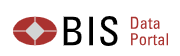 La serie mensual se descargó del portal de datos del BIS: https://data.bis.org/topics/CPI/BIS,WS_LONG_CPI,1.0/M.AR.628.

In [72]:
# Carga archivo de IPC del BIS
ruta_archivo_ipc = 'bis_ipc.xlsx'

df_ipc_bis = pd.read_excel(ruta_archivo_ipc, sheet_name='timeseries observations')

print(f"Datos cargados: {df_ipc_bis.shape}")
print(f"Columnas: {df_ipc_bis.columns.tolist()}")

# Simplificar nombres de columnas (quitar el prefijo antes de ":")
df_ipc_bis.columns = df_ipc_bis.columns.str.split(':').str[-1]
print(f"Columnas con nombre simplificado: {df_ipc_bis.columns.tolist()}")

# Seleccionar solo las columnas que necesitamos
df_ipc = df_ipc_bis[['Period', 'Value']].copy()
df_ipc.columns = ['fecha', 'ipc_indice']

# Convertir fecha a formato datetime
df_ipc['fecha'] = pd.to_datetime(df_ipc['fecha'])

# Extraer año y mes
df_ipc['anio'] = df_ipc['fecha'].dt.year
df_ipc['mes'] = df_ipc['fecha'].dt.month

# Ordenar por fecha
df_ipc = df_ipc.sort_values('fecha').reset_index(drop=True)

print(f"\nDatos limpios: {len(df_ipc)} registros")
print(f"Período completo: {df_ipc['anio'].min()} - {df_ipc['anio'].max()}")

# Mostrar primeras filas
df_ipc.head()

Datos cargados: (993, 12)
Columnas: ['DATAFLOW_ID:Dataflow ID', 'KEY:Timeseries Key', 'FREQ:Frequency', 'REF_AREA:Reference area', 'UNIT_MEASURE:Unit of measure', 'Unit', 'Unit multiplier', 'TIME_PERIOD:Period', 'OBS_CONF:Confidentiality', 'OBS_PRE_BREAK:Pre-break value', 'OBS_STATUS:Status', 'OBS_VALUE:Value']
Columnas con nombre simplificado: ['Dataflow ID', 'Timeseries Key', 'Frequency', 'Reference area', 'Unit of measure', 'Unit', 'Unit multiplier', 'Period', 'Confidentiality', 'Pre-break value', 'Status', 'Value']

Datos limpios: 993 registros
Período completo: 1943 - 2025


,fecha,ipc_indice,anio,mes
0,1943-01-31,8.428268e-13,1943,1
1,1943-02-28,8.428268e-13,1943,2
2,1943-03-31,8.428268e-13,1943,3
3,1943-04-30,8.428268e-13,1943,4
4,1943-05-31,8.428268e-13,1943,5


In [73]:
# FILTRAR PERÍODO DE ANÁLISIS (2002-2024)

df_ipc_periodo = df_ipc[
    (df_ipc['anio'] >= 2001) & 
    (df_ipc['anio'] <= 2024)
].copy()

print(f"\nDatos filtrados 2002-2024: {len(df_ipc_periodo)} registros")
print(f"Años con datos: {sorted(df_ipc_periodo['anio'].unique())}")

# Mostrar primeras filas
df_ipc_periodo


Datos filtrados 2002-2024: 288 registros
Años con datos: [np.int32(2001), np.int32(2002), np.int32(2003), np.int32(2004), np.int32(2005), np.int32(2006), np.int32(2007), np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


,fecha,ipc_indice,anio,mes
696,2001-01-31,39.937974,2001,1
697,2001-02-28,39.846999,2001,2
698,2001-03-31,39.922921,2001,3
699,2001-04-30,40.189785,2001,4
700,2001-05-31,40.215795,2001,5
...,...,...,...,...
979,2024-08-31,18768.724973,2024,8
980,2024-09-30,19466.499475,2024,9
981,2024-10-31,20015.506600,2024,10
982,2024-11-30,20536.176047,2024,11


In [74]:
# CALCULAR INDICADORES ANUALES DEL IPC
# -----------------------------------------------------------------------------
# Promedio anual del índice
ipc_prom_anual = df_ipc_periodo.groupby('anio').agg({
    'ipc_indice': 'mean'
}).reset_index()
ipc_prom_anual.columns = ['anio', 'ipc_promedio_anual']

# Inflación anual (variación % del promedio)
ipc_prom_anual['inflacion_anual_pct'] = ipc_prom_anual['ipc_promedio_anual'].pct_change() * 100

# Índice en diciembre (para inflación interanual entre puntas)
ipc_diciembre = df_ipc_periodo[df_ipc_periodo['mes'] == 12].copy()
ipc_diciembre = ipc_diciembre[['anio', 'ipc_indice']].rename(
    columns={'ipc_indice': 'ipc_diciembre'}
)

# Inflación interanual (diciembre a diciembre)
ipc_diciembre['inflacion_interanual_pct'] = ipc_diciembre['ipc_diciembre'].pct_change() * 100


# # Se combinan ambos indicadores
df_ipc_final = ipc_prom_anual.merge(ipc_diciembre, on='anio', how='left')
df_ipc_final['anio'] = df_ipc_final['anio'].astype('int64')

# Variación absoluta del promedio anual (en puntos porcentuales)
df_ipc_final['ipc_var_absoluta'] = df_ipc_final['ipc_promedio_anual'].diff()

# Volatilidad (desviación estándar mensual por año)
volatilidad_ipc = df_ipc_periodo.groupby('anio')['ipc_indice'].std().reset_index()
volatilidad_ipc.columns = ['anio', 'ipc_volatilidad_anual']
df_ipc_final = df_ipc_final.merge(volatilidad_ipc, on='anio', how='left')

# Media móvil de inflación
df_ipc_final['inflacion_mv3'] = df_ipc_final['inflacion_anual_pct'].rolling(3).mean()

# Categorías de inflación
df_ipc_final['categoria_inflacion'] = pd.cut(
    df_ipc_final['inflacion_anual_pct'],
    bins=[0, 10, 30, 50, 1000],
    labels=['Baja', 'Moderada', 'Alta', 'Muy Alta']
)

# RESUMEN ESTADÍSTICO
# -----------------------------------------------------------------------------

print("\n" + "="*80)
print("RESUMEN ESTADÍSTICO - INFLACIÓN ANUAL (2002-2024)")
print("(Nota: se toma desde 2001 para obtener las variaciones anuales en 2002)")
print("="*80)
print(f"Promedio: {df_ipc_final['inflacion_anual_pct'].mean():.2f}%")
print(f"Mínimo: {df_ipc_final['inflacion_anual_pct'].min():.2f}% (año {df_ipc_final.loc[df_ipc_final['inflacion_anual_pct'].idxmin(), 'anio']:.0f})")
print(f"Máximo: {df_ipc_final['inflacion_anual_pct'].max():.2f}% (año {df_ipc_final.loc[df_ipc_final['inflacion_anual_pct'].idxmax(), 'anio']:.0f})")
print(f"Desviación estándar: {df_ipc_final['inflacion_anual_pct'].std():.2f}%")

# DESCRIPCIÓN DE VARIABLES
# -----------------------------------------------------------------------------

print("\n" + "="*80)
print("DESCRIPCIÓN DE VARIABLES CALCULADAS")
print("="*80)
print("""
1. ipc_prome_anual: Promedio del índice IPC durante el año
2. inflacion_anual_pct: Variación % del promedio anual vs año anterior
3. ipc_diciembre: Valor del índice en diciembre
4. ipc_var_absoluta: Cambio absoluto en el índice promedio
5. ipc_volatilidad_anual: Desviación estándar mensual dentro del año
6. ipc_rango_anual: Diferencia entre valor máximo y mínimo del año
7. inflacion_ma3: Media móvil de 3 años de la inflación anual (suaviza 
   fluctuaciones y muestra la tendencia de largo plazo)
9. categoria_inflacion: Clasificación cualitativa de la inflación 
    (Baja: 0-10%, Moderada: 10-30%, Alta: 30-50%, Muy Alta: >50%)
""")

# Dataframe creado
df_ipc_final


RESUMEN ESTADÍSTICO - INFLACIÓN ANUAL (2002-2024)
(Nota: se toma desde 2001 para obtener las variaciones anuales en 2002)
Promedio: 36.00%
Mínimo: 4.42% (año 2004)
Máximo: 223.00% (año 2024)
Desviación estándar: 50.05%

DESCRIPCIÓN DE VARIABLES CALCULADAS

1. ipc_prome_anual: Promedio del índice IPC durante el año
2. inflacion_anual_pct: Variación % del promedio anual vs año anterior
3. ipc_diciembre: Valor del índice en diciembre
4. ipc_var_absoluta: Cambio absoluto en el índice promedio
5. ipc_volatilidad_anual: Desviación estándar mensual dentro del año
6. ipc_rango_anual: Diferencia entre valor máximo y mínimo del año
7. inflacion_ma3: Media móvil de 3 años de la inflación anual (suaviza 
   fluctuaciones y muestra la tendencia de largo plazo)
9. categoria_inflacion: Clasificación cualitativa de la inflación 
    (Baja: 0-10%, Moderada: 10-30%, Alta: 30-50%, Muy Alta: >50%)



,anio,ipc_promedio_anual,inflacion_anual_pct,ipc_diciembre,inflacion_interanual_pct,ipc_var_absoluta,ipc_volatilidad_anual,inflacion_mv3,categoria_inflacion
0,2001,39.763772,NaN,39.288719,NaN,NaN,0.306205,NaN,NaN
1,2002,50.050081,25.868546,55.376083,40.946524,10.286310,5.687039,NaN,Moderada
2,2003,56.778386,13.443143,57.403419,3.661031,6.728304,0.365032,NaN,Moderada
3,2004,59.285711,4.415986,60.903173,6.096770,2.507326,1.110776,14.575892,Baja
4,2005,65.002276,9.642398,68.411918,12.328987,5.716564,2.063096,9.167176,Baja
5,2006,72.085210,10.896440,75.142986,9.839028,7.082934,1.866720,8.318275,Moderada
6,2007,78.452907,8.833570,81.510374,8.473696,6.367697,1.761842,9.790803,Baja
7,2008,85.187599,8.584376,87.409572,7.237358,6.734692,1.712827,9.438129,Baja
8,2009,90.529436,6.270674,94.135330,7.694533,5.341837,2.028424,7.896206,Baja
9,2010,100.000000,10.461309,104.417817,10.923091,9.470564,2.926113,8.438786,Moderada


# C. Unión de los datos (datos presupuestarios sin NaN y sin valores = 0 + tipo de cambio)

Se analiza el subconjunto de partidas presupuestarias con asignación y ejecución positiva (valores distintos a 0), ya que el objetivo es modelar la eficiencia del proceso de ejecución (ratio ECP), no la decisión binaria de ejecutar o no ejecutar. 

Las partidas con crédito presupuestado igual a cero representan categorías programáticas creadas pero no autorizadas, presupuestadas o ejecutadas, y no aportan información sobre la relación entre planificación y ejecución efectiva.

Para el objetivo de modelar el ratio CD/CP, descartamos estos registros porque:
- el modelo tendrá un sesgo masivo a valores = 0
- los registros con valores = o no presentan información, son indefinidos y por tanto no permiten modelar el ratio CD/CP
- generan ruido y distorsionan las relaciones entre variables

In [75]:
# Se incorpora el tipo de cambio al dataset de Presupuesto

print("\nINCORPORACION DEL TIPO DE CAMBIO Y DEL IPC AL DATASET DE PRESUPUESTO")
print("="*100)

# Se hace merge por año

# Merge con TC
# how='left': se mantienen TODAS las filas de df_con_fondos
# on='año': columna común para unir ambos datasets
df_presupuesto_var_macro = df_con_fondos.merge(
    df_tc_promedio_anual,
    on='anio',
    how='left'
)

# Merge con IPC
df_presupuesto_var_macro = df_presupuesto_var_macro.merge(
    df_ipc_final,
    left_on='anio',      # columna en dataset de presupuesto
    right_on='anio',      # columna en ipc_final
    how='left'
)

# Se verifica que funcionó correctamente
print(f"\n✅ Merge con TC completado:")
print(f"   Filas antes: {len(df_con_fondos):,}")
print(f"   Filas después: {len(df_presupuesto_var_macro):,}")
print(f"   Columnas antes: {len(df_con_fondos.columns)}")
print(f"   Columnas después: {len(df_presupuesto_var_macro.columns)}")

# Se verifica que no hay valores nulos en TC (todos los años deberían tener TC)
nulos_tc = df_presupuesto_var_macro['tipo_cambio_cotizacion_promedio'].isnull().sum()
print(f" Verificación Registros sin TC: {nulos_tc}")
if nulos_tc == 0:
    print(f"   ✅ Todos los registros tienen tipo de cambio")
else:
    print(f"   ⚠️ Hay registros sin TC (revisar años faltantes)")

# Se verifica que no hay valores nulos en IPC
nulos_ipc = df_presupuesto_var_macro['inflacion_anual_pct'].isnull().sum()
print(f"   Registros sin IPC: {nulos_ipc}")
if nulos_ipc == 0:
    print(f"   ✅ Todos los registros tienen IPC")
else:
    print(f"   ⚠️ Hay registros sin IPC (revisar años faltantes)")

#  Resultado del merge
print(f"\n📊 Columnas del dataset combinado:")
columnas_mostrar = [
    'anio', 
    'jurisdiccion_desc', 
    'credito_presupuestado', 
    'credito_devengado',
    'tipo_cambio_cotizacion_promedio', 
    'tc_variacion_pct',
    'inflacion_anual_pct',
    'categoria_inflacion'
]
print(df_presupuesto_var_macro[columnas_mostrar].head(10).to_string(index=False))

# Estadísticas por año
print(f"\n📈 TC por año en el dataset:")
tc_por_año = df_presupuesto_var_macro.groupby('anio')['tipo_cambio_cotizacion_promedio'].first()
print(tc_por_año.to_string())

print("\n✅ Dataset completo: Presupuesto + TC + IPC listo para análisis y modelo de ML")

# Ver todas las columnas disponibles
print(f"\n📋 Columnas disponibles en el dataset final:")
for i, col in enumerate(df_presupuesto_var_macro.columns, 1):
    print(f"   {i}. {col}")


INCORPORACION DEL TIPO DE CAMBIO Y DEL IPC AL DATASET DE PRESUPUESTO

✅ Merge con TC completado:
   Filas antes: 45,780
   Filas después: 45,780
   Columnas antes: 57
   Columnas después: 72
 Verificación Registros sin TC: 0
   ✅ Todos los registros tienen tipo de cambio
   Registros sin IPC: 0
   ✅ Todos los registros tienen IPC

📊 Columnas del dataset combinado:
 anio           jurisdiccion_desc  credito_presupuestado  credito_devengado  tipo_cambio_cotizacion_promedio  tc_variacion_pct  inflacion_anual_pct categoria_inflacion
 2002 Poder Judicial de la Nación                   31.0                NaN                         3.222468        222.246753            25.868546            Moderada
 2002 Poder Judicial de la Nación                   19.0                NaN                         3.222468        222.246753            25.868546            Moderada
 2002 Poder Judicial de la Nación                    NaN                NaN                         3.222468        222.246753  

# D. Preparación de targets para aplicar ML

1. **MODELO 1: Clasificación de Tipo de Ejecución Presupuestaria**  
**Pregunta**: ¿Qué tipo de ejecución tendrá esta categoría programática?  
**Target**: tipo_ejecucion con 3 categorías  
> a. Ejecución Normal: CP > 0 y CD > 0 (se planificó y se ejecutó)  
b. Reasignación: CP = 0 y CD > 0 (no se planificó pero se ejecutó)  
c. Sin Ejecución: CP > 0 y CD = 0 (se planificó pero no se ejecutó)  

**Utilidad**: Predice qué tipo de ejecución presupuestaria habrá

2. **MODELO 2: Regresión/Clasificación de Eficiencia (ECP)**  
**Pregunta**: Si se planificó presupuesto, ¿qué tan eficiente será la ejecución?  
**Target**:
>Opción A (Regresión): Valor numérico del ECP  
>

**Utilidad**: Predice la magnitud del desvío presupuestario  

## MODELO 1: Clasificación de Tipo de Ejecución

In [76]:
# ══════════════════════════════════════════════════════════════════
# MODELO 1: CLASIFICACIÓN DE TIPO DE EJECUCIÓN
# ══════════════════════════════════════════════════════════════════

# Creación del df para trabajar con el ratio ECP
df_ml = df_presupuesto_var_macro.copy()  # dataset final

# Armo la funcion de clasificación
def clasificar_tipo_ejecucion(row):
    cp = row['credito_presupuestado']
    cd = row['credito_devengado']
    
    if cp > 0 and cd > 0:
        return 'Ejecución Normal'
    elif cp == 0 and cd > 0:
        return 'Reasignación'
    elif cp > 0 and cd == 0:
        return 'Sin Ejecución'
    else:  # cp == 0 and cd == 0
        return 'Sin Actividad'  # no deberia haber si se usa el df sin filas con todos los créditos = 0

# FILTRAR REGISTROS CON INFORMACIÓN COMPLETA 
print("🔍 ANÁLISIS DE REGISTROS VÁLIDOS PARA CLASIFICACIÓN (CP y CD distintos de 0)")
print("=" * 70)

# Filtrar los registros válidos para clasificación: con CP y CD conocidos (no NaN)
df_ml_clasif = df_ml[
    (df_ml['credito_presupuestado'].notna()) & 
    (df_ml['credito_devengado'].notna())
].copy()

print(f"\n📊 Registros originales: {len(df_ml):,}")
print(f"📊 Registros con CP y CD válidos: {len(df_ml_clasif):,}")
print(f"📊 Registros eliminados (NaN): {len(df_ml) - len(df_ml_clasif):,}")

# Aplicar la función de clasificación
df_ml_clasif['tipo_ejecucion'] = df_ml_clasif.apply(clasificar_tipo_ejecucion, axis=1)

print("\n" + "=" * 70)
print("📊 DISTRIBUCIÓN DE TIPOS DE EJECUCIÓN (datos válidos):")
print("=" * 70)
print(df_ml_clasif['tipo_ejecucion'].value_counts())
print(f"\nProporción (%):")
print(df_ml_clasif['tipo_ejecucion'].value_counts(normalize=True) * 100)

#  Actualizar df_ml con la versión limpia
df_ml = df_ml_clasif.copy()


🔍 ANÁLISIS DE REGISTROS VÁLIDOS PARA CLASIFICACIÓN (CP y CD distintos de 0)

📊 Registros originales: 45,780
📊 Registros con CP y CD válidos: 23,671
📊 Registros eliminados (NaN): 22,109

📊 DISTRIBUCIÓN DE TIPOS DE EJECUCIÓN (datos válidos):
tipo_ejecucion
Sin Ejecución       13411
Reasignación         5079
Sin Actividad        4168
Ejecución Normal     1013
Name: count, dtype: int64

Proporción (%):
tipo_ejecucion
Sin Ejecución       56.655824
Reasignación        21.456635
Sin Actividad       17.608044
Ejecución Normal     4.279498
Name: proportion, dtype: float64


In [77]:
# Ver qué pasa con los registros "Sin Actividad"
sin_actividad = df_ml[df_ml['tipo_ejecucion'] == 'Sin Actividad']

print("🔍 ANÁLISIS DE REGISTROS 'SIN ACTIVIDAD' (CP= 0 y CD= 0")
print("=" * 70)
print(f"Total: {len(sin_actividad):,}")

# Ver las otras columnas de crédito
print(f"\n💰 Otras columnas de crédito >0:")
print(f"credito_vigente > 0: {(sin_actividad['credito_vigente'] > 0).sum():,}")
print(f"credito_comprometido > 0: {(sin_actividad['credito_comprometido'] > 0).sum():,}")
print(f"credito_pagado > 0: {(sin_actividad['credito_pagado'] > 0).sum():,}")

# Ver ejemplos
print(f"\n📋 Ejemplos:")
print(sin_actividad[['anio', 'jurisdiccion_desc', 'credito_presupuestado', 
                     'credito_vigente', 'credito_devengado', 
                     'credito_pagado']].head(10))

🔍 ANÁLISIS DE REGISTROS 'SIN ACTIVIDAD' (CP= 0 y CD= 0
Total: 4,168

💰 Otras columnas de crédito >0:
credito_vigente > 0: 4,158
credito_comprometido > 0: 14
credito_pagado > 0: 0

📋 Ejemplos:
     anio                                  jurisdiccion_desc  \
12   2002                           Presidencia de la Nación   
16   2002                           Presidencia de la Nación   
39   2002                              Ministerio de Defensa   
53   2002      Ministerio de Educación, Ciencia y Tecnología   
60   2002      Ministerio de Educación, Ciencia y Tecnología   
61   2002      Ministerio de Educación, Ciencia y Tecnología   
77   2002                    Ministerio de Desarrollo Social   
78   2002                    Ministerio de Desarrollo Social   
128  2002                        Ministerio de la Producción   
149  2003  Ministerio de Justicia, Seguridad  y Derechos ...   

     credito_presupuestado  credito_vigente  credito_devengado  credito_pagado  
12                    

In [78]:
# ====================================================================
# INVESTIGAR QUÉ GENERA "SIN ACTIVIDAD"
# ====================================================================

print("🔍 ANÁLISIS DETALLADO DE REGISTROS 'SIN ACTIVIDAD'")
print("=" * 70)

# Ver los registros "Sin Actividad"
sin_actividad = df_ml[df_ml['tipo_ejecucion'] == 'Sin Actividad']

print(f"\n📊 Registros 'Sin Actividad': {len(sin_actividad):,}")

# Verificar valores en columnas de crédito
print(f"\n💰 Análisis de columnas de crédito:")
for col in ['credito_presupuestado', 'credito_vigente', 'credito_comprometido', 
            'credito_devengado', 'credito_pagado']:
    if col in sin_actividad.columns:
        zeros = (sin_actividad[col] == 0).sum()
        nans = sin_actividad[col].isna().sum()
        positivos = (sin_actividad[col] > 0).sum()
        print(f"   {col}:")
        print(f"      = 0: {zeros:,} | NaN: {nans:,} | > 0: {positivos:,}")

# Ver algunos ejemplos
print(f"\n📋 Ejemplos de registros 'Sin Actividad':")
print(sin_actividad[['anio', 'jurisdiccion_desc', 'credito_presupuestado', 
                     'credito_vigente', 'credito_comprometido', 
                     'credito_devengado', 'credito_pagado']].head(10))

# Verificar si hay NaN que deberían ser 0
print(f"\n⚠️  NaN en credito_presupuestado: {sin_actividad['credito_presupuestado'].isna().sum():,}")
print(f"⚠️  NaN en credito_devengado: {sin_actividad['credito_devengado'].isna().sum():,}")

🔍 ANÁLISIS DETALLADO DE REGISTROS 'SIN ACTIVIDAD'

📊 Registros 'Sin Actividad': 4,168

💰 Análisis de columnas de crédito:
   credito_presupuestado:
      = 0: 4,168 | NaN: 0 | > 0: 0
   credito_vigente:
      = 0: 9 | NaN: 1 | > 0: 4,158
   credito_comprometido:
      = 0: 4,146 | NaN: 8 | > 0: 14
   credito_devengado:
      = 0: 4,168 | NaN: 0 | > 0: 0
   credito_pagado:
      = 0: 4,168 | NaN: 0 | > 0: 0

📋 Ejemplos de registros 'Sin Actividad':
     anio                                  jurisdiccion_desc  \
12   2002                           Presidencia de la Nación   
16   2002                           Presidencia de la Nación   
39   2002                              Ministerio de Defensa   
53   2002      Ministerio de Educación, Ciencia y Tecnología   
60   2002      Ministerio de Educación, Ciencia y Tecnología   
61   2002      Ministerio de Educación, Ciencia y Tecnología   
77   2002                    Ministerio de Desarrollo Social   
78   2002                    Ministe

**Resultado del análisis:**  
A los efectos de la clasificación para predecir el ratio ECP, filtramos del dataset los registros "sin actividad" (CP=0 y CD=0) aunque tengan valores positivos en las otras columnas de crédito.

In [79]:
# Filtrar solo registros con actividad real
df_modelo_1 = df_ml[df_ml['tipo_ejecucion'] != 'Sin Actividad'].copy()

print("\n" + "=" * 70)
print("📊 MODELO 1: CLASIFICACIÓN DEL TIPO DE EJECUCIÓN")
print("""
 - Normal: credito_presupuestado (CP) > 0 / credito_devengado (CD) > 0
 - Reasignación: credito_presupuestado (CP) = 0 / credito_devengado (CD) > 0
 - Sin ejecución: credito_presupuestado (CP) > 0 / credito_devengado (CD) = 0
 - Sin actividad: credito_presupuestado (CP) = 0 / credito_devengado (CD) = 0 (tienen créditos en otras columans de crédito)
""")
print("=" * 70)
print(f"\n✅ Dataset final para análisis MODELO 1: {len(df_modelo_1):,}")
print(df_modelo_1['tipo_ejecucion'].value_counts())


📊 MODELO 1: CLASIFICACIÓN DEL TIPO DE EJECUCIÓN

 - Normal: credito_presupuestado (CP) > 0 / credito_devengado (CD) > 0
 - Reasignación: credito_presupuestado (CP) = 0 / credito_devengado (CD) > 0
 - Sin ejecución: credito_presupuestado (CP) > 0 / credito_devengado (CD) = 0
 - Sin actividad: credito_presupuestado (CP) = 0 / credito_devengado (CD) = 0 (tienen créditos en otras columans de crédito)


✅ Dataset final para análisis MODELO 1: 19,503
tipo_ejecucion
Sin Ejecución       13411
Reasignación         5079
Ejecución Normal     1013
Name: count, dtype: int64


## MODELO 2: Regresión/Clasificación de Eficiencia (ECP)

In [80]:
# ══════════════════════════════════════════════════════════════════
# MODELO 2: PREDICCIÓN DE EFICIENCIA (ECP)
# ══════════════════════════════════════════════════════════════════

# Solo registros con Ejecución Normal (CP > 0 y CD > 0)
df_modelo2 = df_ml[df_ml['tipo_ejecucion'] == 'Ejecución Normal'].copy()

# Calcular ECP
df_modelo2['ECP'] = df_modelo2['credito_devengado'] / df_modelo2['credito_presupuestado']

# Target continuo (para regresión)
# Ya tenemos el ECP calculado

# Target categórico (para clasificación)
df_modelo2['eficiencia_categoria'] = df_modelo2['ECP'].apply(
    lambda x: 'Sobre-ejecución' if x > 1.1 else 
              ('Eficiente' if 0.9 <= x <= 1.1 else 'Sub-ejecución')
)

print("\n" + "=" * 70)
print("📊 MODELO 2: PREDICCIÓN DE EFICIENCIA (ECP)")
print("ECP: credito_devengado (CD) / credito_presupuestado (CP)")
print("=" * 70)
print(f"\n✅ Dataset final para análisis MODELO 2: {len(df_modelo2):,}")

print(f"\n📈 Estadísticas del ECP:")
print(df_modelo2['ECP'].describe())

print(f"\n📊 Distribución de categorías de eficiencia:")
print(df_modelo2['eficiencia_categoria'].value_counts())
print(f"\nProporción (%):")
print(df_modelo2['eficiencia_categoria'].value_counts(normalize=True) * 100)

# Verificar outliers extremos
print(f"\n⚠️  Análisis de outliers:")
print(f"   Percentil 1%: {df_modelo2['ECP'].quantile(0.01):.3f}")
print(f"   Percentil 99%: {df_modelo2['ECP'].quantile(0.99):.3f}")
print(f"   Registros con ECP > 5: {(df_modelo2['ECP'] > 5).sum():,}")
print(f"   Registros con ECP > 10: {(df_modelo2['ECP'] > 10).sum():,}")

print("\n" + "=" * 70)


📊 MODELO 2: PREDICCIÓN DE EFICIENCIA (ECP)
ECP: credito_devengado (CD) / credito_presupuestado (CP)

✅ Dataset final para análisis MODELO 2: 1,013

📈 Estadísticas del ECP:
count    1013.000000
mean        1.501141
std         2.069694
min         0.013333
25%         1.000000
50%         1.000000
75%         1.125000
max        33.033333
Name: ECP, dtype: float64

📊 Distribución de categorías de eficiencia:
eficiencia_categoria
Eficiente          611
Sobre-ejecución    258
Sub-ejecución      144
Name: count, dtype: int64

Proporción (%):
eficiencia_categoria
Eficiente          60.315893
Sobre-ejecución    25.468904
Sub-ejecución      14.215202
Name: proportion, dtype: float64

⚠️  Análisis de outliers:
   Percentil 1%: 0.082
   Percentil 99%: 10.925
   Registros con ECP > 5: 36
   Registros con ECP > 10: 12



# E. Visualizaciones - Obtención de insights 

Se realizarán visualizaciones y análisis específicos para obtener insights valiosos para el modelo.

In [81]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import altair as alt

## Variables macroeconómicas

In [82]:
# ====================================================================
# CREACIÓN DE VARIABLES MACRO DERIVADAS 
# ====================================================================

print("=" * 70)
print("🔧 CREACIÓN DE VARIABLES DERIVADAS MACROECONÓMICAS")
print("=" * 70)

# Asegurar que tengamos los datos macro por año
macro_anio = df_modelo_1.groupby('anio').agg({
    'tc_variacion_pct': 'first',
    'inflacion_anual_pct': 'first',
    'tc_volatilidad_3años': 'first',
    'ipc_volatilidad_anual': 'first'
}).reset_index().sort_values('anio')

# ══════════════════════════════════════════════════════════════════
# 1. GAP TC-INFLACIÓN
# ══════════════════════════════════════════════════════════════════

macro_anio['gap_tc_inflacion'] = macro_anio['inflacion_anual_pct'] - macro_anio['tc_variacion_pct']
macro_anio['gap_abs'] = macro_anio['gap_tc_inflacion'].abs()

print("\n✅ Variable creada: gap_tc_inflacion")
print("   Fórmula: Inflación - Var TC")
print("   Interpretación:")
print("   - Positivo: Inflación > TC (apreciación real)")
print("   - Negativo: Inflación < TC (depreciación real)")

# ══════════════════════════════════════════════════════════════════
# 2. VOLATILIDAD DEL GAP (rolling 3 años)
# ══════════════════════════════════════════════════════════════════

macro_anio['volatilidad_gap'] = macro_anio['gap_tc_inflacion'].rolling(window=3).std()

print("\n✅ Variable creada: volatilidad_gap")
print("   Fórmula: Desviación estándar del gap en ventana móvil de 3 años")
print("   Interpretación: Mide la inestabilidad del desajuste macro")

# ══════════════════════════════════════════════════════════════════
# 3. RÉGIMEN CAMBIARIO (clasificación signo del gap)
# ══════════════════════════════════════════════════════════════════
# Para clasificar el régimen cambiario, se considera un movimiento real relevante cuando la diferencia entre inflación y tipo de cambio supera los 5 puntos porcentuales.


def clasificar_regimen_cambiario(gap):
    """
    Clasifica el régimen según la relación TC-Inflación
    - Apreciación Real: Inflación > TC (gap positivo)
    - Depreciación Real: TC > Inflación (gap negativo)
    """
    if pd.isna(gap):
        return 'Sin dato'
    elif gap > 5:  # Umbral de 10pp para apreciación significativa
        return 'Apreciación Real'
    elif gap < -5:  # Umbral de 10pp para depreciación significativa
        return 'Depreciación Real'
    else:
        return 'Estable'

macro_anio['regimen_cambiario'] = macro_anio['gap_tc_inflacion'].apply(clasificar_regimen_cambiario)

print("\n✅ Variable creada: regimen_cambiario")
print("   Clasificación según gap TC-Inflación:")
print("   - Apreciación Real: gap > +5pp (inflación supera al TC)")
print("   - Depreciación Real: gap < -5pp (TC supera a inflación)")
print("   - Estable: gap entre -5pp y +5pp")

# Ver distribución
print(f"\n📊 Distribución de regímenes cambiarios:")
print(macro_anio['regimen_cambiario'].value_counts())

# ══════════════════════════════════════════════════════════════════
# RESUMEN DE NUEVAS VARIABLES
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("📊 RESUMEN DE VARIABLES MACRO (con nuevas variables)")
print("=" * 70)
print(macro_anio[['anio', 'tc_variacion_pct', 'inflacion_anual_pct', 
                  'gap_tc_inflacion', 'gap_abs', 'volatilidad_gap', 'regimen_cambiario']].to_string(index=False))

# ══════════════════════════════════════════════════════════════════
# MERGE CON DATASETS DE MODELOS
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("🔗 INCORPORANDO NUEVAS VARIABLES A LOS DATASETS DE MODELOS")
print("=" * 70)

# Columnas a agregar
nuevas_vars = ['gap_tc_inflacion', 'gap_abs', 'volatilidad_gap', 'regimen_cambiario']

# Merge con df_modelo_1
df_modelo_1 = df_modelo_1.drop(columns=[col for col in nuevas_vars if col in df_modelo_1.columns], errors='ignore')
df_modelo_1 = df_modelo_1.merge(
    macro_anio[['anio'] + nuevas_vars],
    on='anio',
    how='left'
)

print(f"✅ Variables agregadas a df_modelo_1")
print(f"   Registros: {len(df_modelo_1):,}")
print(f"   Nuevas columnas: {nuevas_vars}")

# Merge con df_modelo2
df_modelo2 = df_modelo2.drop(columns=[col for col in nuevas_vars if col in df_modelo2.columns], errors='ignore')
df_modelo2 = df_modelo2.merge(
    macro_anio[['anio'] + nuevas_vars],
    on='anio',
    how='left'
)

print(f"\n✅ Variables agregadas a df_modelo2")
print(f"   Registros: {len(df_modelo2):,}")
print(f"   Nuevas columnas: {nuevas_vars}")

# Verificar
print("\n📋 Verificación de nuevas columnas en df_modelo_1:")
print(df_modelo_1[['anio', 'tipo_ejecucion', 'gap_tc_inflacion', 'volatilidad_gap']].head(10))

print("\n" + "=" * 70)

🔧 CREACIÓN DE VARIABLES DERIVADAS MACROECONÓMICAS

✅ Variable creada: gap_tc_inflacion
   Fórmula: Inflación - Var TC
   Interpretación:
   - Positivo: Inflación > TC (apreciación real)
   - Negativo: Inflación < TC (depreciación real)

✅ Variable creada: volatilidad_gap
   Fórmula: Desviación estándar del gap en ventana móvil de 3 años
   Interpretación: Mide la inestabilidad del desajuste macro

✅ Variable creada: regimen_cambiario
   Clasificación según gap TC-Inflación:
   - Apreciación Real: gap > +5pp (inflación supera al TC)
   - Depreciación Real: gap < -5pp (TC supera a inflación)
   - Estable: gap entre -5pp y +5pp

📊 Distribución de regímenes cambiarios:
regimen_cambiario
Apreciación Real     11
Depreciación Real     8
Estable               4
Name: count, dtype: int64

📊 RESUMEN DE VARIABLES MACRO (con nuevas variables)
 anio  tc_variacion_pct  inflacion_anual_pct  gap_tc_inflacion    gap_abs  volatilidad_gap regimen_cambiario
 2002        222.246753            25.868546    

In [83]:
# ====================================================================
# VISUALIZACIÓN: GRÁFICO DE LÍNEAS + TABLA DE GAPS
# ====================================================================

# Obtener datos macro con todas las variables derivadas
macro_viz = df_modelo_1.groupby('anio').agg({
    'tc_variacion_pct': 'first',
    'inflacion_anual_pct': 'first',
    'gap_tc_inflacion': 'first',
    'gap_abs': 'first',
    'volatilidad_gap': 'first',
    'regimen_cambiario': 'first'
}).reset_index()

# ══════════════════════════════════════════════════════════════════
# GRÁFICO DE LÍNEAS
# ══════════════════════════════════════════════════════════════════

macro_long = macro_viz.melt(
    id_vars=['anio'],
    value_vars=['tc_variacion_pct', 'inflacion_anual_pct'],
    var_name='variable',
    value_name='valor'
)

macro_long['variable'] = macro_long['variable'].replace({
    'tc_variacion_pct': 'Variación TC (%)',
    'inflacion_anual_pct': 'Inflación Anual (%)'
})

chart_lineas = alt.Chart(macro_long).mark_line(point=True, size=3).encode(
    x=alt.X('anio:O', title='Año'),
    y=alt.Y('valor:Q', title='Variación (%)'),
    color=alt.Color('variable:N', 
                    title='Variable Macroeconómica',
                    scale=alt.Scale(domain=['Variación TC (%)', 'Inflación Anual (%)'],
                                   range=['#f39c12', '#9b59b6'])),
    tooltip=['anio', 'variable', alt.Tooltip('valor:Q', format='.1f', title='Valor')]
).properties(
    width=500,
    height=400,
    title='Contexto Macroeconómico: Tipo de Cambio e Inflación'
)

# ══════════════════════════════════════════════════════════════════
# TABLA DE GAPS (con régimen cambiario)
# ══════════════════════════════════════════════════════════════════

# Preparar datos para tabla
tabla_data = macro_viz[['anio', 'tc_variacion_pct', 'inflacion_anual_pct', 
                         'gap_tc_inflacion', 'regimen_cambiario']].copy()

# Texto del gap con signo
tabla_data['gap_texto'] = tabla_data['gap_tc_inflacion'].apply(lambda x: f"{x:+.1f} pp")

# Color según régimen cambiario
tabla_data['color_gap'] = tabla_data['regimen_cambiario'].map({
    'Apreciación Real': '#e74c3c',      # Rojo (inflación > TC)
    'Depreciación Real': '#3498db',     # Azul (TC > inflación)
    'Estable': '#95a5a6',               # Gris
    'Sin dato': '#bdc3c7'
})

# Crear tabla con texto del gap
tabla_gap = alt.Chart(tabla_data).mark_text(align='left', dx=5, fontSize=11, fontWeight='bold').encode(
    y=alt.Y('anio:O', title='', axis=alt.Axis(labelFontSize=11)),
    text='gap_texto:N',
    color=alt.Color('color_gap:N', scale=None, legend=None)
).properties(
    width=120,
    height=400,
    title={
        "text": "Gap (Inf - TC)",
        "fontSize": 12,
        "fontWeight": "bold"
    }
)

# Tabla de régimen cambiario
tabla_regimen = alt.Chart(tabla_data).mark_text(align='left', dx=5, fontSize=9).encode(
    y=alt.Y('anio:O', title='', axis=None),
    text='regimen_cambiario:N',
    color=alt.Color('color_gap:N', scale=None, legend=None)
).properties(
    width=150,
    height=400,
    title={
        "text": "Régimen",
        "fontSize": 12,
        "fontWeight": "bold"
    }
)

# Agregar valores de TC e Inflación
tabla_tc = alt.Chart(tabla_data).mark_text(align='right', dx=-5, fontSize=10).encode(
    y=alt.Y('anio:O', title='', axis=None),
    text=alt.Text('tc_variacion_pct:Q', format='.1f'),
    color=alt.value('#f39c12')
).properties(width=80, height=400, title='Var TC (%)')

tabla_inf = alt.Chart(tabla_data).mark_text(align='right', dx=-5, fontSize=10).encode(
    y=alt.Y('anio:O', title='', axis=None),
    text=alt.Text('inflacion_anual_pct:Q', format='.1f'),
    color=alt.value('#9b59b6')
).properties(width=80, height=400, title='Inflación (%)')

# ══════════════════════════════════════════════════════════════════
# COMBINAR: GRÁFICO + TABLA
# ══════════════════════════════════════════════════════════════════

# Tabla completa (4 columnas: TC, Inflación, Gap, Régimen)
tabla_completa = alt.hconcat(
    tabla_tc,
    tabla_inf,
    tabla_gap,
    tabla_regimen
).properties(
    title=alt.TitleParams(
        text='Análisis de Gap y Régimen Cambiario',
        fontSize=12,
        fontWeight='bold',
        anchor='middle'
    )
)

# Dashboard final
dashboard_macro = alt.hconcat(
    chart_lineas,
    tabla_completa
).properties(
    title=alt.TitleParams(
        text='Análisis Macroeconómico: Divergencia TC-Inflación y Régimen Cambiario (2002-2024)',
        fontSize=14,
        fontWeight='bold'
    )
).configure_view(
    strokeWidth=0
)

dashboard_macro

alt.HConcatChart(...)

📓 **INSIGHTS Evolución de las variables macroeconómicas: TC e inflación** 

Gap = Inflación − Variación TC  
>Gap > 0 → (inflación > TC) → apreciación real  
 Gap < 0 → (inflación < TC) → depreciación real  


- **2002-2003**: luego del shock devaluatorio, ambas variables macroeconómicas convergen rápidamente a la baja. El TC llega a apreciarse en 2003 (-8.5%).
- **2004-2011**: relativa estabilidad de las variables, predominando la apreciación cambiaria leve (inlfación > variación  TC), excepto en 2009 (pico de depreciación del TC)
- **2012-2014**: depreciación real (inflación < variación TC). Se instalan controles cambiarios ("cepo"). La inflación emipeza a acelerarse.
- **2015-2016**: salto devaluatorio en el TC
- **2017-2019**: se amplifica el gap, mayor volatilidad, crisis cambiarias. Salto devaluatorio en 2018 y 2019.  Aceleración inflacionaria post devaluaciones.
- **2020-2024**: apreciación real sistemática (inflación > TC). Devaluaciones nominales pero con aceleración de la inflación. Con el ajuste cambiario de diciembre de 2023 y 2024 el gap se achica, aunque la variación del TC sigue por debajo de la inflación dada la espiral inflacionaria.

## Insights Modelo 1 - Clasificación de Tipo de Ejecución

In [90]:
# ====================================================================
# DASHBOARD MODELO 1 COMPLETO: CON LEYENDAS EN TODOS LOS GRÁFICOS
# ====================================================================

# ══════════════════════════════════════════════════════════════════
# PREPARAR DATOS
# ══════════════════════════════════════════════════════════════════

# Por cantidades
tipo_ejecucion_anio = df_modelo_1.groupby(['anio', 'tipo_ejecucion']).size().reset_index(name='cantidad')
tipo_ejecucion_anio['total_anio'] = tipo_ejecucion_anio.groupby('anio')['cantidad'].transform('sum')
tipo_ejecucion_anio['porcentaje'] = (tipo_ejecucion_anio['cantidad'] / tipo_ejecucion_anio['total_anio'] * 100).round(1)

# Por montos
montos_por_tipo = df_modelo_1.groupby(['anio', 'tipo_ejecucion']).agg({
    'credito_presupuestado': 'sum',
    'credito_devengado': 'sum'
}).reset_index()
montos_por_tipo['monto_total'] = montos_por_tipo['credito_presupuestado'] + montos_por_tipo['credito_devengado']
montos_por_tipo['total_anio'] = montos_por_tipo.groupby('anio')['monto_total'].transform('sum')
montos_por_tipo['porcentaje'] = (montos_por_tipo['monto_total'] / montos_por_tipo['total_anio'] * 100).round(1)

# Variables macro
macro_por_anio = df_modelo_1.groupby('anio').agg({
    'tc_variacion_pct': 'first',
    'inflacion_anual_pct': 'first',
    'gap_abs': 'first'
}).reset_index()

# Datos para tortas
resumen = df_modelo_1.groupby('tipo_ejecucion').agg({
    'credito_presupuestado': 'sum',
    'credito_devengado': 'sum'
}).reset_index()
cantidad_por_tipo = df_modelo_1['tipo_ejecucion'].value_counts().reset_index()
cantidad_por_tipo.columns = ['tipo_ejecucion', 'cantidad_registros']
resumen = resumen.merge(cantidad_por_tipo, on='tipo_ejecucion')
resumen['%_registros'] = (resumen['cantidad_registros'] / resumen['cantidad_registros'].sum() * 100).round(1)
resumen['%_CP'] = (resumen['credito_presupuestado'] / resumen['credito_presupuestado'].sum() * 100).round(1)
resumen['%_CD'] = (resumen['credito_devengado'] / resumen['credito_devengado'].sum() * 100).round(1)

orden_tipos = ['Ejecución Normal', 'Reasignación', 'Sin Ejecución']
resumen['tipo_ejecucion'] = pd.Categorical(resumen['tipo_ejecucion'], categories=orden_tipos, ordered=True)
resumen = resumen.sort_values('tipo_ejecucion').reset_index(drop=True)

# ══════════════════════════════════════════════════════════════════
# FILA 1: TORTAS
# ══════════════════════════════════════════════════════════════════

# Torta 1: Registros (CON leyenda)
base_registros = alt.Chart(resumen).encode(
    theta=alt.Theta('cantidad_registros:Q', stack=True),
    order=alt.Order('tipo_ejecucion:N', sort='ascending'),
    color=alt.Color('tipo_ejecucion:N',
                    title='Tipo de Ejecución',
                    scale=alt.Scale(domain=orden_tipos, range=['#2ecc71', '#e74c3c', '#95a5a6']),
                    legend=alt.Legend(orient='bottom', titleFontSize=10, labelFontSize=9))
)
torta_registros = base_registros.mark_arc(innerRadius=40).encode(
    tooltip=[alt.Tooltip('tipo_ejecucion:N', title='Tipo'),
             alt.Tooltip('cantidad_registros:Q', format=',', title='Cantidad'),
             alt.Tooltip('%_registros:Q', format='.1f', title='%')]
)
text_registros = base_registros.mark_text(radius=110, fontSize=11, fontWeight='bold').encode(
    text=alt.Text('%_registros:Q', format='.1f'), color=alt.value('black')
)
chart_registros = (torta_registros + text_registros).properties(
    width=200, height=220, title='% Registros'
)

# Torta 2: CP (CON leyenda)
base_cp = alt.Chart(resumen).encode(
    theta=alt.Theta('credito_presupuestado:Q', stack=True),
    order=alt.Order('tipo_ejecucion:N', sort='ascending'),
    color=alt.Color('tipo_ejecucion:N',
                    title='Tipo de Ejecución',
                    scale=alt.Scale(domain=orden_tipos, range=['#2ecc71', '#e74c3c', '#95a5a6']),
                    legend=alt.Legend(orient='bottom', titleFontSize=10, labelFontSize=9))
)
torta_cp = base_cp.mark_arc(innerRadius=40).encode(
    tooltip=[alt.Tooltip('tipo_ejecucion:N', title='Tipo'),
             alt.Tooltip('credito_presupuestado:Q', format=',.0f', title='CP'),
             alt.Tooltip('%_CP:Q', format='.1f', title='%')]
)
text_cp = base_cp.mark_text(radius=110, fontSize=11, fontWeight='bold').encode(
    text=alt.Text('%_CP:Q', format='.1f'), color=alt.value('black')
)
chart_cp = (torta_cp + text_cp).properties(
    width=200, height=220, title='% Crédito Presup.'
)

# Torta 3: CD (CON leyenda)
base_cd = alt.Chart(resumen).encode(
    theta=alt.Theta('credito_devengado:Q', stack=True),
    order=alt.Order('tipo_ejecucion:N', sort='ascending'),
    color=alt.Color('tipo_ejecucion:N',
                    title='Tipo de Ejecución',
                    scale=alt.Scale(domain=orden_tipos, range=['#2ecc71', '#e74c3c', '#95a5a6']),
                    legend=alt.Legend(orient='bottom', titleFontSize=10, labelFontSize=9))
)
torta_cd = base_cd.mark_arc(innerRadius=40).encode(
    tooltip=[alt.Tooltip('tipo_ejecucion:N', title='Tipo'),
             alt.Tooltip('credito_devengado:Q', format=',.0f', title='CD'),
             alt.Tooltip('%_CD:Q', format='.1f', title='%')]
)
text_cd = base_cd.mark_text(radius=110, fontSize=11, fontWeight='bold').encode(
    text=alt.Text('%_CD:Q', format='.1f'), color=alt.value('black')
)
chart_cd = (torta_cd + text_cd).properties(
    width=200, height=220, title='% Crédito Deveng.'
)

fila_tortas = alt.hconcat(
    chart_registros, chart_cp, chart_cd
).properties(
    title=alt.TitleParams(
        text='Distribución General del Período 2002-2024',
        fontSize=12,
        fontWeight='bold'
    )
)

# ══════════════════════════════════════════════════════════════════
# FILA 2: CANTIDADES + MONTOS (CON LEYENDAS)
# ══════════════════════════════════════════════════════════════════

# Escalar gap
max_cantidad = tipo_ejecucion_anio.groupby('anio')['cantidad'].sum().max()
max_monto = montos_por_tipo.groupby('anio')['monto_total'].sum().max()
max_gap = macro_por_anio['gap_abs'].max()
macro_por_anio['gap_escalado_cant'] = macro_por_anio['gap_abs'] * (max_cantidad / max_gap * 0.7)
macro_por_anio['gap_escalado_monto'] = macro_por_anio['gap_abs'] * (max_monto / max_gap * 0.7)

# Gráfico Cantidades (CON leyenda)
bars_cantidades = alt.Chart(tipo_ejecucion_anio).mark_bar().encode(
    x=alt.X('anio:O', title='Año'),
    y=alt.Y('cantidad:Q', title='Cantidad de Registros'),
    color=alt.Color('tipo_ejecucion:N',
                    title='Tipo de Ejecución',
                    scale=alt.Scale(domain=orden_tipos, range=['#2ecc71', '#e74c3c', '#95a5a6']),
                    legend=alt.Legend(orient='right', titleFontSize=10, labelFontSize=9)),
    tooltip=['anio', 'tipo_ejecucion', 'cantidad', alt.Tooltip('porcentaje:Q', format='.1f', title='%')]
)
text_cantidades = alt.Chart(tipo_ejecucion_anio).mark_text(dy=-5, fontSize=9, fontWeight='bold').encode(
    x=alt.X('anio:O'), y=alt.Y('cantidad:Q', stack='zero'),
    text=alt.Text('porcentaje:Q', format='.0f'), color=alt.value('black'),
    opacity=alt.condition(alt.datum.porcentaje > 5, alt.value(1), alt.value(0))
)
linea_gap_cant = alt.Chart(macro_por_anio).mark_line(point=True, color='#3498db', size=3, strokeDash=[5, 5]).encode(
    x=alt.X('anio:O'), y=alt.Y('gap_escalado_cant:Q', title=''),
    tooltip=[alt.Tooltip('anio:O'), alt.Tooltip('gap_abs:Q', format='.1f', title='Gap Abs (pp)')]
)
chart_cantidades = (bars_cantidades + text_cantidades + linea_gap_cant).properties(
    width=400, height=280, title='Evolución por Cantidad de Registros'
)

# Gráfico Montos (CON leyenda)
bars_montos = alt.Chart(montos_por_tipo).mark_bar().encode(
    x=alt.X('anio:O', title='Año'),
    y=alt.Y('monto_total:Q', title='Monto Total', axis=alt.Axis(format='~s')),
    color=alt.Color('tipo_ejecucion:N',
                    title='Tipo de Ejecución',
                    scale=alt.Scale(domain=orden_tipos, range=['#2ecc71', '#e74c3c', '#95a5a6']),
                    legend=alt.Legend(orient='right', titleFontSize=10, labelFontSize=9)),
    tooltip=['anio', 'tipo_ejecucion',
             alt.Tooltip('credito_presupuestado:Q', format=',.0f', title='CP'),
             alt.Tooltip('credito_devengado:Q', format=',.0f', title='CD'),
             alt.Tooltip('monto_total:Q', format=',.0f', title='Total'),
             alt.Tooltip('porcentaje:Q', format='.1f', title='%')]
)
text_montos = alt.Chart(montos_por_tipo).mark_text(dy=-5, fontSize=9, fontWeight='bold').encode(
    x=alt.X('anio:O'), y=alt.Y('monto_total:Q', stack='zero'),
    text=alt.Text('porcentaje:Q', format='.0f'), color=alt.value('black'),
    opacity=alt.condition(alt.datum.porcentaje > 5, alt.value(1), alt.value(0))
)
linea_gap_monto = alt.Chart(macro_por_anio).mark_line(point=True, color='#3498db', size=3, strokeDash=[5, 5]).encode(
    x=alt.X('anio:O'), y=alt.Y('gap_escalado_monto:Q', title=''),
    tooltip=[alt.Tooltip('anio:O'), alt.Tooltip('gap_abs:Q', format='.1f', title='Gap Abs (pp)')]
)
chart_montos = (bars_montos + text_montos + linea_gap_monto).properties(
    width=400, height=280, title='Evolución por Monto Total (CP + CD)'
)

fila_barras = alt.hconcat(chart_cantidades, chart_montos)

# ══════════════════════════════════════════════════════════════════
# FILA 3: VARIABLES MACROECONÓMICAS
# ══════════════════════════════════════════════════════════════════

macro_long = macro_por_anio.melt(
    id_vars=['anio'],
    value_vars=['tc_variacion_pct', 'inflacion_anual_pct'],
    var_name='variable',
    value_name='valor'
)
macro_long['variable'] = macro_long['variable'].replace({
    'tc_variacion_pct': 'Variación TC (%)',
    'inflacion_anual_pct': 'Inflación Anual (%)'
})

chart_macro = alt.Chart(macro_long).mark_line(point=True, size=3).encode(
    x=alt.X('anio:O', title='Año'),
    y=alt.Y('valor:Q', title='Variación (%)'),
    color=alt.Color('variable:N',
                    title='Variable Macro',
                    scale=alt.Scale(domain=['Variación TC (%)', 'Inflación Anual (%)'],
                                   range=['#f39c12', '#9b59b6']),
                    legend=alt.Legend(orient='right', titleFontSize=10, labelFontSize=9)),
    tooltip=['anio', 'variable', alt.Tooltip('valor:Q', format='.1f', title='Valor (%)')]
).properties(
    width=830, height=180,
    title='Contexto Macroeconómico: Tipo de Cambio e Inflación'
)

# ══════════════════════════════════════════════════════════════════
# COMBINAR TODO
# ══════════════════════════════════════════════════════════════════

dashboard_modelo1_final = alt.vconcat(
    fila_barras,
    chart_macro,
    fila_tortas
    
).properties(
    title=alt.TitleParams(
        text='Modelo 1: Análisis Integral de Tipos de Ejecución Presupuestaria',
        fontSize=14,
        fontWeight='bold',
        subtitle='Línea azul punteada: Gap Absoluto |Inflación - Var TC|'
    )
).resolve_scale(
    color='independent'
).configure_view(
    strokeWidth=0
)

dashboard_modelo1_final

alt.VConcatChart(...)

📓 **INSIGHTS Evolución de la Eficiencia en la Ejecución Presupuestaria** 
- La categoría "Sin Ejecución" domina en cantidades (87%), pero representa menor proporción en montos
- El 95% de los registros (Sin Ejecución + Reasignación) representan ineficiencias presupuestarias
- Solo el 5% de registros tiene ejecución normal (se ejecutan las partidas presupuestadas --> CP>0 y CD>0)
- Este 5% concentra 37% del crédito devengado
- **2015** - Punto de Inflexión: salto significativo en la cantidades de registros "Sin Ejecución" (de 600 a 1.199 registros)
- **2015-2019**: se observa una creciente **"inestabilidad"** de la ejecución presupuestaria
     - la categoría Sin Ejecución se mantiene elevada en cantidades. Crece cada año.
     - la categoría Reasignación aumenta gradualmente su participación
     - la categoría Ejecución Normal se contrae progresivamente
- **2020-20244**: **Deterioro** en la ejecución presupuestaria
     -  2024: máximo histórico de partidas Sin Ejecución: 2.653 registros (87% del total en 2024) y el menor de Ejecución Normal (de 116 a 90 registros)


🔖 **CONCLUSIÓN**:   
✔️ El sistema presupuestario argentino muestra un **deterioro estructural progresivo** en 2002-2024, con mayor nivel de ineficiencia a partir de 2015.  
✔️ El aumento sostenido de partidas **sin ejecución** da cuenta de una planificación cada vez menos realista. Esto puede deberse a la falta de realismo de los supuestos iniciales, a la no utilización del presupuesto como herramienta operativa o a la existencia de rigideces nominales que no permiten ajustar partidas durante el ejercicio.  
✔️ Por el lado de la **reasignación** de partidas, permiten ejecutar gasto no planificado, conformado un mecanismo de ajuste vía reasignación de partidas.  
✔️ La **ejecución normal** (ejecución de categorías que etsaban presupuestadas) pasa a ser una excepción (5%) y concentra el 37% del CD, lo que sugiere que son compromisos o gastos rígidos que no pueden ser eludidos o reprogramados.  
✔️ El deterioro de la ejecución presupuestaria coincide con la amplificación del gap de las variables macroeconómicas. Las reasignaciones crecieron particularmente desde 2020, coincidiendo con períodos de alta inflación y volatilidad cambiaria, lo que sugiere una relación sistemática entre el contexto macroeconómico y el mecanismo de flexibilización presupuestaria.

In [85]:
# ====================================================================
# INVESTIGACIÓN: ¿SON SIEMPRE LAS MISMAS CATEGORÍAS?
# ====================================================================

print("=" * 70)
print("🔍 ANÁLISIS: ¿SON SIEMPRE LAS MISMAS CATEGORÍAS PROGRAMÁTICAS?")
print("=" * 70)

# ══════════════════════════════════════════════════════════════════
# 1. EJECUCIÓN NORMAL - ¿Siempre las mismas?
# ══════════════════════════════════════════════════════════════════

print("\n1️⃣ EJECUCIÓN NORMAL (5.2% registros, 37.1% CD)")
print("-" * 70)

ejecucion_normal = df_modelo_1[df_modelo_1['tipo_ejecucion'] == 'Ejecución Normal']

# Top jurisdicciones
print("\n📊 Top 15 Jurisdicciones (por cantidad):")
top_juris_en = ejecucion_normal['jurisdiccion_desc'].value_counts().head(15)
for juris, cant in top_juris_en.items():
    pct = (cant / len(ejecucion_normal)) * 100
    print(f"   {juris[:50]}: {cant} ({pct:.1f}%)")

# Top jurisdicciones por monto
print("\n💰 Top 15 Jurisdicciones (por monto devengado):")
top_juris_monto_en = ejecucion_normal.groupby('jurisdiccion_desc')['credito_devengado'].sum().sort_values(ascending=False).head(15)
for juris, monto in top_juris_monto_en.items():
    pct = (monto / ejecucion_normal['credito_devengado'].sum()) * 100
    print(f"   {juris[:50]}: ${monto:,.0f} ({pct:.1f}%)")

# Top finalidades
print("\n🎯 Top 10 Finalidades:")
top_final_en = ejecucion_normal['finalidad_desc'].value_counts().head(10)
for final, cant in top_final_en.items():
    pct = (cant / len(ejecucion_normal)) * 100
    print(f"   {final[:50]}: {cant} ({pct:.1f}%)")

# Top funciones
print("\n🎯 Top 10 Funciones (por cantidad):")
top_func_en = ejecucion_normal['funcion_desc'].value_counts().head(10)
for func, cant in top_func_en.items():
    pct = (cant / len(ejecucion_normal)) * 100
    print(f"   {func[:50]}: {cant} ({pct:.1f}%)")

# Top funciones por monto
print("\n💰 Top 10 Funciones (por monto devengado):")
top_func_monto_en = ejecucion_normal.groupby('funcion_desc')['credito_devengado'].sum().sort_values(ascending=False).head(10)
for func, monto in top_func_monto_en.items():
    pct = (monto / ejecucion_normal['credito_devengado'].sum()) * 100
    print(f"   {func[:50]}: ${monto:,.0f} ({pct:.1f}%)")

# ══════════════════════════════════════════════════════════════════
# 2. REASIGNACIÓN - ¿Siempre las mismas?
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("2️⃣ REASIGNACIÓN (26.0% registros, 62.9% CD)")
print("-" * 70)

reasignacion = df_modelo_1[df_modelo_1['tipo_ejecucion'] == 'Reasignación']

# Top jurisdicciones
print("\n📊 Top 15 Jurisdicciones (por cantidad):")
top_juris_r = reasignacion['jurisdiccion_desc'].value_counts().head(15)
for juris, cant in top_juris_r.items():
    pct = (cant / len(reasignacion)) * 100
    print(f"   {juris[:50]}: {cant} ({pct:.1f}%)")

# Top jurisdicciones por monto
print("\n💰 Top 5 Jurisdicciones (por monto devengado):")
top_juris_monto_r = reasignacion.groupby('jurisdiccion_desc')['credito_devengado'].sum().sort_values(ascending=False).head(15)
for juris, monto in top_juris_monto_r.items():
    pct = (monto / reasignacion['credito_devengado'].sum()) * 100
    print(f"   {juris[:50]}: ${monto:,.0f} ({pct:.1f}%)")

# Top finalidades
print("\n🎯 Top 15 Finalidades:")
top_final_r = reasignacion['finalidad_desc'].value_counts().head(15)
for final, cant in top_final_r.items():
    pct = (cant / len(reasignacion)) * 100
    print(f"   {final[:50]}: {cant} ({pct:.1f}%)")

# Top funciones
print("\n🎯 Top 10 Funciones (por cantidad):")
top_func_r = reasignacion['funcion_desc'].value_counts().head(10)
for func, cant in top_func_r.items():
    pct = (cant / len(reasignacion)) * 100
    print(f"   {func[:50]}: {cant} ({pct:.1f}%)")

# Top funciones por monto
print("\n💰 Top 10 Funciones (por monto devengado):")
top_func_monto_r = reasignacion.groupby('funcion_desc')['credito_devengado'].sum().sort_values(ascending=False).head(10)
for func, monto in top_func_monto_r.items():
    pct = (monto / reasignacion['credito_devengado'].sum()) * 100
    print(f"   {func[:50]}: ${monto:,.0f} ({pct:.1f}%)")


# Evolución temporal
print("\n📅 Evolución temporal de reasignaciones:")
reasig_anio = reasignacion.groupby('anio').agg({
    'credito_devengado': 'sum'
}).reset_index()
for idx, row in reasig_anio.iterrows():
    print(f"   {row['anio']}: ${row['credito_devengado']:,.0f}")

# ══════════════════════════════════════════════════════════════════
# 3. SIN EJECUCIÓN - ¿Siempre las mismas?
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("3️⃣ SIN EJECUCIÓN (68.8% registros, 82.8% CP)")
print("-" * 70)

sin_ejecucion = df_modelo_1[df_modelo_1['tipo_ejecucion'] == 'Sin Ejecución']

# Top jurisdicciones
print("\n📊 Top 15 Jurisdicciones (por cantidad):")
top_juris_se = sin_ejecucion['jurisdiccion_desc'].value_counts().head(15)
for juris, cant in top_juris_se.items():
    pct = (cant / len(sin_ejecucion)) * 100
    print(f"   {juris[:50]}: {cant} ({pct:.1f}%)")

# Top jurisdicciones por monto presupuestado (no ejecutado)
print("\n💰 Top 15 Jurisdicciones (por monto presupuestado NO ejecutado):")
top_juris_monto_se = sin_ejecucion.groupby('jurisdiccion_desc')['credito_presupuestado'].sum().sort_values(ascending=False).head(15)
for juris, monto in top_juris_monto_se.items():
    pct = (monto / sin_ejecucion['credito_presupuestado'].sum()) * 100
    print(f"   {juris[:50]}: ${monto:,.0f} ({pct:.1f}%)")

# Top finalidades
print("\n🎯 Top 10 Finalidades:")
top_final_se = sin_ejecucion['finalidad_desc'].value_counts().head(10)
for final, cant in top_final_se.items():
    pct = (cant / len(sin_ejecucion)) * 100
    print(f"   {final[:50]}: {cant} ({pct:.1f}%)")


# Top funciones
print("\n🎯 Top 10 Funciones (por cantidad):")
top_func_se = sin_ejecucion['funcion_desc'].value_counts().head(10)
for func, cant in top_func_se.items():
    pct = (cant / len(sin_ejecucion)) * 100
    print(f"   {func[:50]}: {cant} ({pct:.1f}%)")

# Top funciones por monto presupuestado
print("\n💰 Top 10 Funciones (por monto presupuestado NO ejecutado):")
top_func_monto_se = sin_ejecucion.groupby('funcion_desc')['credito_presupuestado'].sum().sort_values(ascending=False).head(10)
for func, monto in top_func_monto_se.items():
    pct = (monto / sin_ejecucion['credito_presupuestado'].sum()) * 100
    print(f"   {func[:50]}: ${monto:,.0f} ({pct:.1f}%)")

# Evolución temporal
print("\n📅 Años con más registros sin ejecución:")
se_anio = sin_ejecucion.groupby('anio').size().sort_values(ascending=False).head(10)
for anio, cant in se_anio.items():
    print(f"   {anio}: {cant} registros")

print("\n" + "=" * 70)

🔍 ANÁLISIS: ¿SON SIEMPRE LAS MISMAS CATEGORÍAS PROGRAMÁTICAS?

1️⃣ EJECUCIÓN NORMAL (5.2% registros, 37.1% CD)
----------------------------------------------------------------------

📊 Top 15 Jurisdicciones (por cantidad):
   Obligaciones a Cargo del Tesoro: 278 (27.4%)
   Poder Legislativo Nacional: 59 (5.8%)
   Ministerio de Salud: 51 (5.0%)
   Presidencia de la Nación: 48 (4.7%)
   Ministerio de Trabajo, Empleo y Seguridad Social: 46 (4.5%)
   Ministerio de Ciencia, Tecnología e Innovación Pro: 46 (4.5%)
   Ministerio de Turismo y Deportes: 46 (4.5%)
   Ministerio del Interior: 32 (3.2%)
   Ministerio de Agricultura, Ganadería y Pesca: 31 (3.1%)
   Ministerio de Defensa: 29 (2.9%)
   Ministerio de Ciencia, Tecnología e Innovación: 28 (2.8%)
   Jefatura de Gabinete de Ministros: 27 (2.7%)
   Ministerio de Planificación Federal, Inversión Púb: 25 (2.5%)
   Ministerio de Economía: 22 (2.2%)
   Ministerio de Desarrollo Social: 19 (1.9%)

💰 Top 15 Jurisdicciones (por monto devengado):
  

📝 **JURISDICIONES**: Se destaca la importancia de la Jurisdicción 91 **"Obligaciones a Cargo del Tesoro"** ➡️ concentra el 60% del crédito devengado por reasignaciones y el 56% del crédito no ejecutado.    
    *En esta Jursisdcción se asignan créditos para brindar asistencia financiera a distintas áreas de los sectores público y privado y, además, se atienden obligaciones emergentes de compromisos con organismos provinciales, nacionales e internacionales*.  

📝 **FINALIDADES**: Las finalidades que mostraron mayor cantidad de ineficiencias fueron SERVICIOS SOCIALES (52% de las reasignaciones y 50% de las partidas no ejecutadas) y SERVICIOS ECONOMICOS (30% de las reasignaciones y 35% de las partidas no ejecutadas).

    SERVICIOS SOCIALES: gastos destinados a acciones inherentes a la prestación de servicios de salud, promoción y asistencia social, seguridad social, educación y cultura, ciencia y técnica, trabajo, vivienda y urbanismo, agua potable y alcantarillado y otros servicios urbanos.  
    SERVICIOS ECONÓMICOS: gastos destinados a sectores económicos por acciones relativas a la infraestructura económica, de producción y de fomento, regulación y control de la producción del sector privado y público: Energía, combustibles y minería, Comunicaciones, Transporte, entre otros.

## Insights Modelo 2 - Regresión/Clasificación de Eficiencia (ECP)

In [95]:
# ====================================================================
# VISUALIZACIÓN CORREGIDA: ECP + VARIABLES MACRO (AJUSTADA v2)
# ====================================================================

import altair as alt
import pandas as pd

# ══════════════════════════════════════════════════════════════════
# PREPARAR DATOS
# ══════════════════════════════════════════════════════════════════

# ECP por año
ecp_por_anio = df_modelo2.groupby('anio').agg({
    'ECP': ['mean', 'median', 'std', 'count']
}).reset_index()
ecp_por_anio.columns = ['anio', 'ecp_promedio', 'ecp_mediana', 'ecp_std', 'cantidad']

# Variables macro por año
macro_por_anio = df_modelo2.groupby('anio').agg({
    'tc_variacion_pct': 'first',
    'inflacion_anual_pct': 'first'
}).reset_index()

# Merge
datos_completos = ecp_por_anio.merge(macro_por_anio, on='anio')

# ══════════════════════════════════════════════════════════════════
# CALCULAR RANGO DINÁMICO PARA ECP
# ══════════════════════════════════════════════════════════════════

# Calcular límites de la banda (promedio ± std)
datos_completos['ecp_lower'] = datos_completos['ecp_promedio'] - datos_completos['ecp_std']
datos_completos['ecp_upper'] = datos_completos['ecp_promedio'] + datos_completos['ecp_std']

# Encontrar el rango total necesario
ecp_min_data = datos_completos['ecp_lower'].min()
ecp_max_data = datos_completos['ecp_upper'].max()

# Agregar margen del 10%
margen = (ecp_max_data - ecp_min_data) * 0.1
ecp_domain_min = max(0, ecp_min_data - margen)  # No menor a 0
ecp_domain_max = ecp_max_data + margen

print(f"📊 Rango ECP calculado: [{ecp_domain_min:.2f}, {ecp_domain_max:.2f}]")

# ══════════════════════════════════════════════════════════════════
# ESCALAR VARIABLES MACRO AL RANGO DE ECP
# ══════════════════════════════════════════════════════════════════

max_tc = datos_completos['tc_variacion_pct'].max()
max_inf = datos_completos['inflacion_anual_pct'].max()
max_macro = max(max_tc, max_inf)

# Escalar al rango del ECP
factor_escala = ecp_domain_max / max_macro

datos_completos['tc_escalado'] = datos_completos['tc_variacion_pct'] * factor_escala
datos_completos['inf_escalado'] = datos_completos['inflacion_anual_pct'] * factor_escala

print(f"📊 Factor de escala macro: {factor_escala:.4f}")
print(f"   (TC max {max_tc:.1f}% → {max_tc * factor_escala:.2f} en escala ECP)")

# ══════════════════════════════════════════════════════════════════
# GRÁFICO 1: BANDA DE DESVIACIÓN DEL ECP
# ══════════════════════════════════════════════════════════════════

band_ecp = alt.Chart(datos_completos).mark_area(
    opacity=0.2, 
    color='#2c3e50'
).encode(
    x=alt.X('anio:O', title='Año', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('ecp_lower:Q', 
            title='ECP Promedio',
            scale=alt.Scale(domain=[ecp_domain_min, ecp_domain_max])),
    y2='ecp_upper:Q'
)

# ══════════════════════════════════════════════════════════════════
# GRÁFICO 2: LÍNEA DE ECP PROMEDIO
# ══════════════════════════════════════════════════════════════════

line_ecp = alt.Chart(datos_completos).mark_line(
    point=alt.OverlayMarkDef(filled=True, size=50),
    size=3, 
    color='#2c3e50'
).encode(
    x=alt.X('anio:O'),
    y=alt.Y('ecp_promedio:Q', scale=alt.Scale(domain=[ecp_domain_min, ecp_domain_max])),
    tooltip=[
        alt.Tooltip('anio:O', title='Año'),
        alt.Tooltip('ecp_promedio:Q', format='.3f', title='ECP Promedio'),
        alt.Tooltip('ecp_std:Q', format='.3f', title='Desv. Std'),
        alt.Tooltip('cantidad:Q', title='N registros')
    ]
)

# ══════════════════════════════════════════════════════════════════
# GRÁFICO 3: LÍNEA DE REFERENCIA ECP = 1
# ══════════════════════════════════════════════════════════════════

rule_ecp = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule(
    strokeDash=[5, 5], 
    color='red', 
    size=2
).encode(
    y=alt.Y('y:Q', scale=alt.Scale(domain=[ecp_domain_min, ecp_domain_max]))
)

# ══════════════════════════════════════════════════════════════════
# GRÁFICO 4: VARIABLES MACRO ESCALADAS
# ══════════════════════════════════════════════════════════════════

# Reshape para formato largo
macro_long = datos_completos.melt(
    id_vars=['anio', 'tc_variacion_pct', 'inflacion_anual_pct'],
    value_vars=['tc_escalado', 'inf_escalado'],
    var_name='variable',
    value_name='valor_escalado'
)

macro_long['variable_nombre'] = macro_long['variable'].map({
    'tc_escalado': 'Variación TC (%)',
    'inf_escalado': 'Inflación Anual (%)'
})

lines_macro = alt.Chart(macro_long).mark_line(
    point=alt.OverlayMarkDef(filled=True, size=40),
    size=2,
    strokeDash=[3, 3]
).encode(
    x=alt.X('anio:O'),
    y=alt.Y('valor_escalado:Q', 
            scale=alt.Scale(domain=[ecp_domain_min, ecp_domain_max])),
    color=alt.Color('variable_nombre:N',
                    title='Variable Macro',
                    scale=alt.Scale(
                        domain=['Variación TC (%)', 'Inflación Anual (%)'],
                        range=['#f39c12', '#9b59b6']
                    ),
                    legend=alt.Legend(orient='right')),
    tooltip=[
        alt.Tooltip('anio:O', title='Año'),
        alt.Tooltip('variable_nombre:N', title='Variable'),
        alt.Tooltip('tc_variacion_pct:Q', format='.1f', title='Var TC real (%)'),
        alt.Tooltip('inflacion_anual_pct:Q', format='.1f', title='Inflación real (%)')
    ]
)

# ══════════════════════════════════════════════════════════════════
# COMBINAR TODO
# ══════════════════════════════════════════════════════════════════

chart_combinado = (band_ecp + line_ecp + rule_ecp + lines_macro).properties(
    width=900,
    height=400,
    title=alt.TitleParams(
        text='Modelo 2: Evolución del ECP vs Variables Macroeconómicas',
        fontSize=14,
        fontWeight='bold',
        subtitle=[
            'ECP: Línea negra sólida (área gris = ±1 desv. std) | Línea roja punteada = ECP=1 (eficiencia perfecta)',
            'Macro: Líneas punteadas escaladas - Naranja=TC, Morado=Inflación (hover para valores reales)'
        ]
    )
)

chart_combinado

📊 Rango ECP calculado: [0.00, 8.29]
📊 Factor de escala macro: 0.0372
   (TC max 222.2% → 8.26 en escala ECP)


alt.LayerChart(...)

📓 **INSIGHTS DEL ANÁLISIS VISUAL DE LA EVOLUCION DEL ECP Y LAS VARIABLES MACRO**:   

1. **Mayor volatilidad macro → Mayor desviación del ECP respecto a 1**
- La magnitud del desajuste (gap TC-Inflación) parece más relevante que los valores individuales
- El ECP se aleja de la eficiencia perfecta (línea roja) cuando TC e inflación divergen

2. La relación cambia en el tiempo**, sugiriendo **regímenes diferenciados**  
- **2002-2013**: ECP anticipa movimientos macro (indicador adelantado, dada su naturaleza proyectiva, especialmente en el TC)
- **2014-2012**: Movimiento sincronizado (ajustes reactivos)
- **2023-2024**: Contra-cíclico (ECP baja mientras las variables macro se disparan)

3. **Relación visual aparente entre volatilidad macroeconómica y eficiencia presupuestaria :**
- Los picos de ECP coinciden con una mayor volatilidad cambiaria
- El **gap TC-Inflación** parece más relevante que valores absolutos de las variables macro
- **COMPLEJIDAD de la relación**: relación **no estacionaria** (varía según contexto). Esto sugiere que la relación entre volatilidad macroeconómica y eficiencia presupuestaria no es lineal directa, sino mediada por factores institucionales, estructurales y de contexto político-económico más complejos.

**➜ Se procede al análisis de correlaciones lineales para cuantificar estas observaciones.**

In [115]:
# ══════════════════════════════════════════════════════════════════
# MODELO 2: Correlaciones del ECP con Variables Macro
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print(" MODELO 2: Correlaciones del ECP con Variables Macroeconómicas")
print("=" * 70)

# Variables a analizar (incluyendo las nuevas)
variables_macro = [
    'tc_variacion_pct',
    'inflacion_anual_pct', 
    'tc_volatilidad_3años',
    'ipc_volatilidad_anual',
    'gap_tc_inflacion',          
    'gap_abs',                    
    'volatilidad_gap'             
]

# Calcular correlaciones
correlaciones_ecp = df_modelo2[['ECP'] + variables_macro].corr()['ECP'].drop('ECP')

# Ordenar por valor absoluto (de mayor a menor correlación)
correlaciones_ecp = correlaciones_ecp.reindex(
    correlaciones_ecp.abs().sort_values(ascending=False).index
)

print("\n📊 Correlación de ECP con Variables Macro (ordenado por relevancia):")
print("-" * 70)

for var, corr in correlaciones_ecp.items():
    # Clasificar fuerza de correlación
    if abs(corr) > 0.5:
        nivel = "🔴 FUERTE"
    elif abs(corr) > 0.3:
        nivel = "🟡 MODERADA"
    elif abs(corr) > 0.1:
        nivel = "⚪ DÉBIL"
    else:
        nivel = "⚫ MUY DÉBIL"
            
    # Indicar dirección
    direccion = "↑ Positiva" if corr > 0 else "↓ Negativa"
    
    print(f"  {var:30} | {corr:+6.3f} | {nivel:12} | {direccion:12} {emoji}")

# ══════════════════════════════════════════════════════════════════
# Análisis adicional: Matriz de correlación visual
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("📈 INTERPRETACIÓN DE RESULTADOS")
print("=" * 70)

# Identificar la variable más correlacionada
var_max = correlaciones_ecp.abs().idxmax()
corr_max = correlaciones_ecp[var_max]

print(f"\n🎯 Variable más correlacionada con ECP:")
print(f"   {var_max}: {corr_max:+.3f}")

if abs(corr_max) > 0.3:
    print(f"\n💡 Insight: {var_max} muestra una correlación {'positiva' if corr_max > 0 else 'negativa'}")
    print(f"   de magnitud {'fuerte' if abs(corr_max) > 0.5 else 'moderada'}, lo que sugiere que es un")
    print(f"   predictor relevante para el modelo ML.")
else:
    print(f"\n⚠️  Advertencia: Ninguna variable individual muestra correlación fuerte con ECP.")
    print(f"   El modelo ML podría necesitar interacciones o features no lineales.")

# Comparar variables originales vs derivadas
print(f"\n📊 Comparación: Variables Originales vs Derivadas del Gap")
print("-" * 70)

vars_originales = ['tc_variacion_pct', 'inflacion_anual_pct']
vars_gap = ['gap_tc_inflacion', 'gap_abs', 'volatilidad_gap']

corr_orig_max = correlaciones_ecp[vars_originales].abs().max()
corr_gap_max = correlaciones_ecp[vars_gap].abs().max()

print(f"  Correlación máxima (vars originales): {corr_orig_max:.3f}")
print(f"  Correlación máxima (vars del gap):    {corr_gap_max:.3f}")

if corr_gap_max > corr_orig_max:
    print(f"\n  ✅ Las variables derivadas del gap muestran MAYOR correlación")
    print(f"     → Incluirlas en el modelo ML mejorará el poder predictivo")
else:
    print(f"\n  ℹ️  Las variables originales mantienen mayor correlación")
    print(f"     → Las variables del gap aportan información complementaria")

print("\n" + "=" * 70)


 MODELO 2: Correlaciones del ECP con Variables Macroeconómicas

📊 Correlación de ECP con Variables Macro (ordenado por relevancia):
----------------------------------------------------------------------
  gap_tc_inflacion               | +0.041 | ⚫ MUY DÉBIL  | ↑ Positiva   
  tc_volatilidad_3años           | -0.034 | ⚫ MUY DÉBIL  | ↓ Negativa   
  gap_abs                        | +0.032 | ⚫ MUY DÉBIL  | ↑ Positiva   
  inflacion_anual_pct            | +0.019 | ⚫ MUY DÉBIL  | ↑ Positiva   
  ipc_volatilidad_anual          | +0.005 | ⚫ MUY DÉBIL  | ↑ Positiva   
  volatilidad_gap                | +0.004 | ⚫ MUY DÉBIL  | ↑ Positiva   
  tc_variacion_pct               | +0.001 | ⚫ MUY DÉBIL  | ↑ Positiva   

📈 INTERPRETACIÓN DE RESULTADOS

🎯 Variable más correlacionada con ECP:
   gap_tc_inflacion: +0.041

⚠️  Advertencia: Ninguna variable individual muestra correlación fuerte con ECP.
   El modelo ML podría necesitar interacciones o features no lineales.

📊 Comparación: Variables Origin

In [88]:
# ══════════════════════════════════════════════════════════════════
# VISUALIZACIÓN: HEATMAP DE CORRELACIONES
# ══════════════════════════════════════════════════════════════════

import altair as alt

# Preparar datos para heatmap
corr_data = correlaciones_ecp.reset_index()
corr_data.columns = ['variable', 'correlacion']

# Gráfico de barras horizontal
chart_correlaciones = alt.Chart(corr_data).mark_bar().encode(
    y=alt.Y('variable:N', title='Variable Macroeconómica', sort='-x'),
    x=alt.X('correlacion:Q', title='Correlación con ECP', scale=alt.Scale(domain=[-1, 1])),
    color=alt.Color('correlacion:Q',
                    title='Correlación',
                    scale=alt.Scale(
                        domain=[-1, -0.3, 0, 0.3, 1],
                        range=['#e74c3c', '#f39c12', '#95a5a6', '#3498db', '#2ecc71']
                    )),
    tooltip=[
        alt.Tooltip('variable:N', title='Variable'),
        alt.Tooltip('correlacion:Q', format='.3f', title='Correlación')
    ]
).properties(
    width=600,
    height=300,
    title='Correlación de Variables Macroeconómicas con ECP (Modelo 2)'
)

# Línea de referencia en 0
linea_cero = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(
    strokeDash=[3, 3],
    color='black'
).encode(x='x:Q')

chart_final = (chart_correlaciones + linea_cero)

chart_final

alt.LayerChart(...)

📓 **INSIGHTS DEL ANÁLISIS DE CORRELACIÓN LINEAL**:   

✔️ Ninguna variable macroeconómica individual muestra correlación fuerte con el ECP (todas |r| < 0.05)  
✔️ A partir de esto, se presume que la relación entre volatilidad macroeconómica (de las variables planteadas) y la eficiencia presupuestaria es no lineal.   
✔️ Las variables derivadas del gap (gap_tc_inflacion: +0.041) muestran mayor correlación que las variables originales (tc_variacion_pct: +0.001) → Variables a incluir en modelo ML

#### ANÁLISIS: ECP POR RÉGIMEN CAMBIARIO
Dada la baja relación entre las variables macro (var del TC y del nivel de precios), se analiza el ECP con las categorías definidas del regimen cambiario

### **Metodología: Test ANOVA**

Para evaluar si el **régimen cambiario** (Apreciación Real / Depreciación Real / Estable) tiene efecto significativo sobre el ECP, se utiliza el **Análisis de Varianza (ANOVA)**, el cual:
- Compara los **promedios** de ECP entre los 3 regímenes
- Evalúa si las diferencias observadas son **estadísticamente significativas** o producto del azar
- **Hipótesis nula (H₀)**: Los promedios son iguales → el régimen NO afecta el ECP
- **Hipótesis alternativa (H₁)**: Al menos un promedio difiere → el régimen SÍ afecta el ECP

**Interpretación del p-value:**
- **p < 0.05**: Rechazamos H₀ → hay evidencia de efecto significativo
- **p ≥ 0.05**: No rechazamos H₀ → no hay evidencia suficiente de efecto

Se complementa el análisis con el **Test Chi-cuadrado** para evaluar si la **distribución de categorías** (Eficiente / Sobre-ejecución / Sub-ejecución) depende del régimen.

In [96]:
# ====================================================================
# ANÁLISIS: ECP POR RÉGIMEN CAMBIARIO
# ====================================================================

print("=" * 70)
print("🔍 MODELO 2: ECP por Régimen Cambiario")
print("=" * 70)

# ══════════════════════════════════════════════════════════════════
# 1. ESTADÍSTICAS DESCRIPTIVAS POR RÉGIMEN
# ══════════════════════════════════════════════════════════════════

print("\n📊 Estadísticas de ECP por Régimen Cambiario:")
print("-" * 70)

ecp_por_regimen = df_modelo2.groupby('regimen_cambiario')['ECP'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(3)

print(ecp_por_regimen)

# ══════════════════════════════════════════════════════════════════
# 2. TEST ESTADÍSTICO: ¿HAY DIFERENCIAS SIGNIFICATIVAS?
# ══════════════════════════════════════════════════════════════════

from scipy import stats

print("\n" + "=" * 70)
print("📈 TEST ANOVA: ¿Hay diferencias significativas entre regímenes?")
print("-" * 70)

# Preparar grupos
grupos_regimen = []
regimenes_disponibles = df_modelo2['regimen_cambiario'].dropna().unique()

for regimen in regimenes_disponibles:
    grupo = df_modelo2[df_modelo2['regimen_cambiario'] == regimen]['ECP'].dropna()
    if len(grupo) > 0:
        grupos_regimen.append(grupo)

if len(grupos_regimen) >= 2:
    f_stat, p_val = stats.f_oneway(*grupos_regimen)
    
    print(f"\nF-statistic: {f_stat:.4f}")
    print(f"P-value: {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"\n✅ SÍ hay diferencias significativas entre regímenes (p < 0.05)")
        print(f"   → El régimen cambiario SÍ afecta el ECP")
    else:
        print(f"\n❌ NO hay diferencias significativas entre regímenes (p >= 0.05)")
        print(f"   → El régimen cambiario NO afecta significativamente el ECP")
else:
    print("\n⚠️  No hay suficientes regímenes para realizar ANOVA")

# ═════════════════════════════════════════════════════════════════════════
# 3. COMPARACIÓN PAREADA (si hay 3 regímenes, comparando solo dos a la vez)
# ═════════════════════════════════════════════════════════════════════════

if len(regimenes_disponibles) == 3 and p_val < 0.05:
    from scipy.stats import ttest_ind
    
    print("\n" + "=" * 70)
    print("TEST T (pareado): ¿Qué regímenes son diferentes?")
    print("-" * 70)
    
    regimenes = list(regimenes_disponibles)
    
    for i in range(len(regimenes)):
        for j in range(i+1, len(regimenes)):
            grupo1 = df_modelo2[df_modelo2['regimen_cambiario'] == regimenes[i]]['ECP'].dropna()
            grupo2 = df_modelo2[df_modelo2['regimen_cambiario'] == regimenes[j]]['ECP'].dropna()
            
            t_stat, p_val_t = ttest_ind(grupo1, grupo2)
            
            significativo = "✅ SÍ" if p_val_t < 0.05 else "❌ NO"
            print(f"\n{regimenes[i]} vs {regimenes[j]}:")
            print(f"  p-value: {p_val_t:.4f} | {significativo} difieren significativamente")

# ══════════════════════════════════════════════════════════════════
# 4. DISTRIBUCIÓN POR CATEGORÍA DE EFICIENCIA
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("📊 Distribución de Categorías de Eficiencia por Régimen")
print("-" * 70)

distribucion = pd.crosstab(
    df_modelo2['regimen_cambiario'], 
    df_modelo2['eficiencia_categoria'],
    normalize='index'
) * 100

print("\nPorcentaje por fila (cada régimen suma 100%):")
print(distribucion.round(1))

# Chi-cuadrado para independencia
if 'eficiencia_categoria' in df_modelo2.columns:
    from scipy.stats import chi2_contingency
    
    tabla_contingencia = pd.crosstab(
        df_modelo2['regimen_cambiario'], 
        df_modelo2['eficiencia_categoria']
    )
    
    chi2, p_val_chi, dof, expected = chi2_contingency(tabla_contingencia)
    
    print(f"\n📈 Test Chi-cuadrado de independencia:")
    print(f"   Chi2: {chi2:.4f}")
    print(f"   P-value: {p_val_chi:.4f}")
    
    if p_val_chi < 0.05:
        print(f"   ✅ Las categorías de eficiencia SÍ dependen del régimen cambiario")
    else:
        print(f"   ❌ Las categorías de eficiencia NO dependen del régimen cambiario")

print("\n" + "=" * 70)

🔍 MODELO 2: ECP por Régimen Cambiario

📊 Estadísticas de ECP por Régimen Cambiario:
----------------------------------------------------------------------
                   count   mean  median    std    min     max  q25    q75
regimen_cambiario                                                        
Apreciación Real     565  1.535     1.0  1.826  0.020  21.000  1.0  1.265
Depreciación Real    310  1.533     1.0  2.623  0.075  33.033  1.0  1.000
Estable              138  1.292     1.0  1.534  0.013  11.333  1.0  1.000

📈 TEST ANOVA: ¿Hay diferencias significativas entre regímenes?
----------------------------------------------------------------------

F-statistic: 0.8123
P-value: 0.4441

❌ NO hay diferencias significativas entre regímenes (p >= 0.05)
   → El régimen cambiario NO afecta significativamente el ECP

📊 Distribución de Categorías de Eficiencia por Régimen
----------------------------------------------------------------------

Porcentaje por fila (cada régimen suma 100%):
ef

📓 **INSIGHTS DEL ANÁLISIS ANOVA CON LOS REGIMENES CAMBIARIOS**:   

✔️ **No hay diferencias significativas entre regímenes**  
- ECP promedio: Apreciación (1.535) ≈ Depreciación (1.533) ≈ Estable (1.292)
- **ANOVA**: F = 0.812, **p = 0.444** > 0.05 → régimen NO predice ECP
- **Chi-cuadrado**: χ² = 8.68, **p = 0.070** (marginalmente no significativo)
- Distribución de categorías homogénea (~60% eficiente en todos)

✔️ **Alta dispersión intra-régimen**  
- Desviaciones estándar > 1.5 en todos los casos
- Outliers extremos: ECP hasta 33 en Depreciación Real
- **Mediana = 1.0** en todos → la mayoría ejecuta bien, pero casos extremos elevan promedio


📝 **Conclusión**

> El régimen cambiario **no determina de forma significativa** el nivel de eficiencia presupuestaria (ANOVA p = 0.444).
> El efecto del régimen varía según contexto político/institucional. La alta variabilidad intra-régimen y presencia de outliers extremos sugieren que los determinantes del ECP son **heterogéneos y complejos**, dependiendo más de factores institucionales y de gestión que del contexto macroeconómico.  
> El nivel de agregación de los regímenes puede ser muy alto: considerar sólo 3 regímene spuede ocultar otros patrones más finos.
>

💡 **PASO A SEGUIR**: "usar **machine learning** para capturar interacciones no lineales.  

# F. ENTRENAMIENTO DE MODELOS DE MACHINE LEARNING
Se procede al entrenamiento de modelos ML para evaluar el poder predictivo real de las variables seleccionadas.

## F1. MODELO 1 - PREDICCION TIPO DE EJECUCION

### Objetivo de la predicción  

Predecir qué tipo de ejecución tendrá la categoría programática  

**Predicción del Tipo de Ejecución**
- Normal: credito_presupuestado (CP) > 0 / credito_devengado (CD) > 0
- Reasignación: credito_presupuestado (CP) = 0 / credito_devengado (CD) > 0
- Sin ejecución: credito_presupuestado (CP) > 0 / credito_devengado (CD) = 0
- Sin actividad: credito_presupuestado (CP) = 0 / credito_devengado (CD) = 0 (tienen créditos en otras columans de crédito)

Se aplicarán 3 técnicas: 
- Random Forest Classifier
- Regresión Logística
- Gradient Boosting (XGBoost)

### F1.1 M1 - PREDICCION TIPO DE EJECUCION - CLASIFICACION MULTICLASE - RANDOM FOREST

In [100]:
# ============================================
# MODELO 1: RANDOM FOREST
# ============================================

# ====================================================================
# PREPARACIÓN DE DATOS PARA CLASIFICACIÓN
# ====================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("MODELO 1: CLASIFICACIÓN DE TIPO DE EJECUCIÓN")
print("=" * 70)

# ══════════════════════════════════════════════════════════════════
# 1. VERIFICCION DE LOS DATOS
# ══════════════════════════════════════════════════════════════════

print(f"\n📊 Dataset disponible: df_modelo_1")
print(f"   Registros: {len(df_modelo_1):,}")
print(f"   Columnas: {len(df_modelo_1.columns)}")

# Distribución del target
print(f"\n🎯 Distribución del Target (tipo_ejecucion):")
target_dist = df_modelo_1['tipo_ejecucion'].value_counts()
for tipo, count in target_dist.items():
    pct = (count / len(df_modelo_1)) * 100
    print(f"   {tipo:20} | {count:6,} ({pct:5.1f}%)")
# ══════════════════════════════════════════════════════════════════
# 2. SELECCIÓN DE LOS FEATURES
# ══════════════════════════════════════════════════════════════════

print(f"\n Selección de Features:")
print("-" * 70)

# Features numéricas (variables macro)
features_numericas = [
    'tc_variacion_pct',
    'inflacion_anual_pct',
    'gap_tc_inflacion',
    'gap_abs',
    'volatilidad_gap',
    'tc_volatilidad_3años',
    'ipc_volatilidad_anual',
    'anio'
]

# Features categóricas
features_categoricas = [
    'regimen_cambiario',
    'jurisdiccion_desc',
    'finalidad_desc',
    'funcion_desc'
]

# Verificar disponibilidad
features_num_disponibles = [f for f in features_numericas if f in df_modelo_1.columns]
features_cat_disponibles = [f for f in features_categoricas if f in df_modelo_1.columns]

print(f"\n✅ Features numéricas ({len(features_num_disponibles)}):")
for f in features_num_disponibles:
    nulos = df_modelo_1[f].isna().sum()
    print(f"   {f:30} | {nulos:6,} nulos ({nulos/len(df_modelo_1)*100:4.1f}%)")

print(f"\n✅ Features categóricas ({len(features_cat_disponibles)}):")
for f in features_cat_disponibles:
    n_cats = df_modelo_1[f].nunique()
    nulos = df_modelo_1[f].isna().sum()
    print(f"   {f:30} | {n_cats:4} categorías | {nulos:6,} nulos")

MODELO 1: CLASIFICACIÓN DE TIPO DE EJECUCIÓN

📊 Dataset disponible: df_modelo_1
   Registros: 19,503
   Columnas: 77

🎯 Distribución del Target (tipo_ejecucion):
   Sin Ejecución        | 13,411 ( 68.8%)
   Reasignación         |  5,079 ( 26.0%)
   Ejecución Normal     |  1,013 (  5.2%)

 Selección de Features:
----------------------------------------------------------------------

✅ Features numéricas (8):
   tc_variacion_pct               |      0 nulos ( 0.0%)
   inflacion_anual_pct            |      0 nulos ( 0.0%)
   gap_tc_inflacion               |      0 nulos ( 0.0%)
   gap_abs                        |      0 nulos ( 0.0%)
   volatilidad_gap                |     86 nulos ( 0.4%)
   tc_volatilidad_3años           |     86 nulos ( 0.4%)
   ipc_volatilidad_anual          |      0 nulos ( 0.0%)
   anio                           |      0 nulos ( 0.0%)

✅ Features categóricas (4):
   regimen_cambiario              |    3 categorías |      0 nulos
   jurisdiccion_desc              |  

**SELECCIÓN DE FEATURES**  
Selección del subconjunto de características relevantes (variables, predictores) para el modelo.

A tener en cuenta:  

1. **Desbalance en la distribución del target:**
    - **Análisis**: sólo el 5.2% de los registros presentan "Ejecución Normal" y la clasificación "Sin Ejecución" se presenta como clase mayoritaria, lo que puede generar overfitting.
    - **Tratamiento**: se usa el parámetro `class_weight='balanced`que le dice al modelo que trate todas las clases como si tuvieran la misma importancia, aunque tengas muchos más ejemplos de unas que de otras.
2. **Existencia de nulos en features numéricas:** `volatilidad_gap` y `tc_volatilidad_3años`.
    - **Análisis**: tienen baja importancia relativa en el total (86/19,503=0.4%) y corresponden a los primeros años (2002-2003) que no tienen datos históricos para calcular rolling window de 3 años
    - **Tratamiento**: se eliminan los registros con nulos

3. **Alta Cardinalidad en features categóricas:** `jurisdiccion_desc`y `funcion_desc`.
    - **Análisis**: al tratar las variables categóricas (one-hot encoding), tendría muchas columnas adicionales (71)
    - **Tratamiento**: se reduce la dimensionalidad → Top 10 + "Otros" para jurisdicción/función

In [103]:
# ══════════════════════════════════════════════════════════════════
# 3. CREACIÓN DEL DATASET LIMPIO
# ══════════════════════════════════════════════════════════════════

print(f" Limpieza de datos:")
print("-" * 70)

# Seleccionar columnas
features_finales = features_num_disponibles + features_cat_disponibles
target = 'tipo_ejecucion'

df_ml1 = df_modelo_1[features_finales + [target]].copy()

print(f"   Registros iniciales: {len(df_ml1):,}")

# Eliminar nulos
df_ml1_clean = df_ml1.dropna()
print(f"   Registros después dropna: {len(df_ml1_clean):,} ({len(df_ml1_clean)/len(df_ml1)*100:.1f}%)")

# Verificar distribución después de dropna
print(f"\n📊 Distribución del target después de limpieza:")
target_dist_clean = df_ml1_clean[target].value_counts()
for tipo, count in target_dist_clean.items():
    pct = (count / len(df_ml1_clean)) * 100
    print(f"   {tipo:20} | {count:6,} ({pct:5.1f}%)")

 Limpieza de datos:
----------------------------------------------------------------------
   Registros iniciales: 19,503
   Registros después dropna: 19,417 (99.6%)

📊 Distribución del target después de limpieza:
   Sin Ejecución        | 13,367 ( 68.8%)
   Reasignación         |  5,062 ( 26.1%)
   Ejecución Normal     |    988 (  5.1%)


In [109]:
print(f"\n🔧 Reducción de cardinalidad (Top N + 'Otros'):")
print("-" * 70)

def reducir_cardinalidad(df, columna, top_n=10):
    """
    Mantiene las top_n categorías más frecuentes, agrupa el resto como 'Otros'
    """
    top_cats = df[columna].value_counts().head(top_n).index
    df[f'{columna}_reducida'] = df[columna].apply(
        lambda x: x if x in top_cats else 'Otros'
    )
    return df

# Aplicar a categóricas con alta cardinalidad
for col in features_cat_disponibles:
    n_cats = df_ml1_clean[col].nunique()
    if n_cats > 15:  # Solo si tiene más de 15 categorías
        df_ml1_clean = reducir_cardinalidad(df_ml1_clean, col, top_n=10)
        print(f"   {col:30} | {n_cats} → 11 categorías (Top 10 + Otros)")
    else:
        df_ml1_clean[f'{col}_reducida'] = df_ml1_clean[col]
        print(f"   {col:30} | {n_cats} categorías (mantener todas)")

# Eliminar columnas originales (solo mantener las _reducida)
columnas_a_eliminar = [col for col in features_cat_disponibles if col in df_ml1_clean.columns]
df_ml1_clean = df_ml1_clean.drop(columns=columnas_a_eliminar)

print(f"\n   ✅ Columnas originales eliminadas: {len(columnas_a_eliminar)}")
print(f"   ✅ Columnas categóricas finales (todas terminan en '_reducida'): {len([col for col in df_ml1_clean.columns if col.endswith('_reducida')])}")

# Actualizar lista de features categóricas
features_cat_finales = [f'{col}_reducida' for col in features_cat_disponibles]



🔧 Reducción de cardinalidad (Top N + 'Otros'):
----------------------------------------------------------------------
   regimen_cambiario              | 3 categorías (mantener todas)
   jurisdiccion_desc              | 70 → 11 categorías (Top 10 + Otros)
   finalidad_desc                 | 5 categorías (mantener todas)
   funcion_desc                   | 32 → 11 categorías (Top 10 + Otros)

   ✅ Columnas originales eliminadas: 4
   ✅ Columnas categóricas finales (todas terminan en '_reducida'): 4


In [110]:
# ══════════════════════════════════════════════════════════════════
# 5. CODIFICACIÓN DE CATEGÓRICAS (ONE-HOT ENCODING)
# ══════════════════════════════════════════════════════════════════

print(f" One-Hot Encoding de categóricas:")
print("-" * 70)

# Verificar que no queden columnas categóricas sin codificar
columnas_object_antes = df_ml1_clean.select_dtypes(include=['object']).columns.tolist()
if target in columnas_object_antes:
    columnas_object_antes.remove(target)

print(f"   Columnas categóricas a codificar: {len(features_cat_finales)}")
for col in features_cat_finales:
    if col in df_ml1_clean.columns:
        n_cats = df_ml1_clean[col].nunique()
        print(f"     - {col:40} | {n_cats} categorías")

df_encoded = pd.get_dummies(
    df_ml1_clean,
    columns=features_cat_finales,
    drop_first=True,  # Evita multicolinealidad
    prefix_sep='__'
)

print(f"\n   Columnas antes encoding: {len(df_ml1_clean.columns)}")
print(f"   Columnas después encoding: {len(df_encoded.columns)}")

# Verificación de seguridad
columnas_object_despues = df_encoded.select_dtypes(include=['object']).columns.tolist()
if target in columnas_object_despues:
    columnas_object_despues.remove(target)

if len(columnas_object_despues) > 0:
    print(f"\n   ⚠️  ADVERTENCIA: Quedaron {len(columnas_object_despues)} columnas sin codificar:")
    for col in columnas_object_despues:
        print(f"      - {col} (dtype: {df_encoded[col].dtype})")
else:
    print(f"   ✅ Todas las columnas categóricas fueron codificadas")

 One-Hot Encoding de categóricas:
----------------------------------------------------------------------
   Columnas categóricas a codificar: 4
     - regimen_cambiario_reducida               | 3 categorías
     - jurisdiccion_desc_reducida               | 11 categorías
     - finalidad_desc_reducida                  | 5 categorías
     - funcion_desc_reducida                    | 11 categorías

   Columnas antes encoding: 13
   Columnas después encoding: 35
   ✅ Todas las columnas categóricas fueron codificadas


In [111]:
# Identificar columnas de features (todas excepto target)
feature_cols = [col for col in df_encoded.columns if col != target]

X = df_encoded[feature_cols]
y = df_encoded[target]

print(f"\n✅ Dataset final preparado:")
print(f"   X shape: {X.shape} (registros × features)")
print(f"   y shape: {y.shape}")
print(f"   Features totales: {len(feature_cols)}")
print(f"     - Numéricas: {len(features_num_disponibles)}")
print(f"     - Categóricas (one-hot): {len(feature_cols) - len(features_num_disponibles)}")

# Verificación final de tipos de datos en X
tipos_no_numericos = X.select_dtypes(exclude=[np.number]).columns.tolist()
if len(tipos_no_numericos) > 0:
    print(f"\n   ⚠️  ERROR: X contiene columnas no numéricas:")
    for col in tipos_no_numericos:
        print(f"      - {col} (dtype: {X[col].dtype})")
else:
    print(f"   ✅ X solo contiene columnas numéricas (listo para ML)")

# ══════════════════════════════════════════════════════════════════
# 7. TRAIN-TEST SPLIT
# ══════════════════════════════════════════════════════════════════

print(f" Train-Test Split (80-20, stratified):")
print("-" * 70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Mantiene proporciones de clases
)

print(f"   Training set: {len(X_train):,} registros")
print(f"   Test set: {len(X_test):,} registros")

print(f"\n   Distribución en Training:")
for tipo, count in y_train.value_counts().items():
    pct = (count / len(y_train)) * 100
    print(f"     {tipo:20} | {count:5,} ({pct:5.1f}%)")

print(f"\n   Distribución en Test:")
for tipo, count in y_test.value_counts().items():
    pct = (count / len(y_test)) * 100
    print(f"     {tipo:20} | {count:5,} ({pct:5.1f}%)")

# ══════════════════════════════════════════════════════════════════
# 8. GUARDADO DE INFO EN VARIABLES
# ══════════════════════════════════════════════════════════════════

print(f"\n💾 Información guardada en variables:")
print(f"   X_train, X_test, y_train, y_test")
print(f"   feature_cols (lista de nombres de features)")
print(f"   features_num_disponibles (features numéricas)")

print("\n" + "=" * 70)
print("✅ PREPARACIÓN COMPLETA - LISTO PARA ENTRENAR")
print("=" * 70)


✅ Dataset final preparado:
   X shape: (19417, 34) (registros × features)
   y shape: (19417,)
   Features totales: 34
     - Numéricas: 8
     - Categóricas (one-hot): 26

   ⚠️  ERROR: X contiene columnas no numéricas:
      - regimen_cambiario_reducida__Depreciación Real (dtype: bool)
      - regimen_cambiario_reducida__Estable (dtype: bool)
      - jurisdiccion_desc_reducida__Ministerio de Agricultura, Ganadería y Pesca (dtype: bool)
      - jurisdiccion_desc_reducida__Ministerio de Capital Humano (dtype: bool)
      - jurisdiccion_desc_reducida__Ministerio de Desarrollo Social (dtype: bool)
      - jurisdiccion_desc_reducida__Ministerio de Economía (dtype: bool)
      - jurisdiccion_desc_reducida__Ministerio de Educación (dtype: bool)
      - jurisdiccion_desc_reducida__Ministerio de Planificación Federal, Inversión Pública y Servicios (dtype: bool)
      - jurisdiccion_desc_reducida__Ministerio de Salud (dtype: bool)
      - jurisdiccion_desc_reducida__Ministerio de Seguridad (d

✅ **VERIFICACIÓN DE RESULTADOS**
1. Pérdida de datos: MÍNIMA --> registros perdidos: 86  (0.4%) ← Solo los nulos de volatilidad
2. Features: MANEJABLE --> Numéricas: 8 y categóricas (one-hot): 30
3. Train-Test Split: BIEN BALANCEADO --> las proporciones se mantienen y son iguales en ambos sets (Sin Ejecución: 68.8%, Reasignación: 26.1% y Ejecución Normal: 5.1%)
4. Clase minoritaria: SUFICIENTE ("Ejecución Normal" en training: 790 registros)

📎**Tipos de datos post ONE HOT ENCODING**: existen columnas no numéricas (booleanas), pero se dejan porque Random Forest de scikit-learn convierte automáticamente bool en int (`True` se trata como 1, `False` como 0)

In [114]:
# ====================================================================
# 9. ENTRENAMIENTO RANDOM FOREST (MODELO 1)
# ====================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("=" * 70)
print("🌲 ENTRENAMIENTO RANDOM FOREST")
print("=" * 70)

# ══════════════════════════════════════════════════════════════════
# 9.1. ENTRENAR MODELO
# ══════════════════════════════════════════════════════════════════

print("\n⏳ Entrenando Random Forest...")
print("-" * 70)

# Inicializar modelo
modelo_rf = RandomForestClassifier(
    n_estimators=100,           # 100 árboles
    max_depth=15,               # Profundidad máxima (evita overfitting)
    min_samples_split=50,       # Mínimo para dividir un nodo
    min_samples_leaf=20,        # Mínimo en hojas
    class_weight='balanced',    # ← CRÍTICO para desbalance
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    verbose=0
)

# Entrenar
start_time = time.time()
modelo_rf.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"✅ Modelo entrenado en {training_time:.2f} segundos")
print(f"   Árboles: {modelo_rf.n_estimators}")
print(f"   Profundidad máxima: {modelo_rf.max_depth}")
print(f"   Features usados: {X_train.shape[1]}")

# ══════════════════════════════════════════════════════════════════
# 9.2. PREDICCIONES
# ══════════════════════════════════════════════════════════════════

print("\n📊 Generando predicciones...")
print("-" * 70)

# Predicciones en train y test
y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# F1-score (macro = promedio de las 3 clases)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\n🎯 MÉTRICAS GENERALES:")
print(f"   Training Accuracy: {train_acc:.3f}")
print(f"   Test Accuracy:     {test_acc:.3f}")
print(f"   Training F1-macro: {train_f1:.3f}")
print(f"   Test F1-macro:     {test_f1:.3f}")

if train_acc - test_acc > 0.1:
    print(f"\n   ⚠️  Gap train-test (diferencia accuracy test-training) > 10% → posible overfitting")
else:
    print(f"\n   ✅ Gap train-test (diferencia accuracy test-training) < 10% → generalización aceptable")

# ══════════════════════════════════════════════════════════════════
# 9.3. CLASSIFICATION REPORT (DETALLADO)
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("📋 CLASSIFICATION REPORT (TEST SET)")
print("=" * 70)

print("\n" + classification_report(y_test, y_test_pred, digits=3))

# ══════════════════════════════════════════════════════════════════
# 9.4. MATRIZ DE CONFUSIÓN
# ══════════════════════════════════════════════════════════════════

print("\n📊 Matriz de Confusión (Test Set):")
print("-" * 70)

cm = confusion_matrix(y_test, y_test_pred)
clases = modelo_rf.classes_

# Imprimir matriz en texto
print("\n           Predicho →")
print(f"Real ↓     ", end="")
for clase in clases:
    print(f"{clase[:15]:>15}", end="")
print()

for i, clase_real in enumerate(clases):
    print(f"{clase_real[:15]:15}", end="")
    for j in range(len(clases)):
        print(f"{cm[i,j]:>15}", end="")
    print()

# Calcular porcentajes por fila (recall por clase)
print("\n📊 Matriz de Confusión (% por fila = Recall):")
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

print("\n           Predicho →")
print(f"Real ↓     ", end="")
for clase in clases:
    print(f"{clase[:12]:>12}", end="")
print()

for i, clase_real in enumerate(clases):
    print(f"{clase_real[:15]:15}", end="")
    for j in range(len(clases)):
        print(f"{cm_pct[i,j]:>11.1f}%", end="")
    print()

# ══════════════════════════════════════════════════════════════════
# 9.5. FEATURE IMPORTANCE
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("🔍 FEATURE IMPORTANCE (Top 15)")
print("=" * 70)

# Obtener importancias
importances = modelo_rf.feature_importances_
feature_names = X_train.columns

# Crear DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n")
for idx, row in importance_df.head(15).iterrows():
    print(f"   {row['feature']:40} | {row['importance']:.4f}")

# ══════════════════════════════════════════════════════════════════
# 9.6. GUARDAR MODELO
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("💾 Variables disponibles:")
print("   modelo_rf          → Modelo entrenado")
print("   y_train_pred       → Predicciones en training")
print("   y_test_pred        → Predicciones en test")
print("   importance_df      → Feature importance DataFrame")
print("=" * 70)

🌲 ENTRENAMIENTO RANDOM FOREST

⏳ Entrenando Random Forest...
----------------------------------------------------------------------
✅ Modelo entrenado en 0.27 segundos
   Árboles: 100
   Profundidad máxima: 15
   Features usados: 34

📊 Generando predicciones...
----------------------------------------------------------------------

🎯 MÉTRICAS GENERALES:
   Training Accuracy: 0.572
   Test Accuracy:     0.554
   Training F1-macro: 0.485
   Test F1-macro:     0.465

   ✅ Gap train-test (diferencia accuracy test-training) < 10% → generalización aceptable

📋 CLASSIFICATION REPORT (TEST SET)

                  precision    recall  f1-score   support

Ejecución Normal      0.136     0.581     0.221       198
    Reasignación      0.447     0.624     0.521      1012
   Sin Ejecución      0.862     0.525     0.653      2674

        accuracy                          0.554      3884
       macro avg      0.482     0.576     0.465      3884
    weighted avg      0.717     0.554     0.596      38

#### 📓 INSIGHTS RANDOM FOREST

1. **RENDIMIENTO GENERAL**
- **Accuracy**: El modelo alcanza 0.554 de accuracy en test, lo cual indica que acierta aproximadamente el 55% de las veces.
- **F1-macro** (promedia el F1-score de todas las clases, otorgándole el mismo peso a cada una, independientemente de su tamaño): El valor 0.465 en test sugiere un desempeño moderado, con dificultades para tratar correctamente todas las clases por igual.
- **Brecha Train–Test**: La diferencia entre las métricas de entrenamiento y test es 1.8& (< 10%), lo que indica que el modelo no está sobreajustado y que generaliza de manera aceptable.

2. **RENDIMIENTO POR CLASE**
  
- **Ejecución Normal**:  **Desempeño global débil** - Captura muchos casos reales de “Ejecución Normal” (recall alto 58%) pero con baja precisión (13% de aciertos), es decir, se equivoca, predice “Ejecución Normal” incluso cuando no corresponde. El F1 (equilibrio entre precision y recall) es bajo (0.22): identifica algunos casos reales pero se equivoca al predecir.
  En la **matriz de confusión** se observa que ✅ clasifica bien 115 casos (58.1%), ❌ confunde 48 con Reasignación (24.2%) y ❌ confunde 35 con Sin Ejecución (17.7%).
> Los patrones programáticos y macroeconómicos no alcanzan para predecir cuándo se ejecuta normalmente un crédito.
> 
- **Reasignación**:  **Mejor performance del modelo**  - Muestra mayor recall o mayor predecibilidad (encuentra el 62% de los casos reales) y precisión (45% de las veces que predice la categoría acierta). Es la clase más equilibrada (F1 0.52).
    En la **matriz de confusión** se observa que ✅ clasifica bien 631 casos (62.4%), ❌ confunde 191 con Ejecución Normal (18.9%) y ❌ confunde 190 con Sin Ejecución (18.8%).
> El modelo captura bastante bien las reasignaciones, lo que significa que determinadas funciones, jurisdicciones o años tienen patrones predecibles de reasignación y que el comportamiento de las variables económicas (IPC, TC, brechas) aporta señal para esta categoría.
> 
- **Sin ejecución**: **Mejor desempeño global** - Muestra la mayor precisión (acierta el 86% de las veces que la predice), pero el recall es moderado (detecta sólo el 52% de los casos reales). Es la clase donde el modelo es más equilibrado (F1 0.65).
   En la **matriz de confusión** se observa que ✅ clasifica bien 1.404 casos (52.5%), ❌ confunde 537 con Ejecución Normal (20.1%) y ❌ confunde 733 con Reasignación (27.4%).
> Es la clase mayoritaria en el dataset por lo que genera señales fuertes. Esto puede deberse a patrones sistemáticos donde ciertos programas tienden a no ejecutarse.

3. **FEATURE IMPORTANCE**
El análisis muestra que:
- Las **variables macro** NO son las más importantes individualmente pero sí son relevantes en conjunto (20%). Las variaciones y volatilidades aportan mayor predicción que el nivel del TC/IPC.
- El **factor institucional** (jurisdicción/función) es relevante: determinadas jurisdicciones parecen tener un patrón de ejecución específico, lo que lo convierte en el principal factor predictivo:  El tipo de ejecución presupuestaria depende más del factor institucional que del contexto macroeconómico per se. 
    - la Jurisdicción **"Obligaciones a Cargo del Tesoro"** explica sola el 15.8% y en conjunto con la categoría "Otros", el 20%.
    - la **función** Transporte el 5.42% y la función Promoción y Asistencia Social el 4%
- El **año** es un factor relevante. Puede capturar shocks macroeconómicos, cambios de gestión o patrones de política presupuestaria.

**RESUMEN**
- **Recall**: Ninguna clase se detecta correctamente (>80%) - todas tienen recall moderado-bajo.
- **Precisión**: Las distintas clases muestran un nivel heterogéneo de precisión (alta en Sin Ejecución", moderada en "Reasignación" y muy baja en "Ejecución Normal").
- **Confusión de clases**: El modelo confunde las ineficiencias presupuestarias "Sin Ejecución" y "Reasignación" (733 + 190 = 923 errores) → detecta que hay ineficiencia pero no distingue cuál.

**PASOS A SEGUIR** ➡️ Ajustar hiperparámetros del Random Forest

#### OPTIMIZACIÓN DE HIPERPARÁMETROS (GridSearchCV)

Para mejorar el rendimiento del Random Forest en la clasificación multiclase anterior se realiza una búsqueda sistemática de hiperparámetros usando `GridSearchCV` con validación cruzada estratificada.  

GridSearchCV es una técnica de validación cruzada que realiza una búsqueda exhaustiva y reproducible; una validación cruzada integrada para estimaciones robustas; y permite optimizar la métrica que mejor refleje el objetivo del análisis.  

**Objetivos:** seleccionar la combinación de parámetros que maximize `f1_macro` (balance entre clases) y mejorar la generalización sin sobreajuste.  

**Parámetros iniciales probados:** `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, `class_weight`.  

**Notas:** si la grilla (grid) es muy grande, consideraremos `RandomizedSearchCV`. Si hay desbalance fuerte, aplicaremos `class_weight` o re-muestreo dentro de un `Pipeline`.

In [125]:
# ====================================================================
# OPTIMIZACIÓN DE HIPERPARÁMETROS CON GRIDSEARCHCV
# ====================================================================

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import time

print("=" * 70)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - RANDOM FOREST")
print("=" * 70)

# ══════════════════════════════════════════════════════════════════
# 1. DEFINIR LA GRILLA (GRID) DE HIPERPARÁMETROS
# ══════════════════════════════════════════════════════════════════

print("\n📋 Grid (grilla) de hiperparámetros a probar:")
print("-" * 70)

param_grid = {                               # Es un diccionario con keys (hiperparámetros) y values (listas con las opciones de valores a probar)    
    'n_estimators': [100, 200],              # Número de árboles
    'max_depth': [10, 15, 20, None],         # Profundidad (None = sin límite)
    'min_samples_split': [20, 50, 100],      # Mínimo para dividir nodo
    'min_samples_leaf': [10, 20, 40],        # Mínimo en hojas
    'max_features': ['sqrt', 'log2'],        # Features a considerar por split
    'class_weight': ['balanced']             # Mantener balanced
}

# Calcular total de combinaciones
total_combinaciones = 1                      # Arranca con las iteraciones =1
for key, values in param_grid.items():       # param_grid: método que devuelve pares. .items() itera sobre el diccionario (key-value).
    total_combinaciones *= len(values)       # calcula la cantidad de combinaciones (para cada key, la cantidad de valores) incorporando las anteriores (multiplica todas)
    print(f"   {key:20} : {values}")

# CONFIGURAR CROSS-VALIDATION (definir cantidad de folds para CV)
cv_folds = 3                                 # Divide los datos en 3 partes iguales y entrena 3 veces


# # Crear scorer (para evaluar el moedelo)
scoring = 'f1_macro'                # F1-score es la métrica para evaluar la mejor combinación (media armónica de Precision y Recall): mayor bondad cuando es más alto. 
                                    # F1-macro -> p/ clases desbalanceadas (las trata por igual, cada una vale 1/3, y penaliza la clase con F1 bajo

print(f"\n   📊 Total combinaciones: {total_combinaciones}")
print(f"   Folds de cross-validation: {cv_folds}")
print(f"   Entrenamientos totales (con CV=3): {total_combinaciones} × {cv_folds} = {total_combinaciones * cv_folds}")

OPTIMIZACIÓN DE HIPERPARÁMETROS - RANDOM FOREST

📋 Grid (grilla) de hiperparámetros a probar:
----------------------------------------------------------------------
   n_estimators         : [100, 200]
   max_depth            : [10, 15, 20, None]
   min_samples_split    : [20, 50, 100]
   min_samples_leaf     : [10, 20, 40]
   max_features         : ['sqrt', 'log2']
   class_weight         : ['balanced']

   📊 Total combinaciones: 144
   Folds de cross-validation: 3
   Entrenamientos totales (con CV=3): 144 × 3 = 432
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=200; total time=   1.6s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, ma

In [123]:
# ══════════════════════════════════════════════════════════════════
# 2. CONFIGURAR GRIDSEARCHCV
# ══════════════════════════════════════════════════════════════════

print("\n⚙️  Configurando GridSearchCV:")
print("-" * 70)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),  # estimator: el modelo que se busca optimizar. # n_jobs=1: Paralelización del Random Forest
    param_grid=param_grid,          # diccionario con las combinaciones a probar                                 
    scoring='f1_macro',             
    cv=cv_folds,                    # Se usa el cv_folds definido arriba. Es la cant de veces que se divide en train-test
    verbose=2,                      # Nivel de detalle en los mensajes de progreso (nivel 2= detalle de cada combinación)
    n_jobs=-1,                      # Cantidad de procesadores (cores) a usar simultáneamente. (-1) -> Usar todos los cores dsiponibles
    return_train_score=True         # Guarda scores de train Y test
)

print(f"   Estimador: RandomForestClassifier")
print(f"   Cross-validation folds: {cv_folds}")
print(f"   Métrica: F1-macro")
print(f"   Paralelización: Todos los cores disponibles")


⚙️  Configurando GridSearchCV:
----------------------------------------------------------------------
   Estimador: RandomForestClassifier
   Cross-validation folds: 3
   Métrica: F1-macro
   Paralelización: Todos los cores disponibles


In [124]:
# ══════════════════════════════════════════════════════════════════
# 3. ENTRENAR
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("INICIANDO BÚSQUEDA DE HIPERPARÁMETROS")
print("=" * 70)
print(f"\n⏳ Probando {total_combinaciones} combinaciones con {cv_folds}-fold CV...")
print(f"   Tiempo estimado: 5-15 minutos\n")

start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

print("\n" + "=" * 70)
print(f"✅ BÚSQUEDA COMPLETADA en {training_time/60:.1f} minutos ({training_time:.0f} segundos)")
print("=" * 70)


INICIANDO BÚSQUEDA DE HIPERPARÁMETROS

⏳ Probando 144 combinaciones con 3-fold CV...
   Tiempo estimado: 5-15 minutos

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   0.7s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.8s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=200; total time=   1.5s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=100; total time=   0.8s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=20, min_

In [126]:
# ══════════════════════════════════════════════════════════════════
# 4. RESULTADOS DE LA OPTIMIZACIÓN
# ══════════════════════════════════════════════════════════════════

print("\n🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print("-" * 70)
for param, value in grid_search.best_params_.items():
    print(f"   {param:20} : {value}")

print(f"\n📊 MEJORES SCORES (Cross-Validation):")
print(f"   F1-macro (CV promedio): {grid_search.best_score_:.4f}")


🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:
----------------------------------------------------------------------
   class_weight         : balanced
   max_depth            : None
   max_features         : sqrt
   min_samples_leaf     : 10
   min_samples_split    : 20
   n_estimators         : 200

📊 MEJORES SCORES (Cross-Validation):
   F1-macro (CV promedio): 0.4731


In [128]:
# ══════════════════════════════════════════════════════════════════
# 5. EVALUAR EN TEST SET
# ══════════════════════════════════════════════════════════════════

print("\n" + "=" * 70)
print("EVALUACIÓN EN TEST SET")
print("=" * 70)

y_test_pred_optimizado = modelo_optimizado.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred_optimizado)
test_f1 = f1_score(y_test, y_test_pred_optimizado, average='macro')

print(f"\n📊 Rendimiento en test:")
print(f"   • Accuracy: {test_accuracy:.4f}")
print(f"   • F1-macro: {test_f1:.4f}")


EVALUACIÓN EN TEST SET

📊 Rendimiento en test:
   • Accuracy: 0.5700
   • F1-macro: 0.4742


In [129]:
# ============================================
# 6. COMPARAR CON MODELO ORIGINAL
# ============================================
print("\n" + "=" * 70)
print("COMPARACIÓN: ORIGINAL vs OPTIMIZADO")
print("=" * 70)

# Datos del modelo original:
f1_original = 0.465  
mejora_f1 = test_f1 - f1_original
mejora_porcentual = (mejora_f1 / f1_original) * 100

print(f"\n📈 F1-macro Original:  {f1_original:.4f}")
print(f"📈 F1-macro Optimizado: {test_f1:.4f}")
print(f"🔺 Mejora absoluta:     {mejora_f1:+.4f}")
print(f"🔺 Mejora porcentual:   {mejora_porcentual:+.2f}%")

if mejora_f1 > 0.02:
    print("\n✅ DECISIÓN: Usar modelo OPTIMIZADO (mejora significativa)")
    modelo_final = modelo_optimizado
    y_test_pred_final = y_test_pred_optimizado
elif mejora_f1 > 0:
    print("\n⚠️ DECISIÓN: Usar modelo OPTIMIZADO (mejora marginal)")
    modelo_final = modelo_optimizado
    y_test_pred_final = y_test_pred_optimizado
else:
    print("\n⚠️ DECISIÓN: Mantener modelo ORIGINAL (optimización no mejoró)")
    modelo_final = modelo_rf  # ← Tu modelo original
    y_test_pred_final = y_test_pred  # ← Predicciones originales


COMPARACIÓN: ORIGINAL vs OPTIMIZADO

📈 F1-macro Original:  0.4650
📈 F1-macro Optimizado: 0.4742
🔺 Mejora absoluta:     +0.0092
🔺 Mejora porcentual:   +1.98%

⚠️ DECISIÓN: Usar modelo OPTIMIZADO (mejora marginal)


In [131]:
# ============================================
# 7. CLASSIFICATION REPORT DEL MODELO FINAL
# ============================================
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT - MODELO FINAL")
print("=" * 70)
print("\n" + classification_report(y_test, y_test_pred_final, digits=4))

# ============================================
# 8. MATRIZ DE CONFUSIÓN
# ============================================
print("\n" + "=" * 70)
print("MATRIZ DE CONFUSIÓN - MODELO FINAL")
print("=" * 70)
cm = confusion_matrix(y_test, y_test_pred_final)
print("\n", cm)

# ============================================
# 9. FEATURE IMPORTANCE DEL MODELO FINAL
# ============================================
print("\n" + "=" * 70)
print("TOP 15 FEATURES MÁS IMPORTANTES - MODELO FINAL")
print("=" * 70)

importance_df_final = pd.DataFrame({
    'feature': X_train.columns,
    'importance': modelo_final.feature_importances_
}).sort_values('importance', ascending=False)

print("\n", importance_df_final.head(15).to_string(index=False))

# ============================================
# 10. TOP 5 CONFIGURACIONES DEL CV
# ============================================
print("\n" + "=" * 70)
print("TOP 5 MEJORES CONFIGURACIONES EN CROSS-VALIDATION")
print("=" * 70)

cv_results = pd.DataFrame(grid_search.cv_results_)
top5 = cv_results.nsmallest(5, 'rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'params']
]

for idx, row in top5.iterrows():
    print(f"\n🏅 Rank {int(row['rank_test_score'])}:")
    print(f"   F1-macro: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Params: {row['params']}")

print("\n" + "=" * 70)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("=" * 70)


CLASSIFICATION REPORT - MODELO FINAL

                  precision    recall  f1-score   support

Ejecución Normal     0.1438    0.5707    0.2297       198
    Reasignación     0.4512    0.6117    0.5193      1012
   Sin Ejecución     0.8586    0.5542    0.6736      2674

        accuracy                         0.5700      3884
       macro avg     0.4845    0.5789    0.4742      3884
    weighted avg     0.7160    0.5700    0.6108      3884


MATRIZ DE CONFUSIÓN - MODELO FINAL

 [[ 113   49   36]
 [ 185  619  208]
 [ 488  704 1482]]

TOP 15 FEATURES MÁS IMPORTANTES - MODELO FINAL

                                                                                        feature  importance
                                   jurisdiccion_desc_reducida__Obligaciones a Cargo del Tesoro    0.145681
                                                             funcion_desc_reducida__Transporte    0.051820
                                                                         ipc_volatilidad

#### 📓 INSIGHTS - OPTIMIZACIÓN DE HIPERPARÁMETROS Y RENDIMIENTO FINAL  

##### **PROCESO DE OPTIMIZACIÓN**

Se buscaron los hiperparámetros mediante **GridSearchCV**:
- **144 combinaciones** evaluadas
- **3-fold cross-validation** (432 entrenamientos totales)
- **Tiempo de ejecución**: 1.5 minutos
- **Métrica de optimización**: F1-macro (para tratar todas las clases por igual)

**Grid de hiperparámetros explorado:**
```python
{
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [10, 20, 40],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}
```

---

#### 📊 COMPARACIÓN: MODELO ORIGINAL vs OPTIMIZADO

**Métricas Generales**

| Métrica | Modelo Original | Modelo Optimizado | Mejora Absoluta | Mejora % |
|---------|----------------|-------------------|-----------------|----------|
| **F1-macro** | 0.4650 | **0.4742** | +0.0092 | **+1.98%** |
| **Accuracy** | 0.5540 | **0.5700** | +0.0160 | **+2.89%** |
| **F1-weighted** | 0.6040 | **0.6108** | +0.0068 | **+1.13%** |

**Hiperparámetros**

| Parámetro | Original | Optimizado |
|-----------|----------|------------|
| `n_estimators` | 100 | **200** |
| `max_depth` | 15 | **None** (sin límite) |
| `min_samples_split` | 2 (default) | **20** |
| `min_samples_leaf` | 1 (default) | **10** |
| `max_features` | 'sqrt' (default) | **'sqrt'** |
| `class_weight` | 'balanced' | **'balanced'** |

---

#### 📈 RENDIMIENTO POR CLASE

**Tabla Comparativa**

| Clase | Métrica | Original | Optimizado | Cambio |
|-------|---------|----------|------------|--------|
| **Ejecución Normal** | Precision | 0.136 | **0.144** | +0.008 |
| | Recall | 0.581 | **0.571** | -0.010 |
| | F1-score | 0.220 | **0.230** | +0.010 |
| **Reasignación** | Precision | 0.447 | **0.451** | +0.004 |
| | Recall | 0.624 | **0.612** | -0.012 |
| | F1-score | 0.521 | **0.519** | -0.002 |
| **Sin Ejecución** | Precision | 0.862 | **0.859** | -0.003 |
| | Recall | 0.525 | **0.554** | +0.029 |
| | F1-score | 0.653 | **0.674** | +0.021 |

#### 🔣 MATRIZ DE CONFUSIÓN - Comparación**

**Modelo Original:**
```
                 Pred: Ejec Normal | Pred: Reasig | Pred: Sin Ejec
Real Ejec Normal        115        |      48      |      35
Real Reasignación       191        |     631      |     190
Real Sin Ejecución      537        |     733      |   1,404
```

**Modelo Optimizado:**
```
                 Pred: Ejec Normal | Pred: Reasig | Pred: Sin Ejec
Real Ejec Normal        113        |      49      |      36
Real Reasignación       185        |     619      |     208
Real Sin Ejecución      488        |     704      |   1,482
```

**Análisis de Confusiones**

| Tipo de Error | Original | Optimizado | Cambio |
|---------------|----------|------------|--------|
| Sin Ejecución → Reasignación | 733 | **704** | -29 (-4.0%) |
| Sin Ejecución → Ejec Normal | 537 | **488** | -49 (-9.1%) |
| Reasignación → Sin Ejecución | 190 | **208** | +18 (+9.5%) |
| **Total errores de confusión** | 1,460 | **1,449** | -11 (-0.8%) |

---

#### 🎯 FEATURE IMPORTANCE - COMPARACIÓN

**Top 15 Features**

| Rank | Feature | Original | Optimizado | Cambio |
|------|---------|----------|------------|--------|
| 1 | Obligaciones a Cargo del Tesoro | **15.8%** | **14.6%** | -1.2% |
| 2 | Función Transporte | - | **5.2%** | Nuevo en top |
| 3 | IPC volatilidad anual | **5.1%** | **5.2%** | +0.1% |
| 4 | Jurisdicción Otros | - | **5.1%** | Nuevo en top |
| 5 | Inflación anual % | **5.1%** | **5.0%** | -0.1% |
| 6 | Año | - | **4.9%** | Nuevo en top |
| 7 | TC variación % | **4.4%** | **4.5%** | +0.1% |
| 8 | TC volatilidad 3 años | **4.2%** | **4.1%** | -0.1% |

**Variables Macro (Agregadas)**

| Componente | Original | Optimizado | Cambio |
|------------|----------|------------|--------|
| **Variables macro totales** | ~20% | ~20% | Estable |
| **Factor institucional** | ~20% | ~20% | Estable |
| **Año** | ~3% | ~5% | +2% |

---

#### 💡 INTERPRETACIÓN Y CONCLUSIONES

**1. Mejora Marginal en Rendimiento (+1.98%)**

La optimización exhaustiva de hiperparámetros produjo una **mejora marginal** en el F1-macro (+0.0092 puntos, +1.98%).   

Esto indica que:
✅ **Los hiperparámetros iniciales ya eran apropiados** para el problema  
✅ **El modelo original no estaba mal configurado**  
❌ **El rendimiento está limitado por factores estructurales**, no técnicos  

**2. Persistencia de Patrones de Confusión**

**Confusión Sin Ejecución ↔ Reasignación:**
- Original: 733 casos
- Optimizado: 704 casos (-4.0%)

    **Interpretación:**
> La reducción marginal (-29 casos) confirma que la confusión entre tipos de ineficiencia presupuestaria **NO es un problema de configuración técnica del modelo**, sino una característica intrínseca del proceso presupuestario argentino. Ambas categorías (Sin Ejecución y Reasignación) comparten características subyacentes similares que el modelo detecta pero no puede discriminar con precisión.

**3. Rendimiento por Clase - Ligeras Mejoras**

**Ejecución Normal** (+4.5% en F1):
- ✅ Mejora en precision (13.6% → 14.4%)
- Sigue siendo la clase más difícil de predecir (la minoritaria)
- Conclusión: Patrones programáticos y macroeconómicos insuficientes

**Reasignación** (-0.4% en F1):
- ≈ Rendimiento estable
- Sigue siendo la clase más equilibrada
- Conclusión: Patrones predecibles se mantienen

**Sin Ejecución** (+3.2% en F1):
- ✅ Mejora en recall (52.5% → 55.4%)
- Detecta más casos reales sin perder precisión 
- Conclusión: Clase mayoritaria beneficiada por árboles más profundos

**4. Estabilidad de Feature Importance**

**Variables macro mantienen ~20% de importancia:**
- IPC volatilidad: 5.1% → 5.2% (estable)
- Inflación anual: 5.1% → 5.0% (estable)
- TC variación: 4.4% → 4.5% (estable)

    **Interpretación:**
> El poder predictivo de las variables macroeconómicas se mantiene consistente independientemente de la configuración del modelo. Esto valida que las variables macro aportan **señal genuina** (~20%) pero no son suficientes para predecir con precisión el tipo de ejecución presupuestaria.

**5. Factor Institucional Domina**

**Obligaciones a Cargo del Tesoro**: 15.8% → 14.6%
- Sigue siendo el predictor más importante
- La ligera reducción se compensa con distribución más equitativa entre otras variables institucionales

**Conclusión clave:**
> El tipo de ejecución presupuestaria depende **primordialmente del factor institucional** (jurisdicción, función, finalidad) por sobre el contexto macroeconómico. Las variables macro aportan señal complementaria pero no determinante.

---

### 🎓 CONCLUSIONES

**Posibles causas de la mejora marginal**

1. **Complejidad intrínseca del problema:**
   - Procesos presupuestarios heterogéneos
   - Factores políticos, institucionales y administrativos no observables en el dataset
   - Desbalance de clases (5% / 26% / 69%)

2. **Límite de información en las features:**
   - Variables macro aportan ~20% de señal
   - Factor institucional aporta ~20% de señal
   - ~60% de varianza NO explicada

3. **Configuración de los hiperparámetros del modelo:**
   - Hiperparámetros iniciales cercanos al óptimo
   - Optimización confirma calidad de decisiones iniciales

✅ El problema reside en la **complejidad estructural de la ejecución presupuestaria**, no en la configuración del modelo.

> La optimización de hiperparámetros (144 configuraciones, 432 entrenamientos) produjo una mejora marginal del 1.98% en F1-macro, indicando que el rendimiento del modelo está limitado por la complejidad estructural del proceso presupuestario argentino y no por deficiencias técnicas. Las variables macroeconómicas (TC, IPC) aportan señal predictiva consistente (~20%) pero el factor institucional domina la predicción. La confusión persistente entre 'Sin Ejecución' y 'Reasignación' (704 casos) sugiere que ambas representan formas de ineficiencia presupuestaria con características subyacentes similares.
>
**Configuración final guardada en:** `modelo_optimizado` (Grid rank #1)

### F1.2 M1 - PREDICCION TIPO DE EJECUCION - REGRESIÓN LOGÍSTICA

Dada la moderada performance del modelo, se procede a aplicar el modelo de **Regresión logística**, el cual busca predecir las **probabilidades** de pertenecer a cada clase.

In [134]:
# ============================================
# MODELO 2: REGRESIÓN LOGÍSTICA
# ============================================

from sklearn.linear_model import LogisticRegression

# Se crea el modelo
lr = LogisticRegression(
    max_iter=1000,                   # Máximo de iteraciones para que el algoritmo converja
    class_weight='balanced',         # Ajusta automáticamente los pesos de cada clase según su frecuencia y penaliza màs los errores en las clases minoritarias
    random_state=42
)
lr.fit(X_train, y_train)       # Se enrena el modleo con las features de entrenamiento (X-train) y el target (y-train)
y_pred_lr = lr.predict(X_test) # Se predicen las clases para el conjunto de test
f1_lr = f1_score(y_test, y_pred_lr, average='macro') # Calcula el F1-score asignando igual peso a las 3 clases (para minimizar el desbalance usa promedio simple)

print(f"Logistic Regression F1: {f1_lr:.4f}")
print(f"Random Forest F1:       0.4742")
print(f"Diferencia:             {(0.4742-f1_lr):.4f} ({((0.4742-f1_lr)/f1_lr)*100:+.1f}%)")

Logistic Regression F1: 0.4267
Random Forest F1:       0.4742
Diferencia:             0.0475 (+11.1%)


#### 📓 INSIGHTS REGRESIÓN LOGÍSTICA

➡️ **Logistic Regression**   
🗸 Asume relaciones lineales entre predictores y clases  
🗸 Acierta correctamente el 42.67% de las veces  
➡️ **Random Forest (optimizado)**   
🗸 Captura relaciones no-lineales e interacciones entre variables  
🗸 Acierta correctamente el 47.42% de las veces    
🗸 Presenta un F1 11.1% MEJOR que Logistic Regression   

⚠️ Que Random Forest mejore la predicción respecto de la regresión logística da cuenta de que las relaciones entre las variables macroeconómicas (TC, IPC), institucionales (jurisdicción, función) y el tipo de ejecución presupuestaria son **NO-LINEALES** y complejas ➡️ Pueden existir **umbrales y efectos de interacción** entre variables que determinan el tipo de ejecución (ej: alta inflación + jurisdicción específica → probabilidad diferenciada de reasignación).  

✒️ **Se descarta la Regresión Logística** como modelo final dado su rendimiento inferior (-11.1%).

### F1.3 M1 - PREDICCION TIPO DE EJECUCION - XGBOOST  
**XGBoost** construye árboles **secuencialmente**, donde cada nuevo árbol corrige los errores del anterior, a diferencia de Random Forest que construye árboles independientes en paralelo.

In [138]:
# ============================================
# MODELO 3: XGBOOST
# ============================================

# 1. INSTALACION DE XGBOOST 
!pip install xgboost

import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import time

print("=" * 70)
print("MODELO 3: XGBOOST")
print("=" * 70)

# ============================================
# 2. PREPARAR DATOS PARA XGBOOST
# ============================================
# XGBoost necesita las clases como números (0, 1, 2)

from sklearn.preprocessing import LabelEncoder

# Crear encoder
le = LabelEncoder()

# Transformar y_train y y_test a números
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("\n📋 Mapeo de clases:")
for i, clase in enumerate(le.classes_):
    print(f"   {i} → {clase}")

# ============================================
# 3. ENTRENAR XGBOOST BÁSICO (SIN OPTIMIZAR)
# ============================================
print("\n" + "=" * 70)
print("ENTRENANDO XGBOOST BÁSICO")
print("=" * 70)

# Configuración inicial
modelo_xgb_basico = xgb.XGBClassifier(
    n_estimators=200,           # Número de árboles (como RF)
    max_depth=6,                # Profundidad (menos que RF para evitar overfitting)
    learning_rate=0.1,          # Tasa de aprendizaje
    objective='multi:softmax',  # Clasificación multiclase
    num_class=3,                # 3 clases
    eval_metric='mlogloss',     # Métrica de evaluación
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    verbosity=0                 # Silencioso
)

# Entrenar
start_time = time.time()
modelo_xgb_basico.fit(X_train, y_train_encoded)
training_time = time.time() - start_time

print(f"\n⏱️  Tiempo de entrenamiento: {training_time:.1f} segundos")

# ============================================
# 4. EVALUAR EN TEST SET
# ============================================
print("\n" + "=" * 70)
print("EVALUACIÓN - XGBOOST BÁSICO")
print("=" * 70)

# Predicciones
y_pred_xgb_basico = modelo_xgb_basico.predict(X_test)

# Decodificar predicciones (volver a nombres de clases)
y_pred_xgb_basico_decoded = le.inverse_transform(y_pred_xgb_basico)

# Métricas
f1_xgb_basico = f1_score(y_test, y_pred_xgb_basico_decoded, average='macro')
acc_xgb_basico = accuracy_score(y_test, y_pred_xgb_basico_decoded)

print(f"\n📊 Rendimiento:")
print(f"   • Accuracy:  {acc_xgb_basico:.4f}")
print(f"   • F1-macro:  {f1_xgb_basico:.4f}")

# ============================================
# 5. COMPARACIÓN CON MODELOS ANTERIORES
# ============================================
print("\n" + "=" * 70)
print("COMPARACIÓN: TODOS LOS MODELOS")
print("=" * 70)

f1_lr = 0.4267        # Logistic Regression
f1_rf = 0.4742        # Random Forest Optimizado

print(f"\n📈 F1-macro:")
print(f"   1. Logistic Regression:     {f1_lr:.4f}")
print(f"   2. Random Forest:           {f1_rf:.4f}  (+{f1_rf-f1_lr:.4f}, +{((f1_rf-f1_lr)/f1_lr)*100:.1f}%)")
print(f"   3. XGBoost (básico):        {f1_xgb_basico:.4f}  ({f1_xgb_basico-f1_rf:+.4f}, {((f1_xgb_basico-f1_rf)/f1_rf)*100:+.1f}%)")

# ============================================
# 6. CLASSIFICATION REPORT
# ============================================
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT - XGBOOST BÁSICO")
print("=" * 70)
print("\n" + classification_report(y_test, y_pred_xgb_basico_decoded, digits=4))

# ============================================
# 7. MATRIZ DE CONFUSIÓN
# ============================================
print("\n" + "=" * 70)
print("MATRIZ DE CONFUSIÓN - XGBOOST BÁSICO")
print("=" * 70)

cm_xgb = confusion_matrix(y_test, y_pred_xgb_basico_decoded)
print("\n", cm_xgb)

# Analizar confusiones principales
sin_ejec_idx = list(le.classes_).index('Sin Ejecución')
reasig_idx = list(le.classes_).index('Reasignación')

confusiones_criticas = cm_xgb[sin_ejec_idx, reasig_idx] + cm_xgb[reasig_idx, sin_ejec_idx]
print(f"\n🔍 Confusiones Sin Ejecución ↔ Reasignación: {confusiones_criticas}")
print(f"   (Random Forest tenía: 704 + 208 = 912)")

# ============================================
# 8. FEATURE IMPORTANCE
# ============================================
print("\n" + "=" * 70)
print("TOP 15 FEATURES MÁS IMPORTANTES - XGBOOST")
print("=" * 70)

import pandas as pd

importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': modelo_xgb_basico.feature_importances_
}).sort_values('importance', ascending=False)

print("\n", importance_xgb.head(15).to_string(index=False))

# ============================================
# 9. DECISIÓN de OPTIMIZAR HIPERPARÁMETROS
# ============================================
print("\n" + "=" * 70)
print("DECISIÓN: ¿OPTIMIZAR XGBOOST?")
print("=" * 70)

mejora_vs_rf = f1_xgb_basico - f1_rf
mejora_porcentual = (mejora_vs_rf / f1_rf) * 100

if mejora_vs_rf > 0.03:  # Mejora > 3%
    print(f"\n✅ RECOMENDACIÓN: OPTIMIZAR XGBOOST")
    print(f"   Mejora significativa: {mejora_vs_rf:+.4f} ({mejora_porcentual:+.1f}%)")
    print(f"   Vale la pena hacer GridSearchCV para mejorar más.")
elif mejora_vs_rf > 0:  # Mejora 0-3%
    print(f"\n⚠️  RECOMENDACIÓN: CONSIDERAR OPTIMIZAR")
    print(f"   Mejora marginal: {mejora_vs_rf:+.4f} ({mejora_porcentual:+.1f}%)")
    print(f"   Podrías optimizar o quedarte con este.")
else:  # Sin mejora o peor
    print(f"\n❌ RECOMENDACIÓN: MANTENER RANDOM FOREST")
    print(f"   XGBoost NO mejoró: {mejora_vs_rf:+.4f} ({mejora_porcentual:+.1f}%)")
    print(f"   Random Forest es suficiente.")

print("\n" + "=" * 70)
print("✅ EVALUACIÓN COMPLETADA")
print("=" * 70)

MODELO 3: XGBOOST

📋 Mapeo de clases:
   0 → Ejecución Normal
   1 → Reasignación
   2 → Sin Ejecución

ENTRENANDO XGBOOST BÁSICO

⏱️  Tiempo de entrenamiento: 0.8 segundos

EVALUACIÓN - XGBOOST BÁSICO

📊 Rendimiento:
   • Accuracy:  0.7206
   • F1-macro:  0.4503

COMPARACIÓN: TODOS LOS MODELOS

📈 F1-macro:
   1. Logistic Regression:     0.4267
   2. Random Forest:           0.4742  (+0.0475, +11.1%)
   3. XGBoost (básico):        0.4503  (-0.0239, -5.1%)

CLASSIFICATION REPORT - XGBOOST BÁSICO

                  precision    recall  f1-score   support

Ejecución Normal     0.3889    0.0707    0.1197       198
    Reasignación     0.5651    0.3132    0.4031      1012
   Sin Ejecución     0.7508    0.9230    0.8280      2674

        accuracy                         0.7206      3884
       macro avg     0.5683    0.4356    0.4503      3884
    weighted avg     0.6840    0.7206    0.6812      3884


MATRIZ DE CONFUSIÓN - XGBOOST BÁSICO

 [[  14   49  135]
 [  11  317  684]
 [  11  195 24

### F1.4 M1 - PREDICCION TIPO DE EJECUCION - XGBOOSTA continuación se calcula el algoritmo incorporando el manejo de clases desbalanceadas:  

**XGBoost balanceado:** incorpora el manejo de clases desbalanceadas mediante `sample_weight`, permitiendo dar más importancia a la clase minoritaria "Ejecución Normal" (5% de casos).

#### 📓 INSIGHTS XGBoost
➡️ **XGBoost sin ajuste de desbalance**   
🗸 Da una mejor ACCURACY pero un pero F1  que Random Forest  
🗸 Desacierta mucho: **sobrepredicción** en la categoría **Sin Ejecución** (mayoritaria) y **falla** en las categorías de **Ejecución Normal** y de **Reasignación** más que el modelo de RF.  

In [145]:
# ============================================
# XGBOOST BALANCEADO (CON SAMPLE_WEIGHT)
# ============================================

# Calcular pesos por clase
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

print("=" * 70)
print("PESOS CALCULADOS POR CLASE")
print("=" * 70)
print("\nPesos:")
for i, (clase, peso) in enumerate(zip(le.classes_, class_weights)):
    print(f"   Clase {i} ({clase}): {peso:.2f}")

# Convertir a array de pesos individuales por muestra
sample_weights = np.ones(len(y_train_encoded))
for i, weight in enumerate(class_weights):
    sample_weights[y_train_encoded == i] = weight

print(f"\nArray sample_weights creado: {len(sample_weights)} valores")
print(f"   - {np.sum(y_train_encoded == 0)} muestras con peso {class_weights[0]:.2f}")
print(f"   - {np.sum(y_train_encoded == 1)} muestras con peso {class_weights[1]:.2f}")
print(f"   - {np.sum(y_train_encoded == 2)} muestras con peso {class_weights[2]:.2f}")

# ============================================
# ENTRENAR XGBOOST BALANCEADO
# ============================================
print("\n" + "=" * 70)
print("ENTRENANDO XGBOOST BALANCEADO (CON SAMPLE_WEIGHT)")
print("=" * 70)

modelo_xgb_balanceado = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

start_time = time.time()
modelo_xgb_balanceado.fit(
    X_train, 
    y_train_encoded,
    sample_weight=sample_weights  # ← AQUÍ ESTÁ SAMPLE_WEIGHT
)
training_time = time.time() - start_time

print(f"\n⏱️  Tiempo de entrenamiento: {training_time:.1f} segundos")

# ============================================
# EVALUAR XGBOOST BALANCEADO
# ============================================
print("\n" + "=" * 70)
print("EVALUACIÓN - XGBOOST BALANCEADO")
print("=" * 70)

# Predicciones
y_pred_xgb_balanceado = modelo_xgb_balanceado.predict(X_test)

# Decodificar predicciones (volver a nombres de clases)
y_pred_xgb_balanceado_decoded = le.inverse_transform(y_pred_xgb_balanceado)

# Métricas
f1_xgb_balanceado = f1_score(y_test, y_pred_xgb_balanceado_decoded, average='macro')
acc_xgb_balanceado = accuracy_score(y_test, y_pred_xgb_balanceado_decoded)

print(f"\n📊 Rendimiento:")
print(f"   • Accuracy:  {acc_xgb_balanceado:.4f}")
print(f"   • F1-macro:  {f1_xgb_balanceado:.4f}")

# ============================================
# COMPARACIÓN FINAL: TODOS LOS MODELOS
# ============================================
print("\n" + "=" * 70)
print("COMPARACIÓN FINAL: TODOS LOS MODELOS")
print("=" * 70)

f1_lr = 0.4267
f1_rf = 0.4742
f1_xgb_basico = 0.4503

print(f"\n📈 F1-macro:")
print(f"   1. Logistic Regression:     {f1_lr:.4f}")
print(f"   2. Random Forest:           {f1_rf:.4f}  (+{f1_rf-f1_lr:.4f}, +{((f1_rf-f1_lr)/f1_lr)*100:.1f}%)")
print(f"   3. XGBoost (básico):        {f1_xgb_basico:.4f}  ({f1_xgb_basico-f1_rf:+.4f}, {((f1_xgb_basico-f1_rf)/f1_rf)*100:+.1f}%)")
print(f"   4. XGBoost (balanceado):    {f1_xgb_balanceado:.4f}  ({f1_xgb_balanceado-f1_rf:+.4f}, {((f1_xgb_balanceado-f1_rf)/f1_rf)*100:+.1f}%)")

# ============================================
# CLASSIFICATION REPORT
# ============================================
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT - XGBOOST BALANCEADO")
print("=" * 70)
print("\n" + classification_report(y_test, y_pred_xgb_balanceado_decoded, digits=4))

# ============================================
# MATRIZ DE CONFUSIÓN
# ============================================
print("\n" + "=" * 70)
print("MATRIZ DE CONFUSIÓN - XGBOOST BALANCEADO")
print("=" * 70)

cm_xgb_bal = confusion_matrix(y_test, y_pred_xgb_balanceado_decoded)
print("\n", cm_xgb_bal)

# Comparar confusiones
confusiones_xgb_bal = cm_xgb_bal[sin_ejec_idx, reasig_idx] + cm_xgb_bal[reasig_idx, sin_ejec_idx]
print(f"\n🔍 Confusiones Sin Ejecución ↔ Reasignación: {confusiones_xgb_bal}")
print(f"   (Random Forest tenía: 704 + 208 = 912)")
print(f"   (XGBoost básico tenía: 879)")

# ============================================
# COMPARACIÓN POR CLASE
# ============================================
print("\n" + "=" * 70)
print("COMPARACIÓN POR CLASE: RF vs XGBoost Balanceado")
print("=" * 70)

# Random Forest (valores que ya tenés)
f1_rf_ejec = 0.230
f1_rf_reasig = 0.519
f1_rf_sin = 0.674

# Extraer F1 de XGBoost balanceado
report_xgb = classification_report(y_test, y_pred_xgb_balanceado_decoded, output_dict=True)

f1_xgb_ejec = report_xgb['Ejecución Normal']['f1-score']
f1_xgb_reasig = report_xgb['Reasignación']['f1-score']
f1_xgb_sin = report_xgb['Sin Ejecución']['f1-score']

print("\n| Clase | Random Forest | XGBoost Bal | Diferencia |")
print("|-------|---------------|-------------|------------|")
print(f"| Ejecución Normal | {f1_rf_ejec:.4f} | {f1_xgb_ejec:.4f} | {f1_xgb_ejec-f1_rf_ejec:+.4f} |")
print(f"| Reasignación     | {f1_rf_reasig:.4f} | {f1_xgb_reasig:.4f} | {f1_xgb_reasig-f1_rf_reasig:+.4f} |")
print(f"| Sin Ejecución    | {f1_rf_sin:.4f} | {f1_xgb_sin:.4f} | {f1_xgb_sin-f1_rf_sin:+.4f} |")

# ============================================
# DECISIÓN FINAL
# ============================================
print("\n" + "=" * 70)
print("DECISIÓN FINAL")
print("=" * 70)

mejora_vs_rf = f1_xgb_balanceado - f1_rf
mejora_porcentual = (mejora_vs_rf / f1_rf) * 100

if mejora_vs_rf > 0.02:
    print(f"\n✅ RECOMENDACIÓN: USAR XGBOOST BALANCEADO")
    print(f"   Mejora significativa: {mejora_vs_rf:+.4f} ({mejora_porcentual:+.1f}%)")
    print(f"   XGBoost balanceado supera a Random Forest.")
    modelo_final = "XGBoost Balanceado"
elif mejora_vs_rf > 0:
    print(f"\n⚠️  RECOMENDACIÓN: XGBOOST MARGINALMENTE MEJOR")
    print(f"   Mejora marginal: {mejora_vs_rf:+.4f} ({mejora_porcentual:+.1f}%)")
    print(f"   Ambos modelos son comparables. Podés usar cualquiera.")
    modelo_final = "XGBoost Balanceado (marginal)"
else:
    print(f"\n✅ RECOMENDACIÓN: MANTENER RANDOM FOREST")
    print(f"   XGBoost balanceado: {mejora_vs_rf:+.4f} ({mejora_porcentual:+.1f}%)")
    print(f"   Random Forest sigue siendo el mejor modelo.")
    modelo_final = "Random Forest"

print(f"\n🏆 MODELO FINAL SELECCIONADO: {modelo_final}")

print("\n" + "=" * 70)
print("✅ ANÁLISIS COMPLETADO")
print("=" * 70)

PESOS CALCULADOS POR CLASE

Pesos:
   Clase 0 (Ejecución Normal): 6.55
   Clase 1 (Reasignación): 1.28
   Clase 2 (Sin Ejecución): 0.48

Array sample_weights creado: 15533 valores
   - 790 muestras con peso 6.55
   - 4050 muestras con peso 1.28
   - 10693 muestras con peso 0.48

ENTRENANDO XGBOOST BALANCEADO (CON SAMPLE_WEIGHT)

⏱️  Tiempo de entrenamiento: 0.7 segundos

EVALUACIÓN - XGBOOST BALANCEADO

📊 Rendimiento:
   • Accuracy:  0.5675
   • F1-macro:  0.4737

COMPARACIÓN FINAL: TODOS LOS MODELOS

📈 F1-macro:
   1. Logistic Regression:     0.4267
   2. Random Forest:           0.4742  (+0.0475, +11.1%)
   3. XGBoost (básico):        0.4503  (-0.0239, -5.0%)
   4. XGBoost (balanceado):    0.4737  (-0.0005, -0.1%)

CLASSIFICATION REPORT - XGBOOST BALANCEADO

                  precision    recall  f1-score   support

Ejecución Normal     0.1411    0.5707    0.2262       198
    Reasignación     0.4554    0.6255    0.5271      1012
   Sin Ejecución     0.8612    0.5453    0.6677      2

#### 📓 INSIGHTS XGBoost
➡️**XGBoost balanceado (con sample_weight)**  
🗸 Rendimiento casi equivalente a RF (F1) pero no lo supera y aporta complejidad  
🗸 Esto da cuenta de que el **límite de rendimiento** (aproximadamente 47% de F1-macro) está determinado por el desbalance extremo de clases (5% / 26% / 69%), las variables  no observables (aprox 60% de varianza) y la complejidad estructural del proceso presupuestario.

### F1 CONCLUSIONES MODELO 1 - PREDICCION DEL TIPO DE EJECUCION  

**Resumen de resulados**
De los cuatro algoritmos de clasificación evaluados surge lo siguiente:

| Modelo | F1-macro | Accuracy | Cambio vs RF | Interpretación |
|--------|----------|----------|--------------|----------------|
| Logistic Regression | 0.4267 | ~0.50 | -11.1% | Asume linealidad, no captura complejidad del proceso |
| **Random Forest** | **0.4742** | **0.570** | **BASELINE** | **Mejor balance general entre clases** |
| XGBoost (básico) | 0.4503 | 0.721 | -5.0% | Sesgo severo hacia clase mayoritaria (accuracy engañosa) |
| XGBoost (balanceado) | 0.4737 | 0.568 | -0.1% | Equivalente a RF, pero más complejo de configurar |

**Random Forest es el mejor modelo** para predecir porque:
1. Mejor F1-macro (0.4742). Mejora +11.1% sobre Logistic Regression y es apenas superior que XGBoost balanceado 
2. Balance entre clases (recall 50-60% en las 3 clases)
3. XGBoost sin ajuste de pesos mostró sesgo hacia "Sin Ejecución" (recall 92% vs 7% en "Ejecución Normal")
4. La diferencia no significativa de rendimiento entre RF y XGBoost (balanceado) indica que ambos modelos alcanzaron el mismo "techo" de rendimiento (aprox 0.47), lo que sugiere que el límite de predictibilidad NO es técnico (en el algoritmo) sino que es estructural (está en los datos).


🗸 Teniendo en cuenta que el **desbalance de clases es crítico**, este resultado valida a **Random Forest con `class_weight='balanced'`** como el mejor algoritmo para el problema de clasificación con clases desbalanceadas (5% / 26% / 69%).

🗸 La **Ejecución Normal** es difícil de predecir con las variables macroeconómicas, lo que indica que depende de factores específicos.  
 
🗸 La **confusión** persistente de los modelos de los tipos de ejecución "Sin Ejecución" y "Reasignación" sugieren que ambas formas de ineficiencia presupuestaria presentan características similares.  

**Interpretación del rendimiento**   
La performance intermedia del modelo (**F1-macro 0.474**) indica la existencia de otras variables que afectan aproximadamente el 57% de la variabilidad en el tipo de ejecución y que no son observables en los datos del modelo planteado. Estas variables pueden estar relacionadas a cambios en la estructura administrativa, cambios de gestión, cambios importantes de política económica, crisis o situaciones de emergencia, etc.   

El análisis de **feature importance** de las técnicas aplicadas demuestra que el 47% explicado por el modelo se distribuye entre el factor insititucional (jurisdicción / finalidad / función) y las variables macroeconómicas (tipo de cambio e inflación y sus variabilidades) en igualdad de importancia.  

La relevancia del **factor institucional** da cuenta de la heterogeneidad de los procesos presupuestarios, la materia que administra cada jurisdicción, lo que impacta directamente en su materialidad. Lo mismo en el caso de finalidad y función, que operan bajo lógicas distintas (más asociadas a lo económico o lo social, por ejemplo).   
👉 No hay patrones únicos, lo que dificulta la predictibilidad. 

#### Limitaciones del modelo  
El modelo NO es lo suficientemente robusto para predceir que una partida presupuestaria se ejecutará o no y por tanto indique decisión de asignarle crédito presupuestario o no.   
El modelo SÍ indica **riesgo de NO ejecución** en las partidas, lo que valida prácticas de seguimiento y control:  
- Revisión de la planificación
- Asignación de recursos de seguimiento
- Evaluación d ela viabilidad de los programas
- Priorización de auditorías en los factores institucionales

#### Rechazo de la hipótesis 
Se rechaza H₀. Las variables macroeconómicas SÍ tienen poder predictivo sobre el tipo de ejecución presupuestaria (aproximadamente 20% de importancia). Sin embargo, su importancia es comparable al del factor institucional, que aparece en el modelo con similar poder predictivo.  

Esto implica que el tipo de ejecución presupuestaria en Argentina depende de **múltiples factores** donde varios factores resultan relevantes para entender la ejecución presupuestaria. Mejorar el modelo requeriría nuevas variables cualitativas (políticas, administrativas, etc.).